In [1]:
import h5py
import tangos as db
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import random

import foggie.utils.foggie_load as fog
import yt
from yt.units.yt_array import YTQuantity, YTArray
from yt.data_objects.particle_filters import add_particle_filter

import glob
from tangos.examples.misc import timestep_index

In [2]:
db.all_simulations()

[<Simulation("Tempest.9f11c.all.DD")>]

In [3]:
sim = db.get_simulation('Tempest.9f11c.all.DD')

In [4]:
all_sats = sim[-1][1].calculate('Satellites()')

sats = np.array([], dtype='object')
#starry_idx = np.array([51, 109], dtype='object')
starry_idx = np.array([51], dtype='object')

for i in range(np.size(all_sats)):
    if all_sats[i].halo_number in starry_idx:
        sats = np.append(sats, all_sats[i]) # this ensures we're only checking for the verified starry halos
        
print(sats)

[<Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_51' | NDM=182 Nstar=0 Ngas=0>]


In [5]:
"""
First, we find all the properties of the progenitors 
for the star-forming surviving satellites.
"""

all_sat_cen = []
all_sat_mvir = []
all_sat_rvir = []
all_sat_t = []

for sat_idx in starry_idx:
    if isinstance(sim[-1][sat_idx], type(None)) is False:
        mvir, cen, rvir, t = sim[-1][sat_idx].calculate_for_progenitors('Mvir', 'Center', 'Rvir', 't()')

        all_sat_cen.append(cen) # this compiles an array of all the progenitors' centers
        all_sat_mvir.append(mvir) # this compiles an array of all the progenitors' virial masses
        all_sat_rvir.append(rvir) # this compiles an array of all the progenitors' virial radii
        all_sat_t.append(t)
        print(t)

all_sat_cen = np.array(all_sat_cen[0], dtype='object')
all_sat_mvir = np.array(all_sat_mvir[0], dtype='object')
all_sat_rvir = np.array(all_sat_rvir[0], dtype='object')
all_sat_t = np.array(all_sat_t[0], dtype='object')

print('Success!')

[13.75931383 13.75655364 13.75117425 ...  0.95896446  0.95358506
  0.9482052 ]
Success!


In [6]:
tslist = glob.glob('/Volumes/TempestTimeSteps/DD????/DD????') 
tslist.sort()

In [7]:
all_time_idx = np.array([], dtype='object')

for snap_name in tslist:
    snapend = snap_name[-6:]
    time_idx = timestep_index(sim, snapend)
    all_time_idx = np.append(all_time_idx, time_idx)

In [8]:
"""
Now, we have to ensure that all the progenitors line up with the available 
timesteps in the star hard drive. To do that, we first have to convert 
all the time indices from the star hard drive to actual time in Gyr.
"""

available_timesteps = np.zeros(np.size(all_time_idx))
i = 0
while i < np.size(all_time_idx):
    available_timesteps[i] = sim[all_time_idx[i]].time_gyr
    i += 1
    
print('There are', np.size(available_timesteps), 'timesteps available in the star hard drive.')

There are 130 timesteps available in the star hard drive.


In [9]:
"""
Now, run through ALL the files with star data in the hard drive. This should take a while.
"""

halo = 'Tempest'
hnum = '008508'

halo_c_v_name = '/Users/bnguyen/FOGGIE/foggie/halo_infos/'+hnum+'/nref11c_nref9f/halo_c_v'
trackname = '/Users/bnguyen/FOGGIE/foggie/halo_tracks/'+hnum+'/nref11n_selfshield_15/halo_track_200kpc_nref9'
masses_dir = '/Users/bnguyen/FOGGIE/foggie/halo_infos/'+hnum+'/nref11c_nref9f/'

def StarParts(pfilter, data):
    return data[("all", "particle_type")] == 2 # only grab star particles

add_particle_filter("stars", function=StarParts, filtered_type='all', requires=["particle_type"])


'''
Moved step loading to the loop where it's first needed
'''

"\nMoved step loading to the loop where it's first needed\n"

In [10]:
all_centers = []
all_rvirs = []
all_available_snaps = []

#for halo in range(np.size(starry_idx)):

each_halo_available_centers = []
each_halo_available_rvirs = []
each_halo_available_snaps = []
    
# Now, we compare the times in the snapshots to the available timesteps 
# in order to see how many snapshots are available in the star hard drive.

for time in available_timesteps:
    center = all_sat_cen[all_sat_t == time]
    rvir = all_sat_rvir[all_sat_t == time]
        
    if np.size(center) != 0 and np.size(rvir) != 0:
        center = YTArray(center[0] * 1000, 'kpc')
        rvir = YTQuantity(rvir[0], 'kpc')
            
        each_halo_available_centers.append(center)
        each_halo_available_rvirs.append(rvir)
        each_halo_available_snaps.append(np.array(tslist)[available_timesteps == time][0])
            
each_halo_available_centers = np.array(each_halo_available_centers, dtype='object')
each_halo_available_rvirs = np.array(each_halo_available_rvirs, dtype='object')
each_halo_available_snaps = np.array(each_halo_available_snaps, dtype='object')
        
all_centers.append(each_halo_available_centers)
all_rvirs.append(each_halo_available_rvirs)
all_available_snaps.append(each_halo_available_snaps)
    
all_centers = np.array(all_centers[0], dtype='object')
all_rvirs = np.array(all_rvirs[0], dtype='object')
all_available_snaps = np.array(all_available_snaps[0], dtype='object')

print('success!')

success!


In [11]:
"""
Now, we go through each of the satellites and find the location & mass of the stars 
at each timestep, then save that into .txt files to analyze later. This is because 
we tried NumPy arrays and lists before, but that didn't end up working out.
"""

bin_size = YTQuantity(0.25, 'kpc') # 250 pc is the resolution of the simulation

all_radius_arrays = []
starry_spheres = []

# each_halo_radius_arrays = []    
# each_halo_spheres = []
starry_steps = []

# this goes through the halo at each timestep to find its Rvir and center position
for idx in range(np.size(all_rvirs)):
    each_cen = YTArray(all_centers[idx], 'kpc')
    each_rvir = YTQuantity(all_rvirs[idx] * 0.2, 'kpc')
    '''
    Simplified this to the basic yt load function, since you're not currently using any of the bespoke FOGGIE stuff
    '''
    ds = yt.load(all_available_snaps[idx])
    
    ads = ds.all_data()    
    ds.add_particle_filter('stars')
    ds.add_particle_filter('DM')
            
    # this uses yt to create spheres which contain the stars of each respective halo
    halo_sphere = ds.sphere(center=each_cen,radius=each_rvir)
    stars_ID = halo_sphere['stars', 'particle_index']
    stars_loc = halo_sphere['stars','particle_position'].in_units('kpc')
    corrected_stars_loc = stars_loc - each_cen # this places the halo center as the origin of its stars' coords
    stars_mass = halo_sphere['stars','particle_mass'].in_units('Msun')
    '''
    len will give you number of stars; size gives you 3xN_stars since it's a position array
    '''
    print(each_rvir, len(corrected_stars_loc), str(halo_sphere)[10:16])
    
    if len(corrected_stars_loc) != 0:
        radius_array = np.arange(YTQuantity(0.01, 'kpc'), each_rvir, bin_size)

        title = "star_timesteps/star_location_" + str(starry_idx[0]) + '_' + \
                str(halo_sphere)[10:16] + '.txt'
        with open(title, "w") as f:
            for i in range(np.size(stars_mass)):
                f.write(str(corrected_stars_loc[i].value[0]) + ' ' + str(corrected_stars_loc[i].value[1]) + ' ' \
                    + str(corrected_stars_loc[i].value[2]) + ' ' + str(stars_mass[i].value) + ' ' \
                    + str(each_rvir.value) + ' ' + str(each_cen.value[0]) + ' ' + str(each_cen.value[1]) \
                    + ' ' + str(each_cen.value[2]) + ' ' + str(stars_ID[i].value) + '\n')
        starry_steps.append(str(halo_sphere)[10:16])

'''
No need to carry the halo sphere objects around - all you're using is the timestep number; This probably accounts for
some of the memory issues
'''
#         each_halo_radius_arrays.append(radius_array)    
#         each_halo_spheres.append(halo_sphere)

print('Success!')

yt : [INFO     ] 2022-07-26 16:55:54,864 Parameters: current_time              = 44.816527818285
yt : [INFO     ] 2022-07-26 16:55:54,867 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:55:54,870 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:55:54,872 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:55:54,873 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:55:54,873 Parameters: current_redshift          = 5.9180766004715
yt : [INFO     ] 2022-07-26 16:55:54,874 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:55:54,875 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:55:54,875 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-07-26 16:55:54,876 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 2486/2486 [00:00<00:00, 6231.68it/s]
yt : [INFO     ] 

0.5544026106474821 kpc 0 DD0047


Parsing Hierarchy : 100%|█████████████████| 2552/2552 [00:00<00:00, 6337.11it/s]
yt : [INFO     ] 2022-07-26 16:55:59,190 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:03,131 Parameters: current_time              = 54.816527818285
yt : [INFO     ] 2022-07-26 16:56:03,134 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:03,136 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:03,139 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:03,139 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:03,140 Parameters: current_redshift          = 5.0462906237837
yt : [INFO     ] 2022-07-26 16:56:03,140 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:03,141 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:03,141 Parameters: omega_radiation           = 0.0
yt : [INFO    

0.6845357179856116 kpc 0 DD0067


Parsing Hierarchy : 100%|█████████████████| 3377/3377 [00:00<00:00, 7525.87it/s]
yt : [INFO     ] 2022-07-26 16:56:03,702 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:07,168 Parameters: current_time              = 59.816527818285
yt : [INFO     ] 2022-07-26 16:56:07,170 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:07,173 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:07,175 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:07,176 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:07,176 Parameters: current_redshift          = 4.7031121100648
yt : [INFO     ] 2022-07-26 16:56:07,177 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:07,178 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:07,179 Parameters: omega_radiation           = 0.0
yt : [INFO    

0.8086311050359714 kpc 0 DD0087


Parsing Hierarchy : 100%|█████████████████| 2935/2935 [00:00<00:00, 5899.73it/s]
yt : [INFO     ] 2022-07-26 16:56:07,779 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:11,622 Parameters: current_time              = 64.816527818285
yt : [INFO     ] 2022-07-26 16:56:11,625 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:11,628 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:11,632 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:11,633 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:11,634 Parameters: current_redshift          = 4.4045037292232
yt : [INFO     ] 2022-07-26 16:56:11,634 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:11,635 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:11,636 Parameters: omega_radiation           = 0.0
yt : [INFO    

0.9188477784172664 kpc 0 DD0107


Parsing Hierarchy : 100%|█████████████████| 3485/3485 [00:00<00:00, 6268.61it/s]
yt : [INFO     ] 2022-07-26 16:56:12,355 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:15,993 Parameters: current_time              = 69.816527818285
yt : [INFO     ] 2022-07-26 16:56:15,996 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:15,999 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:16,002 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:16,003 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:16,004 Parameters: current_redshift          = 4.1418420875174
yt : [INFO     ] 2022-07-26 16:56:16,004 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:16,005 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:16,006 Parameters: omega_radiation           = 0.0
yt : [INFO    

1.0060894230215829 kpc 0 DD0127


Parsing Hierarchy : 100%|█████████████████| 6292/6292 [00:01<00:00, 6032.96it/s]
yt : [INFO     ] 2022-07-26 16:56:17,240 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:20,674 Parameters: current_time              = 74.816527818285
yt : [INFO     ] 2022-07-26 16:56:20,677 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:20,680 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:20,683 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:20,684 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:20,684 Parameters: current_redshift          = 3.9086423517129
yt : [INFO     ] 2022-07-26 16:56:20,685 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:20,686 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:20,687 Parameters: omega_radiation           = 0.0
yt : [INFO    

1.0867542141007194 kpc 0 DD0147


Parsing Hierarchy : 100%|█████████████████| 6349/6349 [00:00<00:00, 7224.87it/s]
yt : [INFO     ] 2022-07-26 16:56:21,760 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:25,596 Parameters: current_time              = 79.816527818285
yt : [INFO     ] 2022-07-26 16:56:25,599 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:25,603 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:25,606 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:25,607 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:25,607 Parameters: current_redshift          = 3.6999259804031
yt : [INFO     ] 2022-07-26 16:56:25,608 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:25,608 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:25,609 Parameters: omega_radiation           = 0.0
yt : [INFO    

1.1885053542446042 kpc 0 DD0167


Parsing Hierarchy : 100%|█████████████████| 6152/6152 [00:00<00:00, 8208.37it/s]
yt : [INFO     ] 2022-07-26 16:56:26,534 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:30,161 Parameters: current_time              = 84.816527818285
yt : [INFO     ] 2022-07-26 16:56:30,163 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:30,166 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:30,168 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:30,169 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:30,169 Parameters: current_redshift          = 3.5118019373691
yt : [INFO     ] 2022-07-26 16:56:30,169 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:30,170 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:30,171 Parameters: omega_radiation           = 0.0
yt : [INFO    

1.2712871214388493 kpc 0 DD0187


Parsing Hierarchy : 100%|█████████████████| 7873/7873 [00:01<00:00, 4359.06it/s]
yt : [INFO     ] 2022-07-26 16:56:32,303 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:36,345 Parameters: current_time              = 89.816527818285
yt : [INFO     ] 2022-07-26 16:56:36,347 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:36,349 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:36,352 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:36,352 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:36,353 Parameters: current_redshift          = 3.3411813479609
yt : [INFO     ] 2022-07-26 16:56:36,353 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:36,354 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:36,354 Parameters: omega_radiation           = 0.0
yt : [INFO    

1.3501285433093526 kpc 0 DD0207


Parsing Hierarchy : 100%|███████████████| 10646/10646 [00:01<00:00, 9909.40it/s]
yt : [INFO     ] 2022-07-26 16:56:38,333 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:42,373 Parameters: current_time              = 94.816527818285
yt : [INFO     ] 2022-07-26 16:56:42,376 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:42,379 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:42,382 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:42,382 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:42,383 Parameters: current_redshift          = 3.1855782341013
yt : [INFO     ] 2022-07-26 16:56:42,384 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:42,384 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:42,385 Parameters: omega_radiation           = 0.0
yt : [INFO    

1.4515821858992806 kpc 0 DD0227


Parsing Hierarchy : 100%|███████████████| 10738/10738 [00:01<00:00, 9403.12it/s]
yt : [INFO     ] 2022-07-26 16:56:43,860 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:47,631 Parameters: current_time              = 99.816527818285
yt : [INFO     ] 2022-07-26 16:56:47,634 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:47,636 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:47,638 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:47,639 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:47,639 Parameters: current_redshift          = 3.0429673207448
yt : [INFO     ] 2022-07-26 16:56:47,640 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:47,642 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:47,643 Parameters: omega_radiation           = 0.0
yt : [INFO    

1.5473506463309352 kpc 0 DD0247


Parsing Hierarchy : 100%|█████████████████| 8498/8498 [00:01<00:00, 7977.34it/s]
yt : [INFO     ] 2022-07-26 16:56:48,962 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:52,450 Parameters: current_time              = 104.81652781829
yt : [INFO     ] 2022-07-26 16:56:52,452 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:52,456 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:52,458 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:52,459 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:52,459 Parameters: current_redshift          = 2.9116806075987
yt : [INFO     ] 2022-07-26 16:56:52,460 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:52,461 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:52,461 Parameters: omega_radiation           = 0.0
yt : [INFO    

1.6555254207194245 kpc 0 DD0267


Parsing Hierarchy : 100%|█████████████████| 7384/7384 [00:01<00:00, 5202.70it/s]
yt : [INFO     ] 2022-07-26 16:56:54,844 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:56:58,445 Parameters: current_time              = 109.81652781829
yt : [INFO     ] 2022-07-26 16:56:58,447 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:56:58,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:56:58,453 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:56:58,453 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:56:58,454 Parameters: current_redshift          = 2.790330842939
yt : [INFO     ] 2022-07-26 16:56:58,454 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:56:58,455 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:56:58,455 Parameters: omega_radiation           = 0.0
yt : [INFO     

1.855872349640288 kpc 0 DD0287


Parsing Hierarchy : 100%|█████████████████| 7885/7885 [00:00<00:00, 8899.23it/s]
yt : [INFO     ] 2022-07-26 16:56:59,591 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:57:03,341 Parameters: current_time              = 114.81652781829
yt : [INFO     ] 2022-07-26 16:57:03,344 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:57:03,346 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:57:03,349 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:57:03,349 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:57:03,350 Parameters: current_redshift          = 2.6777540283045
yt : [INFO     ] 2022-07-26 16:57:03,350 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:57:03,351 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:57:03,352 Parameters: omega_radiation           = 0.0
yt : [INFO    

1.9934084097841727 kpc 0 DD0307


Parsing Hierarchy : 100%|█████████████████| 8723/8723 [00:01<00:00, 7453.73it/s]
yt : [INFO     ] 2022-07-26 16:57:04,807 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:57:08,341 Parameters: current_time              = 119.81652781829
yt : [INFO     ] 2022-07-26 16:57:08,343 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:57:08,346 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:57:08,348 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:57:08,349 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:57:08,349 Parameters: current_redshift          = 2.5729656200897
yt : [INFO     ] 2022-07-26 16:57:08,349 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:57:08,350 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:57:08,351 Parameters: omega_radiation           = 0.0
yt : [INFO    

2.474687607194245 kpc 0 DD0327


Parsing Hierarchy : 100%|█████████████████| 8372/8372 [00:01<00:00, 7128.51it/s]
yt : [INFO     ] 2022-07-26 16:57:10,529 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:57:14,283 Parameters: current_time              = 124.81652781829
yt : [INFO     ] 2022-07-26 16:57:14,287 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:57:14,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:57:14,294 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:57:14,295 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:57:14,295 Parameters: current_redshift          = 2.4751267440123
yt : [INFO     ] 2022-07-26 16:57:14,296 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:57:14,297 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:57:14,298 Parameters: omega_radiation           = 0.0
yt : [INFO    

2.6762971280575543 kpc 0 DD0347


Parsing Hierarchy : 100%|█████████████████| 8124/8124 [00:01<00:00, 7711.01it/s]
yt : [INFO     ] 2022-07-26 16:57:15,654 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:57:20,340 Parameters: current_time              = 129.81652781829
yt : [INFO     ] 2022-07-26 16:57:20,344 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:57:20,348 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:57:20,352 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:57:20,353 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:57:20,354 Parameters: current_redshift          = 2.3835178337957
yt : [INFO     ] 2022-07-26 16:57:20,355 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:57:20,355 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:57:20,356 Parameters: omega_radiation           = 0.0
yt : [INFO    

2.8192929248920864 kpc 0 DD0367


Parsing Hierarchy : 100%|█████████████████| 9680/9680 [00:01<00:00, 6076.35it/s]
yt : [INFO     ] 2022-07-26 16:57:22,312 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:57:26,433 Parameters: current_time              = 134.81652781829
yt : [INFO     ] 2022-07-26 16:57:26,435 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:57:26,438 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:57:26,440 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:57:26,441 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:57:26,441 Parameters: current_redshift          = 2.2975178463403
yt : [INFO     ] 2022-07-26 16:57:26,442 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:57:26,443 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:57:26,443 Parameters: omega_radiation           = 0.0
yt : [INFO    

2.9458893093525185 kpc 0 DD0387


Parsing Hierarchy : 100%|█████████████████| 8668/8668 [00:01<00:00, 6591.36it/s]
yt : [INFO     ] 2022-07-26 16:57:28,666 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:57:32,577 Parameters: current_time              = 139.81652781829
yt : [INFO     ] 2022-07-26 16:57:32,580 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:57:32,582 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:57:32,585 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:57:32,586 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:57:32,586 Parameters: current_redshift          = 2.2165877154761
yt : [INFO     ] 2022-07-26 16:57:32,587 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:57:32,587 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:57:32,588 Parameters: omega_radiation           = 0.0
yt : [INFO    

3.0536117058992813 kpc 0 DD0407


Parsing Hierarchy : 100%|█████████████████| 8504/8504 [00:01<00:00, 7408.75it/s]
yt : [INFO     ] 2022-07-26 16:57:34,020 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:57:37,848 Parameters: current_time              = 144.81652781829
yt : [INFO     ] 2022-07-26 16:57:37,850 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:57:37,853 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:57:37,856 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:57:37,856 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:57:37,857 Parameters: current_redshift          = 2.1402570627129
yt : [INFO     ] 2022-07-26 16:57:37,858 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:57:37,858 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:57:37,859 Parameters: omega_radiation           = 0.0
yt : [INFO    

3.1352719309352524 kpc 0 DD0427


Parsing Hierarchy : 100%|█████████████████| 8981/8981 [00:01<00:00, 6408.32it/s]
yt : [INFO     ] 2022-07-26 16:57:39,548 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:57:43,488 Parameters: current_time              = 149.81652781829
yt : [INFO     ] 2022-07-26 16:57:43,491 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:57:43,494 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:57:43,496 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:57:43,497 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:57:43,498 Parameters: current_redshift          = 2.0681134360516
yt : [INFO     ] 2022-07-26 16:57:43,499 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:57:43,499 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:57:43,500 Parameters: omega_radiation           = 0.0
yt : [INFO    

3.228436647482014 kpc 0 DD0447


Parsing Hierarchy : 100%|█████████████████| 8955/8955 [00:01<00:00, 6599.97it/s]
yt : [INFO     ] 2022-07-26 16:57:45,779 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:57:49,574 Parameters: current_time              = 154.8165043678
yt : [INFO     ] 2022-07-26 16:57:49,577 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:57:49,579 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:57:49,581 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:57:49,582 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:57:49,582 Parameters: current_redshift          = 1.9997938414155
yt : [INFO     ] 2022-07-26 16:57:49,583 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:57:49,584 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:57:49,584 Parameters: omega_radiation           = 0.0
yt : [INFO     

3.2945026258992804 kpc 0 DD0467


Parsing Hierarchy : 100%|█████████████████| 7623/7623 [00:00<00:00, 7880.87it/s]
yt : [INFO     ] 2022-07-26 16:57:50,775 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:57:54,500 Parameters: current_time              = 159.81652781829
yt : [INFO     ] 2022-07-26 16:57:54,502 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:57:54,504 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:57:54,507 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:57:54,507 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:57:54,508 Parameters: current_redshift          = 1.9349759674732
yt : [INFO     ] 2022-07-26 16:57:54,508 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:57:54,509 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:57:54,510 Parameters: omega_radiation           = 0.0
yt : [INFO    

3.3544726929496407 kpc 0 DD0487


Parsing Hierarchy : 100%|█████████████████| 6466/6466 [00:01<00:00, 6260.84it/s]
yt : [INFO     ] 2022-07-26 16:57:55,729 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:57:59,716 Parameters: current_time              = 164.81652781829
yt : [INFO     ] 2022-07-26 16:57:59,719 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:57:59,721 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:57:59,723 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:57:59,724 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:57:59,724 Parameters: current_redshift          = 1.8733753371252
yt : [INFO     ] 2022-07-26 16:57:59,725 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:57:59,726 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:57:59,726 Parameters: omega_radiation           = 0.0
yt : [INFO    

3.402375631079137 kpc 0 DD0507


Parsing Hierarchy : 100%|████████████████| 6005/6005 [00:00<00:00, 17998.44it/s]
yt : [INFO     ] 2022-07-26 16:58:00,260 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:58:04,807 Parameters: current_time              = 169.81652781829
yt : [INFO     ] 2022-07-26 16:58:04,810 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:58:04,813 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:58:04,815 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:58:04,816 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:58:04,816 Parameters: current_redshift          = 1.8147372203944
yt : [INFO     ] 2022-07-26 16:58:04,817 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:58:04,818 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:58:04,819 Parameters: omega_radiation           = 0.0
yt : [INFO    

3.4825334615827352 kpc 0 DD0527


Parsing Hierarchy : 100%|████████████████| 6241/6241 [00:00<00:00, 17636.72it/s]
yt : [INFO     ] 2022-07-26 16:58:05,398 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:58:09,928 Parameters: current_time              = 174.81652781829
yt : [INFO     ] 2022-07-26 16:58:09,930 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:58:09,933 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:58:09,936 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:58:09,937 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:58:09,937 Parameters: current_redshift          = 1.7588340361195
yt : [INFO     ] 2022-07-26 16:58:09,938 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:58:09,939 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:58:09,939 Parameters: omega_radiation           = 0.0
yt : [INFO    

3.5721549985611514 kpc 0 DD0547


Parsing Hierarchy : 100%|████████████████| 6668/6668 [00:00<00:00, 14677.91it/s]
yt : [INFO     ] 2022-07-26 16:58:11,180 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:58:14,788 Parameters: current_time              = 179.81652781829
yt : [INFO     ] 2022-07-26 16:58:14,791 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:58:14,793 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:58:14,796 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:58:14,796 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:58:14,797 Parameters: current_redshift          = 1.7054615401925
yt : [INFO     ] 2022-07-26 16:58:14,798 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:58:14,798 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:58:14,799 Parameters: omega_radiation           = 0.0
yt : [INFO    

3.6560125467625904 kpc 0 DD0567


Parsing Hierarchy : 100%|█████████████████| 7018/7018 [00:01<00:00, 6980.30it/s]
yt : [INFO     ] 2022-07-26 16:58:16,028 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:58:20,167 Parameters: current_time              = 184.81652781829
yt : [INFO     ] 2022-07-26 16:58:20,169 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:58:20,172 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:58:20,174 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:58:20,175 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:58:20,175 Parameters: current_redshift          = 1.654435864871
yt : [INFO     ] 2022-07-26 16:58:20,178 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:58:20,179 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:58:20,180 Parameters: omega_radiation           = 0.0
yt : [INFO     

3.7443075815827336 kpc 0 DD0587


Parsing Hierarchy : 100%|█████████████████| 6646/6646 [00:01<00:00, 6632.57it/s]
yt : [INFO     ] 2022-07-26 16:58:21,393 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:58:25,191 Parameters: current_time              = 189.81652781829
yt : [INFO     ] 2022-07-26 16:58:25,194 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:58:25,197 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:58:25,199 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:58:25,200 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:58:25,200 Parameters: current_redshift          = 1.6055910020775
yt : [INFO     ] 2022-07-26 16:58:25,201 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:58:25,201 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:58:25,202 Parameters: omega_radiation           = 0.0
yt : [INFO    

3.838614395395684 kpc 0 DD0607


Parsing Hierarchy : 100%|█████████████████| 7439/7439 [00:00<00:00, 7533.46it/s]
yt : [INFO     ] 2022-07-26 16:58:26,433 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:58:29,996 Parameters: current_time              = 194.81652781829
yt : [INFO     ] 2022-07-26 16:58:29,998 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:58:30,001 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:58:30,005 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:58:30,006 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:58:30,006 Parameters: current_redshift          = 1.5587766543771
yt : [INFO     ] 2022-07-26 16:58:30,007 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:58:30,008 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:58:30,009 Parameters: omega_radiation           = 0.0
yt : [INFO    

3.920401044604317 kpc 1 DD0627


Parsing Hierarchy : 100%|█████████████████| 7437/7437 [00:01<00:00, 7279.33it/s]
yt : [INFO     ] 2022-07-26 16:58:31,274 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:58:35,136 Parameters: current_time              = 199.81652781829
yt : [INFO     ] 2022-07-26 16:58:35,138 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:58:35,141 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:58:35,143 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:58:35,144 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:58:35,144 Parameters: current_redshift          = 1.5138563920287
yt : [INFO     ] 2022-07-26 16:58:35,145 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:58:35,147 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:58:35,147 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.009000104748202 kpc 2 DD0647


Parsing Hierarchy : 100%|█████████████████| 8266/8266 [00:01<00:00, 7526.40it/s]
yt : [INFO     ] 2022-07-26 16:58:36,478 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:58:40,656 Parameters: current_time              = 204.81652781829
yt : [INFO     ] 2022-07-26 16:58:40,659 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:58:40,662 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:58:40,665 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:58:40,666 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:58:40,666 Parameters: current_redshift          = 1.4707060660811
yt : [INFO     ] 2022-07-26 16:58:40,667 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:58:40,668 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:58:40,668 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.071131332374101 kpc 1 DD0667


Parsing Hierarchy : 100%|█████████████████| 8638/8638 [00:00<00:00, 8756.29it/s]
yt : [INFO     ] 2022-07-26 16:58:41,936 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:58:45,948 Parameters: current_time              = 209.81652781829
yt : [INFO     ] 2022-07-26 16:58:45,950 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:58:45,953 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:58:45,956 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:58:45,956 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:58:45,957 Parameters: current_redshift          = 1.4292124366682
yt : [INFO     ] 2022-07-26 16:58:45,957 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:58:45,958 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:58:45,958 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.1402588261870505 kpc 3 DD0687


Parsing Hierarchy : 100%|█████████████████| 8418/8418 [00:01<00:00, 6751.24it/s]
yt : [INFO     ] 2022-07-26 16:58:47,456 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:58:50,932 Parameters: current_time              = 214.81652781829
yt : [INFO     ] 2022-07-26 16:58:50,934 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:58:50,936 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:58:50,939 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:58:50,939 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:58:50,940 Parameters: current_redshift          = 1.3892719829729
yt : [INFO     ] 2022-07-26 16:58:50,940 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:58:50,941 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:58:50,942 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.216423599424462 kpc 0 DD0707


Parsing Hierarchy : 100%|█████████████████| 8146/8146 [00:01<00:00, 7036.58it/s]
yt : [INFO     ] 2022-07-26 16:58:52,339 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:58:55,903 Parameters: current_time              = 219.81652781829
yt : [INFO     ] 2022-07-26 16:58:55,906 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:58:55,909 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:58:55,911 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:58:55,912 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:58:55,912 Parameters: current_redshift          = 1.3507898672001
yt : [INFO     ] 2022-07-26 16:58:55,913 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:58:55,913 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:58:55,914 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.307027015827338 kpc 7 DD0727


Parsing Hierarchy : 100%|█████████████████| 8058/8058 [00:01<00:00, 7131.64it/s]
yt : [INFO     ] 2022-07-26 16:58:57,288 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:01,350 Parameters: current_time              = 224.81652781829
yt : [INFO     ] 2022-07-26 16:59:01,352 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:01,355 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:01,357 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:01,358 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:01,358 Parameters: current_redshift          = 1.3136790296363
yt : [INFO     ] 2022-07-26 16:59:01,359 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:01,360 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:01,360 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.387443783884893 kpc 2 DD0747


Parsing Hierarchy : 100%|█████████████████| 7829/7829 [00:00<00:00, 8613.41it/s]
yt : [INFO     ] 2022-07-26 16:59:02,495 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:06,626 Parameters: current_time              = 229.81652781829
yt : [INFO     ] 2022-07-26 16:59:06,628 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:06,631 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:06,633 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:06,633 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:06,636 Parameters: current_redshift          = 1.2778593957079
yt : [INFO     ] 2022-07-26 16:59:06,637 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:06,637 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:06,638 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.466149207482015 kpc 3 DD0767


Parsing Hierarchy : 100%|█████████████████| 8132/8132 [00:01<00:00, 7097.59it/s]
yt : [INFO     ] 2022-07-26 16:59:08,018 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:11,642 Parameters: current_time              = 234.81652781829
yt : [INFO     ] 2022-07-26 16:59:11,644 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:11,647 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:11,649 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:11,650 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:11,650 Parameters: current_redshift          = 1.2432571790813
yt : [INFO     ] 2022-07-26 16:59:11,651 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:11,652 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:11,652 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.526782874244605 kpc 7 DD0787


Parsing Hierarchy : 100%|█████████████████| 7374/7374 [00:01<00:00, 6640.87it/s]
yt : [INFO     ] 2022-07-26 16:59:12,981 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:16,377 Parameters: current_time              = 239.81652781829
yt : [INFO     ] 2022-07-26 16:59:16,379 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:16,382 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:16,385 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:16,385 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:16,386 Parameters: current_redshift          = 1.2098042674053
yt : [INFO     ] 2022-07-26 16:59:16,386 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:16,387 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:16,387 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.610199033093526 kpc 3 DD0807


Parsing Hierarchy : 100%|█████████████████| 6935/6935 [00:01<00:00, 6792.61it/s]
yt : [INFO     ] 2022-07-26 16:59:17,609 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:21,455 Parameters: current_time              = 244.81652781829
yt : [INFO     ] 2022-07-26 16:59:21,457 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:21,460 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:21,462 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:21,463 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:21,463 Parameters: current_redshift          = 1.1774376794027
yt : [INFO     ] 2022-07-26 16:59:21,464 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:21,465 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:21,465 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.71463594705036 kpc 2 DD0827


Parsing Hierarchy : 100%|█████████████████| 6688/6688 [00:01<00:00, 6595.21it/s]
yt : [INFO     ] 2022-07-26 16:59:22,684 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:26,263 Parameters: current_time              = 249.81652781829
yt : [INFO     ] 2022-07-26 16:59:26,266 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:26,268 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:26,271 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:26,272 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:26,272 Parameters: current_redshift          = 1.1460990837584
yt : [INFO     ] 2022-07-26 16:59:26,273 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:26,274 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:26,274 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.816957191366908 kpc 5 DD0847


Parsing Hierarchy : 100%|█████████████████| 7962/7962 [00:01<00:00, 5064.15it/s]
yt : [INFO     ] 2022-07-26 16:59:28,068 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:31,527 Parameters: current_time              = 254.81652781829
yt : [INFO     ] 2022-07-26 16:59:31,530 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:31,532 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:31,534 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:31,535 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:31,535 Parameters: current_redshift          = 1.1157343716912
yt : [INFO     ] 2022-07-26 16:59:31,536 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:31,537 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:31,537 Parameters: omega_radiation           = 0.0
yt : [INFO    

4.916133757122303 kpc 1 DD0867


Parsing Hierarchy : 100%|█████████████████| 7394/7394 [00:00<00:00, 8890.43it/s]
yt : [INFO     ] 2022-07-26 16:59:32,593 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:36,201 Parameters: current_time              = 259.81652781829
yt : [INFO     ] 2022-07-26 16:59:36,204 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:36,207 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:36,209 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:36,210 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:36,210 Parameters: current_redshift          = 1.0862932762982
yt : [INFO     ] 2022-07-26 16:59:36,211 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:36,211 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:36,212 Parameters: omega_radiation           = 0.0
yt : [INFO    

5.007495132086333 kpc 1 DD0887


Parsing Hierarchy : 100%|█████████████████| 7350/7350 [00:00<00:00, 7444.02it/s]
yt : [INFO     ] 2022-07-26 16:59:37,417 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:41,763 Parameters: current_time              = 264.81652781829
yt : [INFO     ] 2022-07-26 16:59:41,766 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:41,768 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:41,770 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:41,771 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:41,771 Parameters: current_redshift          = 1.0577290327654
yt : [INFO     ] 2022-07-26 16:59:41,771 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:41,772 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:41,773 Parameters: omega_radiation           = 0.0
yt : [INFO    

5.092505749640289 kpc 0 DD0907


Parsing Hierarchy : 100%|█████████████████| 6595/6595 [00:00<00:00, 7989.57it/s]
yt : [INFO     ] 2022-07-26 16:59:42,792 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:46,687 Parameters: current_time              = 269.81652781829
yt : [INFO     ] 2022-07-26 16:59:46,690 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:46,693 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:46,695 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:46,695 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:46,696 Parameters: current_redshift          = 1.0299980743789
yt : [INFO     ] 2022-07-26 16:59:46,696 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:46,697 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:46,698 Parameters: omega_radiation           = 0.0
yt : [INFO    

5.181660890935252 kpc 0 DD0927


Parsing Hierarchy : 100%|█████████████████| 6486/6486 [00:00<00:00, 6701.68it/s]
yt : [INFO     ] 2022-07-26 16:59:47,855 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:51,926 Parameters: current_time              = 274.56652781829
yt : [INFO     ] 2022-07-26 16:59:51,928 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:51,931 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:51,933 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:51,933 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:51,934 Parameters: current_redshift          = 1.0043884467376
yt : [INFO     ] 2022-07-26 16:59:51,934 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:51,935 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:51,936 Parameters: omega_radiation           = 0.0
yt : [INFO    

5.2741272676259 kpc 0 DD0947


Parsing Hierarchy : 100%|████████████████| 5908/5908 [00:00<00:00, 19137.27it/s]
yt : [INFO     ] 2022-07-26 16:59:53,104 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 16:59:56,982 Parameters: current_time              = 279.56652781829
yt : [INFO     ] 2022-07-26 16:59:56,984 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 16:59:56,987 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 16:59:56,990 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 16:59:56,990 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 16:59:56,991 Parameters: current_redshift          = 0.97816794442974
yt : [INFO     ] 2022-07-26 16:59:56,992 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 16:59:56,992 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 16:59:56,993 Parameters: omega_radiation           = 0.0
yt : [INFO   

5.344815925179857 kpc 0 DD0967


Parsing Hierarchy : 100%|████████████████| 5704/5704 [00:00<00:00, 18525.74it/s]
yt : [INFO     ] 2022-07-26 16:59:57,470 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:01,782 Parameters: current_time              = 284.56652781829
yt : [INFO     ] 2022-07-26 17:00:01,786 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:01,789 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:01,791 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:01,792 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:01,793 Parameters: current_redshift          = 0.95266834518911
yt : [INFO     ] 2022-07-26 17:00:01,794 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:01,794 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:01,795 Parameters: omega_radiation           = 0.0
yt : [INFO   

5.426717545899282 kpc 0 DD0987


Parsing Hierarchy : 100%|████████████████| 5544/5544 [00:00<00:00, 18729.77it/s]
yt : [INFO     ] 2022-07-26 17:00:02,263 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:06,349 Parameters: current_time              = 289.56652781829
yt : [INFO     ] 2022-07-26 17:00:06,352 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:06,354 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:06,356 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:06,357 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:06,357 Parameters: current_redshift          = 0.92785630164072
yt : [INFO     ] 2022-07-26 17:00:06,358 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:06,359 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:06,359 Parameters: omega_radiation           = 0.0
yt : [INFO   

5.523379994244605 kpc 0 DD1007


Parsing Hierarchy : 100%|████████████████| 5326/5326 [00:00<00:00, 19205.44it/s]
yt : [INFO     ] 2022-07-26 17:00:06,799 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:10,268 Parameters: current_time              = 294.56652781829
yt : [INFO     ] 2022-07-26 17:00:10,271 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:10,273 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:10,275 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:10,275 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:10,276 Parameters: current_redshift          = 0.90370055679921
yt : [INFO     ] 2022-07-26 17:00:10,276 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:10,277 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:10,278 Parameters: omega_radiation           = 0.0
yt : [INFO   

5.611930577266187 kpc 0 DD1027


Parsing Hierarchy : 100%|█████████████████| 5246/5246 [00:00<00:00, 5346.78it/s]
yt : [INFO     ] 2022-07-26 17:00:11,420 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:14,931 Parameters: current_time              = 299.56652781829
yt : [INFO     ] 2022-07-26 17:00:14,934 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:14,937 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:14,940 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:14,940 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:14,941 Parameters: current_redshift          = 0.88017178065176
yt : [INFO     ] 2022-07-26 17:00:14,941 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:14,942 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:14,943 Parameters: omega_radiation           = 0.0
yt : [INFO   

5.687071437697842 kpc 0 DD1047


Parsing Hierarchy : 100%|█████████████████| 5244/5244 [00:00<00:00, 5310.07it/s]
yt : [INFO     ] 2022-07-26 17:00:16,098 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:19,922 Parameters: current_time              = 304.56652781829
yt : [INFO     ] 2022-07-26 17:00:19,925 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:19,928 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:19,930 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:19,930 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:19,931 Parameters: current_redshift          = 0.85724242198899
yt : [INFO     ] 2022-07-26 17:00:19,931 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:19,932 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:19,933 Parameters: omega_radiation           = 0.0
yt : [INFO   

5.776906562302159 kpc 0 DD1067


Parsing Hierarchy : 100%|█████████████████| 5163/5163 [00:00<00:00, 6448.38it/s]
yt : [INFO     ] 2022-07-26 17:00:20,893 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:24,970 Parameters: current_time              = 309.56652781829
yt : [INFO     ] 2022-07-26 17:00:24,972 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:24,974 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:24,977 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:24,977 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:24,978 Parameters: current_redshift          = 0.83488657383741
yt : [INFO     ] 2022-07-26 17:00:24,978 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:24,979 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:24,980 Parameters: omega_radiation           = 0.0
yt : [INFO   

5.872096067338131 kpc 0 DD1087


Parsing Hierarchy : 100%|█████████████████| 5231/5231 [00:00<00:00, 7675.75it/s]
yt : [INFO     ] 2022-07-26 17:00:25,834 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:29,281 Parameters: current_time              = 314.56652781829
yt : [INFO     ] 2022-07-26 17:00:29,283 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:29,286 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:29,288 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:29,289 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:29,289 Parameters: current_redshift          = 0.81307985104783
yt : [INFO     ] 2022-07-26 17:00:29,290 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:29,291 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:29,291 Parameters: omega_radiation           = 0.0
yt : [INFO   

5.982533231079137 kpc 0 DD1107


Parsing Hierarchy : 100%|█████████████████| 5553/5553 [00:00<00:00, 6762.05it/s]
yt : [INFO     ] 2022-07-26 17:00:30,287 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:33,854 Parameters: current_time              = 319.56652781829
yt : [INFO     ] 2022-07-26 17:00:33,857 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:33,859 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:33,862 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:33,863 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:33,863 Parameters: current_redshift          = 0.79179927876823
yt : [INFO     ] 2022-07-26 17:00:33,864 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:33,864 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:33,865 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.063694904172664 kpc 0 DD1127


Parsing Hierarchy : 100%|█████████████████| 5902/5902 [00:00<00:00, 6951.62it/s]
yt : [INFO     ] 2022-07-26 17:00:34,896 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:38,454 Parameters: current_time              = 324.56652781829
yt : [INFO     ] 2022-07-26 17:00:38,456 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:38,459 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:38,461 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:38,461 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:38,462 Parameters: current_redshift          = 0.77102319068022
yt : [INFO     ] 2022-07-26 17:00:38,462 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:38,463 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:38,464 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.163971579856117 kpc 0 DD1147


Parsing Hierarchy : 100%|█████████████████| 6312/6312 [00:00<00:00, 7292.38it/s]
yt : [INFO     ] 2022-07-26 17:00:39,513 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:43,062 Parameters: current_time              = 329.56652781829
yt : [INFO     ] 2022-07-26 17:00:43,064 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:43,067 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:43,069 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:43,070 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:43,070 Parameters: current_redshift          = 0.75073113600866
yt : [INFO     ] 2022-07-26 17:00:43,071 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:43,072 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:43,073 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.213532316546764 kpc 0 DD1167


Parsing Hierarchy : 100%|█████████████████| 5990/5990 [00:00<00:00, 6818.50it/s]
yt : [INFO     ] 2022-07-26 17:00:44,142 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:48,654 Parameters: current_time              = 334.56652781829
yt : [INFO     ] 2022-07-26 17:00:48,657 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:48,660 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:48,662 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:48,663 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:48,663 Parameters: current_redshift          = 0.7309037944282
yt : [INFO     ] 2022-07-26 17:00:48,664 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:48,664 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:48,665 Parameters: omega_radiation           = 0.0
yt : [INFO    

6.280460060431656 kpc 0 DD1187


Parsing Hierarchy : 100%|█████████████████| 5804/5804 [00:00<00:00, 6367.94it/s]
yt : [INFO     ] 2022-07-26 17:00:49,763 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:53,300 Parameters: current_time              = 339.56652781829
yt : [INFO     ] 2022-07-26 17:00:53,302 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:53,305 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:53,307 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:53,308 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:53,308 Parameters: current_redshift          = 0.71152289808928
yt : [INFO     ] 2022-07-26 17:00:53,308 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:53,309 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:53,310 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.366035770647483 kpc 0 DD1207


Parsing Hierarchy : 100%|█████████████████| 5825/5825 [00:00<00:00, 6257.65it/s]
yt : [INFO     ] 2022-07-26 17:00:54,429 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:00:57,890 Parameters: current_time              = 344.56652781829
yt : [INFO     ] 2022-07-26 17:00:57,892 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:00:57,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:00:57,897 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:00:57,898 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:00:57,899 Parameters: current_redshift          = 0.6925711600732
yt : [INFO     ] 2022-07-26 17:00:57,900 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:00:57,900 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:00:57,901 Parameters: omega_radiation           = 0.0
yt : [INFO    

6.453926870503597 kpc 0 DD1227


Parsing Hierarchy : 100%|█████████████████| 5729/5729 [00:00<00:00, 6394.27it/s]
yt : [INFO     ] 2022-07-26 17:00:58,977 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:01:02,445 Parameters: current_time              = 349.56652781829
yt : [INFO     ] 2022-07-26 17:01:02,448 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:01:02,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:01:02,452 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:01:02,453 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:01:02,454 Parameters: current_redshift          = 0.67403220866149
yt : [INFO     ] 2022-07-26 17:01:02,455 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:01:02,455 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:01:02,456 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.519389313669065 kpc 0 DD1247


Parsing Hierarchy : 100%|█████████████████| 5866/5866 [00:00<00:00, 6581.13it/s]
yt : [INFO     ] 2022-07-26 17:01:04,006 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:01:07,703 Parameters: current_time              = 354.56652781829
yt : [INFO     ] 2022-07-26 17:01:07,706 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:01:07,708 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:01:07,710 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:01:07,711 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:01:07,711 Parameters: current_redshift          = 0.65589052687153
yt : [INFO     ] 2022-07-26 17:01:07,712 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:01:07,712 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:01:07,713 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.601558584172662 kpc 0 DD1267


Parsing Hierarchy : 100%|█████████████████| 6144/6144 [00:00<00:00, 8023.53it/s]
yt : [INFO     ] 2022-07-26 17:01:08,662 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:01:12,088 Parameters: current_time              = 359.56652781829
yt : [INFO     ] 2022-07-26 17:01:12,090 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:01:12,093 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:01:12,095 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:01:12,095 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:01:12,096 Parameters: current_redshift          = 0.63813139676917
yt : [INFO     ] 2022-07-26 17:01:12,096 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:01:12,097 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:01:12,097 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.662940345323742 kpc 0 DD1287


Parsing Hierarchy : 100%|█████████████████| 6120/6120 [00:00<00:00, 6723.32it/s]
yt : [INFO     ] 2022-07-26 17:01:13,182 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:01:16,897 Parameters: current_time              = 360.31652781829
yt : [INFO     ] 2022-07-26 17:01:16,900 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:01:16,902 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:01:16,905 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:01:16,905 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:01:16,906 Parameters: current_redshift          = 0.63549964938239
yt : [INFO     ] 2022-07-26 17:01:16,906 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:01:16,907 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:01:16,908 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.702148116258994 kpc 25 DD1307


Parsing Hierarchy : 100%|█████████████████| 6117/6117 [00:00<00:00, 6705.81it/s]
yt : [INFO     ] 2022-07-26 17:01:18,007 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:01:22,550 Parameters: current_time              = 360.56652781829
yt : [INFO     ] 2022-07-26 17:01:22,552 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:01:22,555 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:01:22,558 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:01:22,559 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:01:22,559 Parameters: current_redshift          = 0.63462423495761
yt : [INFO     ] 2022-07-26 17:01:22,560 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:01:22,561 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:01:22,562 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.745832554244605 kpc 56 DD1310


Parsing Hierarchy : 100%|█████████████████| 6212/6212 [00:00<00:00, 6613.74it/s]
yt : [INFO     ] 2022-07-26 17:01:23,716 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:01:27,815 Parameters: current_time              = 360.81652781829
yt : [INFO     ] 2022-07-26 17:01:27,818 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:01:27,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:01:27,822 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:01:27,823 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:01:27,823 Parameters: current_redshift          = 0.63374973507151
yt : [INFO     ] 2022-07-26 17:01:27,824 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:01:27,825 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:01:27,825 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.713878922877699 kpc 56 DD1311


Parsing Hierarchy : 100%|█████████████████| 6058/6058 [00:00<00:00, 6779.15it/s]
yt : [INFO     ] 2022-07-26 17:01:28,902 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:01:33,114 Parameters: current_time              = 361.06652781829
yt : [INFO     ] 2022-07-26 17:01:33,117 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:01:33,120 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:01:33,122 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:01:33,122 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:01:33,123 Parameters: current_redshift          = 0.63287614804254
yt : [INFO     ] 2022-07-26 17:01:33,124 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:01:33,124 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:01:33,125 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.721529853237411 kpc 82 DD1312


Parsing Hierarchy : 100%|█████████████████| 6082/6082 [00:00<00:00, 6541.16it/s]
yt : [INFO     ] 2022-07-26 17:01:34,239 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:01:39,001 Parameters: current_time              = 361.31652781829
yt : [INFO     ] 2022-07-26 17:01:39,004 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:01:39,006 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:01:39,008 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:01:39,009 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:01:39,009 Parameters: current_redshift          = 0.63200347219345
yt : [INFO     ] 2022-07-26 17:01:39,010 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:01:39,010 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:01:39,011 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.726001910791367 kpc 87 DD1313


Parsing Hierarchy : 100%|█████████████████| 5996/5996 [00:00<00:00, 7819.10it/s]
yt : [INFO     ] 2022-07-26 17:01:39,964 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:01:44,159 Parameters: current_time              = 361.56652781829
yt : [INFO     ] 2022-07-26 17:01:44,162 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:01:44,164 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:01:44,167 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:01:44,167 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:01:44,168 Parameters: current_redshift          = 0.63113170585127
yt : [INFO     ] 2022-07-26 17:01:44,169 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:01:44,169 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:01:44,170 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.713205631079138 kpc 87 DD1314


Parsing Hierarchy : 100%|█████████████████| 6053/6053 [00:00<00:00, 6633.80it/s]
yt : [INFO     ] 2022-07-26 17:01:45,279 Gathering a field list (this may take a moment.)


6.76195260086331 kpc 87 DD1315


yt : [INFO     ] 2022-07-26 17:01:49,690 Parameters: current_time              = 361.81652781829
yt : [INFO     ] 2022-07-26 17:01:49,693 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:01:49,695 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:01:49,698 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:01:49,698 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:01:49,699 Parameters: current_redshift          = 0.63026084734731
yt : [INFO     ] 2022-07-26 17:01:49,699 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:01:49,700 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:01:49,700 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-07-26 17:01:49,701 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5907/5907 [00:00<00:00, 6312.94it/s]
yt : [INFO     ]

6.748801141582735 kpc 87 DD1316


Parsing Hierarchy : 100%|█████████████████| 6061/6061 [00:00<00:00, 6619.46it/s]
yt : [INFO     ] 2022-07-26 17:01:56,205 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:02:00,843 Parameters: current_time              = 362.56652781829
yt : [INFO     ] 2022-07-26 17:02:00,845 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:02:00,847 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:02:00,850 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:02:00,850 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:02:00,851 Parameters: current_redshift          = 0.62765370224176
yt : [INFO     ] 2022-07-26 17:02:00,851 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:02:00,852 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:02:00,853 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.73003184 kpc 87 DD1318


Parsing Hierarchy : 100%|█████████████████| 6108/6108 [00:00<00:00, 6500.06it/s]
yt : [INFO     ] 2022-07-26 17:02:01,979 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:02:06,572 Parameters: current_time              = 362.81652781829
yt : [INFO     ] 2022-07-26 17:02:06,575 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:02:06,577 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:02:06,580 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:02:06,580 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:02:06,581 Parameters: current_redshift          = 0.62678645848885
yt : [INFO     ] 2022-07-26 17:02:06,581 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:02:06,582 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:02:06,582 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.7613734051798575 kpc 87 DD1319


Parsing Hierarchy : 100%|█████████████████| 6021/6021 [00:00<00:00, 6367.49it/s]
yt : [INFO     ] 2022-07-26 17:02:07,723 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:02:12,409 Parameters: current_time              = 364.56652781829
yt : [INFO     ] 2022-07-26 17:02:12,411 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:02:12,414 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:02:12,416 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:02:12,416 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:02:12,417 Parameters: current_redshift          = 0.62074084812024
yt : [INFO     ] 2022-07-26 17:02:12,418 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:02:12,419 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:02:12,419 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.772058891223022 kpc 87 DD1320


Parsing Hierarchy : 100%|█████████████████| 6122/6122 [00:00<00:00, 6450.23it/s]
yt : [INFO     ] 2022-07-26 17:02:13,557 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:02:18,203 Parameters: current_time              = 369.56652781829
yt : [INFO     ] 2022-07-26 17:02:18,205 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:02:18,207 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:02:18,210 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:02:18,210 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:02:18,211 Parameters: current_redshift          = 0.60370561098879
yt : [INFO     ] 2022-07-26 17:02:18,212 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:02:18,212 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:02:18,213 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.74884777553957 kpc 87 DD1327


Parsing Hierarchy : 100%|█████████████████| 6238/6238 [00:00<00:00, 6282.11it/s]
yt : [INFO     ] 2022-07-26 17:02:19,404 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-07-26 17:02:24,346 Parameters: current_time              = 374.56652781829
yt : [INFO     ] 2022-07-26 17:02:24,350 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:02:24,352 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:02:24,355 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:02:24,355 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:02:24,355 Parameters: current_redshift          = 0.58701307192989
yt : [INFO     ] 2022-07-26 17:02:24,356 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:02:24,357 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:02:24,357 Parameters: omega_radiation           = 0.0
yt : [INFO   

6.7487600460431665 kpc 954 DD1347


Parsing Hierarchy : 100%|█████████████████| 6198/6198 [00:00<00:00, 6885.08it/s]
yt : [INFO     ] 2022-07-26 17:02:25,453 Gathering a field list (this may take a moment.)


6.612671602877699 kpc 3160 DD1367


yt : [INFO     ] 2022-07-26 17:02:30,595 Parameters: current_time              = 379.56652781829
yt : [INFO     ] 2022-07-26 17:02:30,598 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:02:30,601 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:02:30,604 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:02:30,605 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:02:30,605 Parameters: current_redshift          = 0.57065123346059
yt : [INFO     ] 2022-07-26 17:02:30,606 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:02:30,607 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:02:30,608 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-07-26 17:02:30,608 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 6136/6136 [00:00<00:00, 6815.31it/s]
yt : [INFO     ]

6.661402901294965 kpc 4981 DD1387


yt : [INFO     ] 2022-07-26 17:02:36,755 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:02:36,758 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:02:36,758 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:02:36,759 Parameters: current_redshift          = 0.55460867652421
yt : [INFO     ] 2022-07-26 17:02:36,759 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:02:36,760 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:02:36,761 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-07-26 17:02:36,762 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5851/5851 [00:00<00:00, 7779.24it/s]
yt : [INFO     ] 2022-07-26 17:02:37,682 Gathering a field list (this may take a moment.)


6.090966430215827 kpc 10463 DD1407


yt : [INFO     ] 2022-07-26 17:02:43,866 Parameters: current_time              = 389.56652781829
yt : [INFO     ] 2022-07-26 17:02:43,869 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:02:43,872 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:02:43,874 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:02:43,874 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:02:43,875 Parameters: current_redshift          = 0.53887452569124
yt : [INFO     ] 2022-07-26 17:02:43,875 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:02:43,876 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:02:43,877 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-07-26 17:02:43,878 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5833/5833 [00:00<00:00, 6350.24it/s]
yt : [INFO     ]

4.137755367482014 kpc 19097 DD1427


yt : [INFO     ] 2022-07-26 17:02:51,480 Parameters: current_time              = 394.56652781829
yt : [INFO     ] 2022-07-26 17:02:51,482 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:02:51,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:02:51,487 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:02:51,488 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:02:51,488 Parameters: current_redshift          = 0.52343841686509
yt : [INFO     ] 2022-07-26 17:02:51,488 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:02:51,489 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:02:51,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-07-26 17:02:51,491 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 6011/6011 [00:00<00:00, 6231.98it/s]
yt : [INFO     ]

3.936004365467627 kpc 27277 DD1447


yt : [INFO     ] 2022-07-26 17:02:57,558 Parameters: current_time              = 404.56652781829
yt : [INFO     ] 2022-07-26 17:02:57,561 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:02:57,563 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:02:57,566 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:02:57,567 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:02:57,567 Parameters: current_redshift          = 0.49342124762432
yt : [INFO     ] 2022-07-26 17:02:57,568 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:02:57,569 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:02:57,569 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-07-26 17:02:57,570 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5910/5910 [00:00<00:00, 6517.96it/s]
yt : [INFO     ]

4.3769876676259 kpc 88233 DD1487


yt : [INFO     ] 2022-07-26 17:03:05,438 Parameters: current_time              = 409.56652781829
yt : [INFO     ] 2022-07-26 17:03:05,441 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:03:05,444 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:03:05,447 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:03:05,447 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:03:05,448 Parameters: current_redshift          = 0.47882175604921
yt : [INFO     ] 2022-07-26 17:03:05,448 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:03:05,449 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:03:05,450 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-07-26 17:03:05,451 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5867/5867 [00:00<00:00, 6694.34it/s]
yt : [INFO     ]

4.534817570071943 kpc 115459 DD1507


yt : [INFO     ] 2022-07-26 17:03:14,034 Parameters: current_time              = 414.56652781829
yt : [INFO     ] 2022-07-26 17:03:14,036 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:03:14,038 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:03:14,040 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:03:14,041 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:03:14,041 Parameters: current_redshift          = 0.46448339402042
yt : [INFO     ] 2022-07-26 17:03:14,042 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:03:14,043 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:03:14,044 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-07-26 17:03:14,044 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5969/5969 [00:00<00:00, 6406.33it/s]
yt : [INFO     ]

4.41730382733813 kpc 134023 DD1527


yt : [INFO     ] 2022-07-26 17:03:23,734 Parameters: current_time              = 419.56652781829
yt : [INFO     ] 2022-07-26 17:03:23,737 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:03:23,740 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:03:23,743 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:03:23,744 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:03:23,744 Parameters: current_redshift          = 0.45039794375812
yt : [INFO     ] 2022-07-26 17:03:23,745 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:03:23,746 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:03:23,746 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-07-26 17:03:23,747 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5953/5953 [00:00<00:00, 6694.93it/s]
yt : [INFO     ]

4.561388011510792 kpc 142152 DD1547


yt : [INFO     ] 2022-07-26 17:03:33,478 Parameters: current_time              = 424.56652781829
yt : [INFO     ] 2022-07-26 17:03:33,481 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:03:33,483 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:03:33,485 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:03:33,486 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:03:33,486 Parameters: current_redshift          = 0.43654854251444
yt : [INFO     ] 2022-07-26 17:03:33,487 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:03:33,488 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:03:33,488 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:03:33,489 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5989/5989 [00:00<00:00, 6849.97it/s]
yt : [INFO     ] 2

4.572110248057554 kpc 144728 DD1567


yt : [INFO     ] 2022-07-26 17:03:43,293 Parameters: current_time              = 429.56652781829
yt : [INFO     ] 2022-07-26 17:03:43,297 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:03:43,299 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:03:43,302 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:03:43,302 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:03:43,303 Parameters: current_redshift          = 0.42294018464771
yt : [INFO     ] 2022-07-26 17:03:43,304 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:03:43,305 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:03:43,306 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:03:43,307 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5816/5816 [00:00<00:00, 6714.75it/s]
yt : [INFO     ] 2

4.483369246043166 kpc 146135 DD1587


yt : [INFO     ] 2022-07-26 17:03:52,349 Parameters: current_time              = 434.56652781829
yt : [INFO     ] 2022-07-26 17:03:52,351 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:03:52,354 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:03:52,357 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:03:52,357 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:03:52,358 Parameters: current_redshift          = 0.40957366338403
yt : [INFO     ] 2022-07-26 17:03:52,359 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:03:52,361 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:03:52,362 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:03:52,363 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5789/5789 [00:00<00:00, 6671.83it/s]
yt : [INFO     ] 2

4.608769079136691 kpc 148467 DD1607


yt : [INFO     ] 2022-07-26 17:04:01,890 Parameters: current_time              = 439.56652781829
yt : [INFO     ] 2022-07-26 17:04:01,893 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:04:01,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:04:01,898 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:04:01,898 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:04:01,899 Parameters: current_redshift          = 0.39642584964378
yt : [INFO     ] 2022-07-26 17:04:01,900 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:04:01,900 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:04:01,901 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:04:01,901 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5643/5643 [00:00<00:00, 7543.64it/s]
yt : [INFO     ] 2

4.477000474820144 kpc 146803 DD1627


yt : [INFO     ] 2022-07-26 17:04:10,956 Parameters: current_time              = 444.56652781829
yt : [INFO     ] 2022-07-26 17:04:10,959 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:04:10,961 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:04:10,964 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:04:10,964 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:04:10,965 Parameters: current_redshift          = 0.38348625944323
yt : [INFO     ] 2022-07-26 17:04:10,966 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:04:10,967 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:04:10,967 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:04:10,968 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5260/5260 [00:00<00:00, 6220.63it/s]
yt : [INFO     ] 2

4.676957646043166 kpc 147505 DD1647


yt : [INFO     ] 2022-07-26 17:04:19,676 Parameters: current_time              = 449.56652781829
yt : [INFO     ] 2022-07-26 17:04:19,678 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:04:19,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:04:19,683 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:04:19,684 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:04:19,685 Parameters: current_redshift          = 0.37076988451991
yt : [INFO     ] 2022-07-26 17:04:19,686 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:04:19,686 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:04:19,687 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:04:19,688 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5350/5350 [00:00<00:00, 6317.76it/s]
yt : [INFO     ] 2

4.665549872805756 kpc 148634 DD1667


yt : [INFO     ] 2022-07-26 17:04:28,724 Parameters: current_time              = 454.56652781829
yt : [INFO     ] 2022-07-26 17:04:28,726 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:04:28,729 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:04:28,732 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:04:28,732 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:04:28,733 Parameters: current_redshift          = 0.35825474228483
yt : [INFO     ] 2022-07-26 17:04:28,734 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:04:28,735 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:04:28,735 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:04:28,736 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5327/5327 [00:00<00:00, 6186.55it/s]
yt : [INFO     ] 2

4.692225937553957 kpc 148665 DD1687


yt : [INFO     ] 2022-07-26 17:04:37,547 Parameters: current_time              = 459.56652781829
yt : [INFO     ] 2022-07-26 17:04:37,549 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:04:37,552 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:04:37,554 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:04:37,555 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:04:37,556 Parameters: current_redshift          = 0.34592847874001
yt : [INFO     ] 2022-07-26 17:04:37,557 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:04:37,558 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:04:37,558 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:04:37,559 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5353/5353 [00:00<00:00, 6785.55it/s]
yt : [INFO     ] 2

4.621882559424462 kpc 149673 DD1707


yt : [INFO     ] 2022-07-26 17:04:46,827 Parameters: current_time              = 464.56652781829
yt : [INFO     ] 2022-07-26 17:04:46,830 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:04:46,834 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:04:46,837 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:04:46,838 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:04:46,838 Parameters: current_redshift          = 0.33380915572466
yt : [INFO     ] 2022-07-26 17:04:46,839 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:04:46,840 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:04:46,841 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:04:46,842 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5384/5384 [00:01<00:00, 4375.41it/s]
yt : [INFO     ] 2

4.647475399136691 kpc 150084 DD1727


yt : [INFO     ] 2022-07-26 17:04:56,466 Parameters: current_time              = 469.56652781829
yt : [INFO     ] 2022-07-26 17:04:56,469 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:04:56,472 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:04:56,474 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:04:56,476 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:04:56,476 Parameters: current_redshift          = 0.32187097991253
yt : [INFO     ] 2022-07-26 17:04:56,477 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:04:56,478 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:04:56,478 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:04:56,479 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5338/5338 [00:00<00:00, 6486.86it/s]
yt : [INFO     ] 2

4.662017768345325 kpc 150149 DD1747


yt : [INFO     ] 2022-07-26 17:05:05,308 Parameters: current_time              = 474.56652781829
yt : [INFO     ] 2022-07-26 17:05:05,311 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:05:05,313 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:05:05,316 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:05:05,316 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:05:05,317 Parameters: current_redshift          = 0.31010937956297
yt : [INFO     ] 2022-07-26 17:05:05,318 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:05:05,318 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:05:05,319 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:05:05,320 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5392/5392 [00:00<00:00, 6738.26it/s]
yt : [INFO     ] 2

4.645226664748202 kpc 150062 DD1767


yt : [INFO     ] 2022-07-26 17:05:14,045 Parameters: current_time              = 479.56652781829
yt : [INFO     ] 2022-07-26 17:05:14,048 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:05:14,050 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:05:14,053 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:05:14,054 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:05:14,054 Parameters: current_redshift          = 0.29854043336148
yt : [INFO     ] 2022-07-26 17:05:14,055 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:05:14,056 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:05:14,057 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:05:14,057 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5500/5500 [00:00<00:00, 6187.22it/s]
yt : [INFO     ] 2

4.6950309841726625 kpc 151533 DD1787


yt : [INFO     ] 2022-07-26 17:05:25,224 Parameters: current_time              = 484.56652781829
yt : [INFO     ] 2022-07-26 17:05:25,228 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:05:25,231 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:05:25,234 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:05:25,236 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:05:25,236 Parameters: current_redshift          = 0.28712989799233
yt : [INFO     ] 2022-07-26 17:05:25,237 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:05:25,238 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:05:25,238 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:05:25,239 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5571/5571 [00:00<00:00, 7790.82it/s]
yt : [INFO     ] 2

4.659743402589927 kpc 153598 DD1807


yt : [INFO     ] 2022-07-26 17:05:34,303 Parameters: current_time              = 489.56652781829
yt : [INFO     ] 2022-07-26 17:05:34,306 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:05:34,308 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:05:34,311 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:05:34,312 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:05:34,312 Parameters: current_redshift          = 0.27589007391511
yt : [INFO     ] 2022-07-26 17:05:34,313 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:05:34,314 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:05:34,315 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:05:34,316 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5461/5461 [00:00<00:00, 6420.34it/s]
yt : [INFO     ] 2

4.648696873956835 kpc 154502 DD1827


yt : [INFO     ] 2022-07-26 17:05:43,834 Parameters: current_time              = 494.56652781829
yt : [INFO     ] 2022-07-26 17:05:43,837 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:05:43,839 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:05:43,842 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:05:43,843 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:05:43,843 Parameters: current_redshift          = 0.26483030656369
yt : [INFO     ] 2022-07-26 17:05:43,844 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:05:43,845 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:05:43,845 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:05:43,846 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 5127/5127 [00:00<00:00, 18557.68it/s]
yt : [INFO     ] 2

4.604479873381296 kpc 155417 DD1847


yt : [INFO     ] 2022-07-26 17:05:53,522 Parameters: current_time              = 509.56652781829
yt : [INFO     ] 2022-07-26 17:05:53,525 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:05:53,527 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:05:53,530 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:05:53,530 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:05:53,531 Parameters: current_redshift          = 0.23254622398407
yt : [INFO     ] 2022-07-26 17:05:53,532 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:05:53,533 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:05:53,533 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:05:53,534 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 4729/4729 [00:00<00:00, 18278.67it/s]
yt : [INFO     ] 2

3.230840489784173 kpc 154403 DD1907


yt : [INFO     ] 2022-07-26 17:06:02,290 Parameters: current_time              = 514.56652781829
yt : [INFO     ] 2022-07-26 17:06:02,292 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:06:02,295 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:06:02,297 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:06:02,298 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:06:02,299 Parameters: current_redshift          = 0.2220785334236
yt : [INFO     ] 2022-07-26 17:06:02,300 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:06:02,300 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:06:02,301 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:06:02,301 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 5012/5012 [00:00<00:00, 16759.17it/s]
yt : [INFO     ] 20

3.708506538705036 kpc 152339 DD1927


yt : [INFO     ] 2022-07-26 17:06:10,798 Parameters: current_time              = 519.56652781829
yt : [INFO     ] 2022-07-26 17:06:10,800 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:06:10,803 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:06:10,805 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:06:10,806 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:06:10,807 Parameters: current_redshift          = 0.21177265783797
yt : [INFO     ] 2022-07-26 17:06:10,807 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:06:10,808 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:06:10,809 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:06:10,809 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5317/5317 [00:00<00:00, 5991.14it/s]
yt : [INFO     ] 2

3.7132102825899285 kpc 153044 DD1947


yt : [INFO     ] 2022-07-26 17:06:19,891 Parameters: current_time              = 524.56652781829
yt : [INFO     ] 2022-07-26 17:06:19,894 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:06:19,897 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:06:19,900 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:06:19,901 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:06:19,902 Parameters: current_redshift          = 0.20159208404487
yt : [INFO     ] 2022-07-26 17:06:19,902 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:06:19,903 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:06:19,904 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:06:19,905 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5322/5322 [00:00<00:00, 5713.63it/s]
yt : [INFO     ] 2

3.6481566494964035 kpc 155174 DD1967


yt : [INFO     ] 2022-07-26 17:06:29,277 Parameters: current_time              = 529.56652781829
yt : [INFO     ] 2022-07-26 17:06:29,280 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:06:29,282 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:06:29,285 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:06:29,285 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:06:29,286 Parameters: current_redshift          = 0.191553635351
yt : [INFO     ] 2022-07-26 17:06:29,287 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:06:29,287 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:06:29,288 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:06:29,289 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 5118/5118 [00:00<00:00, 18767.87it/s]
yt : [INFO     ] 202

3.6035395798561156 kpc 158590 DD1987


yt : [INFO     ] 2022-07-26 17:06:37,721 Parameters: current_time              = 534.56652781829
yt : [INFO     ] 2022-07-26 17:06:37,724 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:06:37,726 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:06:37,729 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:06:37,729 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:06:37,730 Parameters: current_redshift          = 0.18165941968054
yt : [INFO     ] 2022-07-26 17:06:37,731 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:06:37,731 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:06:37,732 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:06:37,733 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 5188/5188 [00:00<00:00, 19020.44it/s]
yt : [INFO     ] 2

3.5046454066187054 kpc 162384 DD2007


yt : [INFO     ] 2022-07-26 17:06:46,748 Parameters: current_time              = 539.56652781829
yt : [INFO     ] 2022-07-26 17:06:46,751 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:06:46,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:06:46,757 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:06:46,758 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:06:46,758 Parameters: current_redshift          = 0.1718756018899
yt : [INFO     ] 2022-07-26 17:06:46,759 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:06:46,759 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:06:46,760 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:06:46,761 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 5220/5220 [00:00<00:00, 17036.17it/s]
yt : [INFO     ] 20

3.5518297876259 kpc 165532 DD2027


yt : [INFO     ] 2022-07-26 17:06:55,655 Parameters: current_time              = 544.56652781829
yt : [INFO     ] 2022-07-26 17:06:55,659 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:06:55,662 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:06:55,665 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:06:55,666 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:06:55,667 Parameters: current_redshift          = 0.1622385268912
yt : [INFO     ] 2022-07-26 17:06:55,668 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:06:55,668 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:06:55,669 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:06:55,670 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 5096/5096 [00:00<00:00, 18586.00it/s]
yt : [INFO     ] 20

3.559245863309353 kpc 167607 DD2047


yt : [INFO     ] 2022-07-26 17:07:04,560 Parameters: current_time              = 549.56652781829
yt : [INFO     ] 2022-07-26 17:07:04,563 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:07:04,566 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:07:04,569 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:07:04,570 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:07:04,571 Parameters: current_redshift          = 0.15271267325251
yt : [INFO     ] 2022-07-26 17:07:04,571 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:07:04,572 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:07:04,575 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:07:04,576 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 5279/5279 [00:00<00:00, 18928.00it/s]
yt : [INFO     ] 2

3.586660567769785 kpc 168989 DD2067


yt : [INFO     ] 2022-07-26 17:07:13,757 Parameters: current_time              = 554.56652781829
yt : [INFO     ] 2022-07-26 17:07:13,760 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:07:13,763 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:07:13,765 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:07:13,766 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:07:13,767 Parameters: current_redshift          = 0.1433128745218
yt : [INFO     ] 2022-07-26 17:07:13,768 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:07:13,768 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:07:13,769 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:07:13,770 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 5340/5340 [00:00<00:00, 18397.37it/s]
yt : [INFO     ] 20

3.625711555395684 kpc 169629 DD2087


yt : [INFO     ] 2022-07-26 17:07:22,254 Parameters: current_time              = 559.56652781829
yt : [INFO     ] 2022-07-26 17:07:22,257 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:07:22,260 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:07:22,262 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:07:22,263 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:07:22,263 Parameters: current_redshift          = 0.13404074085693
yt : [INFO     ] 2022-07-26 17:07:22,263 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:07:22,264 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:07:22,265 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:07:22,265 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 5123/5123 [00:00<00:00, 5516.30it/s]
yt : [INFO     ] 2

3.6167879594244603 kpc 169868 DD2107


yt : [INFO     ] 2022-07-26 17:07:31,234 Parameters: current_time              = 564.56652781829
yt : [INFO     ] 2022-07-26 17:07:31,237 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:07:31,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:07:31,242 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:07:31,242 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:07:31,243 Parameters: current_redshift          = 0.12486754396875
yt : [INFO     ] 2022-07-26 17:07:31,244 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:07:31,244 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:07:31,245 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:07:31,246 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 4705/4705 [00:00<00:00, 5192.07it/s]
yt : [INFO     ] 2

3.47846083971223 kpc 169889 DD2127


yt : [INFO     ] 2022-07-26 17:07:39,880 Parameters: current_time              = 579.56652781829
yt : [INFO     ] 2022-07-26 17:07:39,882 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:07:39,884 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:07:39,886 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:07:39,887 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:07:39,887 Parameters: current_redshift          = 0.098053769197091
yt : [INFO     ] 2022-07-26 17:07:39,888 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:07:39,889 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:07:39,889 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:07:39,890 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 4729/4729 [00:00<00:00, 6103.35it/s]
yt : [INFO     ] 

3.2693546618705045 kpc 149815 DD2187


yt : [INFO     ] 2022-07-26 17:07:49,003 Parameters: current_time              = 584.56652781829
yt : [INFO     ] 2022-07-26 17:07:49,006 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:07:49,008 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:07:49,012 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:07:49,012 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:07:49,013 Parameters: current_redshift          = 0.089332273252055
yt : [INFO     ] 2022-07-26 17:07:49,014 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:07:49,014 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:07:49,015 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:07:49,015 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 4394/4394 [00:00<00:00, 14890.92it/s]
yt : [INFO     ] 

3.2374148115107917 kpc 149550 DD2207


yt : [INFO     ] 2022-07-26 17:07:57,259 Parameters: current_time              = 589.56652781829
yt : [INFO     ] 2022-07-26 17:07:57,262 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:07:57,265 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:07:57,268 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:07:57,268 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:07:57,269 Parameters: current_redshift          = 0.080708326235905
yt : [INFO     ] 2022-07-26 17:07:57,270 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:07:57,271 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:07:57,271 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:07:57,272 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 4637/4637 [00:00<00:00, 18640.90it/s]
yt : [INFO     ] 

3.2312938316546767 kpc 149596 DD2227


yt : [INFO     ] 2022-07-26 17:08:05,317 Parameters: current_time              = 594.56652781829
yt : [INFO     ] 2022-07-26 17:08:05,319 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:08:05,322 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:08:05,324 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:08:05,325 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:08:05,326 Parameters: current_redshift          = 0.072203010646745
yt : [INFO     ] 2022-07-26 17:08:05,327 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:08:05,327 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:08:05,328 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:08:05,329 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 4661/4661 [00:00<00:00, 5540.87it/s]
yt : [INFO     ] 

3.263635522302159 kpc 149743 DD2247


yt : [INFO     ] 2022-07-26 17:08:13,304 Parameters: current_time              = 599.56652781829
yt : [INFO     ] 2022-07-26 17:08:13,307 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:08:13,310 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:08:13,313 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:08:13,314 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:08:13,314 Parameters: current_redshift          = 0.063773742616062
yt : [INFO     ] 2022-07-26 17:08:13,315 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:08:13,316 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:08:13,317 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:08:13,317 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 4765/4765 [00:00<00:00, 5267.96it/s]
yt : [INFO     ] 

3.290310258992806 kpc 149610 DD2267


yt : [INFO     ] 2022-07-26 17:08:21,503 Parameters: current_time              = 604.56652781829
yt : [INFO     ] 2022-07-26 17:08:21,505 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:08:21,508 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:08:21,511 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:08:21,511 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:08:21,512 Parameters: current_redshift          = 0.055464005771674
yt : [INFO     ] 2022-07-26 17:08:21,512 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:08:21,513 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:08:21,514 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:08:21,515 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 4752/4752 [00:00<00:00, 6551.14it/s]
yt : [INFO     ] 

3.283769739280576 kpc 149495 DD2287


yt : [INFO     ] 2022-07-26 17:08:30,272 Parameters: current_time              = 609.56652781829
yt : [INFO     ] 2022-07-26 17:08:30,275 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:08:30,277 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:08:30,279 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:08:30,280 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:08:30,280 Parameters: current_redshift          = 0.047232768552278
yt : [INFO     ] 2022-07-26 17:08:30,281 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:08:30,282 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:08:30,282 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:08:30,283 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 4568/4568 [00:00<00:00, 18250.17it/s]
yt : [INFO     ] 

3.310404663597123 kpc 149503 DD2307


yt : [INFO     ] 2022-07-26 17:08:38,248 Parameters: current_time              = 614.56652781829
yt : [INFO     ] 2022-07-26 17:08:38,251 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:08:38,254 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:08:38,257 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:08:38,257 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:08:38,258 Parameters: current_redshift          = 0.0391061686678
yt : [INFO     ] 2022-07-26 17:08:38,259 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:08:38,259 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:08:38,260 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:08:38,261 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 4486/4486 [00:00<00:00, 17798.75it/s]
yt : [INFO     ] 20

3.245181233956835 kpc 149176 DD2327


yt : [INFO     ] 2022-07-26 17:08:46,553 Parameters: current_time              = 629.56652781829
yt : [INFO     ] 2022-07-26 17:08:46,556 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:08:46,558 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:08:46,561 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:08:46,562 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:08:46,563 Parameters: current_redshift          = 0.015267938588785
yt : [INFO     ] 2022-07-26 17:08:46,563 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:08:46,564 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:08:46,565 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:08:46,565 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|████████████████| 4456/4456 [00:00<00:00, 18691.44it/s]
yt : [INFO     ] 

3.171435918848921 kpc 128922 DD2387


yt : [INFO     ] 2022-07-26 17:08:53,573 Parameters: current_time              = 634.56652781829
yt : [INFO     ] 2022-07-26 17:08:53,575 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:08:53,577 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:08:53,580 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:08:53,580 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:08:53,581 Parameters: current_redshift          = 0.0074866626587569
yt : [INFO     ] 2022-07-26 17:08:53,581 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:08:53,582 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:08:53,582 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:08:53,583 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 4394/4394 [00:00<00:00, 5742.49it/s]
yt : [INFO     ]

3.172507592230216 kpc 126708 DD2407


yt : [INFO     ] 2022-07-26 17:09:00,764 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2022-07-26 17:09:00,767 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-26 17:09:00,770 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-26 17:09:00,773 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-26 17:09:00,773 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-26 17:09:00,774 Parameters: current_redshift          = 0
yt : [INFO     ] 2022-07-26 17:09:00,774 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-26 17:09:00,775 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-26 17:09:00,775 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-26 17:09:00,776 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|█████████████████| 4262/4262 [00:00<00:00, 5184.53it/s]
yt : [INFO     ] 2022-07-26 17:09

3.1991366906474825 kpc 126286 DD2427
Success!


From the output earlier, it seems like there's something tragically wrong with DD1427 when it comes to data for halo 51. 98140389 is too large a number for stars within a halo sphere. Let's ignore DD1427 for now.

UPDATE: Wed Jul 20, 10:09 PM: changed the limit from Rvir to 0.2 * Rvir and problem solved

In [53]:
# Now, we look for lost stars by finding the "last time at which they appear". 
# For many stars, the last time at which they appear is also the present (DD2427), meaning
# they're not really lost, their measurement just stops there. If we wish to account
# for this, we have to count backwards in time and set the first index to be
# at the second most recent timestep, i.e. the one just before DD2427.

i = len(starry_steps)-1 # This solves the index issue mentioned in the comment above.
print (len(starry_steps),'steps contain stars')

all_lost_stars = []
all_categorized_lost_stars = []
all_starry_timesteps = []
mass_lost = np.zeros(len(starry_steps))

while i >= 0: #29 because this corresponds to DD1427, the first timestep at which stars actually appear in halo 51
    
    lost_stars_by_timestep = []

    timestep = starry_steps[i]
    text_name = "star_timesteps/star_location_" + str(starry_idx[0]) + '_' + timestep + '.txt'
    file = np.genfromtxt(text_name, dtype='str')

    if file.ndim == 1:
        star_loc_x = np.array([file[0]], dtype='float32')
        star_loc_y = np.array([file[1]], dtype='float32')
        star_loc_z = np.array([file[2]], dtype='float32')
        star_mass = np.array([file[3]], dtype='float32')
        rvir = np.array([file[4]], dtype='float32')
        center_x = np.array([file[5]], dtype='float32')
        center_y = np.array([file[6]], dtype='float32')
        center_z = np.array([file[7]], dtype='float32')
        star_ID = np.array([file[8]], dtype='float32')
        
    else:    
        star_loc_x = np.array(file[:,0], dtype='float32')
        star_loc_y = np.array(file[:,1], dtype='float32')
        star_loc_z = np.array(file[:,2], dtype='float32')
        star_mass = np.array(file[:,3], dtype='float32')
        rvir = np.array(file[0,4], dtype='float32')
        center_x = np.array(file[0,5], dtype='float32')
        center_y = np.array(file[0,6], dtype='float32')
        center_z = np.array(file[0,7], dtype='float32')
        star_ID = np.array(file[:,8], dtype='float32')
        
    for star in star_ID:
        if star not in all_lost_stars:
            all_lost_stars.append(star)
            lost_stars_by_timestep.append(star)
            mass_lost[i] = np.sum(star_mass[star_ID == star])
            
            all_categorized_lost_stars.append(lost_stars_by_timestep)
            all_starry_timesteps.append(timestep)
            
        print(np.size(lost_stars_by_timestep))
            
    i -= 1

    
#    print('finished ' + str(timestep) + ' with ' + str(np.size(lost_stars_by_timestep)) + ' stars')
    
all_lost_stars = np.array(all_lost_stars, dtype='object')
all_categorized_lost_stars = np.array(all_categorized_lost_stars, dtype='object')
all_starry_timesteps = np.array(all_starry_timesteps, dtype='object')

print('Success!')

73 steps contain stars
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
2

1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177


3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3751
3752
3753
3754
3755
3756
3756
3757
3757
3758
3759
3759
3760
3761
3762
3763
3764
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3868
3869
3870
3870
3871
3871
3871
3872
3872
3873
3873
3874
3875
3876
3877
3878
3878
3879
3880
3880
3881
3881
3882
3883


5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5387
5388
5389
5390
5390
5391
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5400
5401
5402
5403
5404
5405
5406
5406
5406
5407
5408
5408
5409
5409
5409
5410
5411
5411
5412
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5442
5443
5443
5444
5445
5445
5446
5447
5448
5449
5450
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5508
5509
5510
5511
5511
5512
5512
5513
5514
5515
5516
5516
5517
5518
5519
5519
5520
5520
5521
5522
5523
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554


7137
7138
7138
7139
7140
7140
7141
7142
7143
7144
7145
7146
7146
7147
7148
7149
7149
7150
7151
7152
7152
7153
7154
7155
7156
7157
7158
7158
7159
7160
7160
7161
7161
7162
7162
7163
7164
7164
7165
7166
7167
7167
7168
7168
7169
7170
7170
7171
7171
7172
7173
7174
7175
7176
7177
7177
7178
7178
7178
7179
7179
7180
7180
7181
7181
7182
7182
7183
7184
7185
7186
7186
7187
7188
7189
7190
7190
7191
7192
7193
7194
7194
7195
7196
7197
7197
7198
7198
7199
7199
7200
7200
7201
7201
7202
7202
7203
7204
7204
7205
7206
7207
7208
7209
7210
7211
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7221
7222
7222
7223
7224
7225
7225
7226
7227
7228
7229
7229
7230
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7239
7240
7241
7242
7243
7244
7244
7245
7245
7246
7247
7247
7248
7249
7249
7250
7251
7252
7253
7253
7253
7254
7255
7256
7257
7258
7259
7260
7260
7261
7262
7262
7263
7264
7265
7265
7266
7266
7267
7267
7268
7268
7269
7270
7271
7272
7273
7273
7274
7275
7276
7277
7277
7278
7279
7280
7281
7282
7283
7284


8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8569
8570
8570
8571
8571
8572
8573
8574
8574
8575
8575
8576
8576
8577
8578
8579
8579
8580
8580
8581
8581
8582
8583
8584
8584
8585
8585
8586
8587
8587
8588
8589
8589
8590
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8605
8606
8606
8607
8608
8609
8610
8611
8612
8613
8614
8614
8615
8615
8616
8616
8617
8617
8618
8619
8620
8621
8622
8622
8623
8624
8624
8625
8626
8627
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672


9983
9984
9985
9986
9987
9988
9989
9989
9990
9990
9991
9992
9993
9994
9995
9996
9997
9998
9999
10000
10001
10001
10002
10003
10004
10004
10005
10006
10007
10008
10008
10008
10009
10009
10010
10010
10010
10011
10011
10012
10013
10014
10015
10016
10016
10017
10018
10019
10020
10021
10022
10022
10022
10023
10024
10024
10025
10026
10026
10027
10028
10028
10029
10030
10030
10031
10031
10032
10032
10032
10033
10034
10035
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10056
10057
10057
10058
10059
10059
10060
10061
10062
10062
10063
10064
10064
10065
10065
10066
10067
10068
10069
10070
10071
10072
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10119
10120
10120

KeyboardInterrupt: 

In [13]:
print(np.shape(all_categorized_lost_stars))
print(np.shape(all_starry_timesteps))

(131439,)
(131439,)


In [56]:
print(all_categorized_lost_stars[131])

[62161280.0, 62198170.0, 62327244.0, 62407652.0, 62593376.0, 62669630.0, 62719110.0, 62741044.0, 62974500.0, 63036600.0, 63090550.0, 25338184.0, 28325388.0, 61278372.0, 61279656.0, 61287410.0, 61448844.0, 61597930.0, 61802384.0, 62033756.0, 62055500.0, 62058804.0, 62063440.0, 62072080.0, 62120090.0, 62142920.0, 62146148.0, 62154750.0, 62156310.0, 62158360.0, 62174724.0, 62177830.0, 62214308.0, 62244536.0, 62255776.0, 62270090.0, 62282920.0, 62286040.0, 62290716.0, 62299976.0, 62325880.0, 62332380.0, 62333200.0, 62336940.0, 62360612.0, 62364644.0, 62410010.0, 62411490.0, 62413724.0, 62422972.0, 62436510.0, 62448028.0, 62488976.0, 62495064.0, 62497200.0, 62508132.0, 62509616.0, 62510020.0, 62519736.0, 62526090.0, 62535144.0, 62567904.0, 62569520.0, 62574796.0, 62580548.0, 62584908.0, 62588400.0, 62593800.0, 62603050.0, 62619216.0, 62627188.0, 62663230.0, 62666424.0, 62681084.0, 62686996.0, 62690924.0, 62698212.0, 62711190.0, 62714800.0, 62717300.0, 62721564.0, 62723900.0, 62724136.0, 627

In [14]:
relevant_times = np.zeros(len(starry_steps))

i = 0
for t in starry_steps:
    timestep = int(str(t)[-4:])
    relevant_times[i] = sim[timestep - 44].time_gyr
    i += 1

Next, we look for the 5 greatest star mass losses and pinpoint the times at which these happen. The pinpointed times will then be compared to the tidal force plot to see if they match the peaks.

In [15]:
max_losses = np.sort(mass_lost)[-3:]
max_loss_times = np.zeros(np.size(max_losses))

i = 0
for max_mass_amount in max_losses:
    max_loss_times[i] = relevant_times[mass_lost == max_mass_amount][0]
    i += 1

In [16]:
tidal_info = np.genfromtxt('saved_data/tidal_force_halo51.txt', dtype='str')
tidal_times = np.array(tidal_info[:,0], dtype='float32')
tidal_forces = np.array(tidal_info[:,1], dtype='float32')

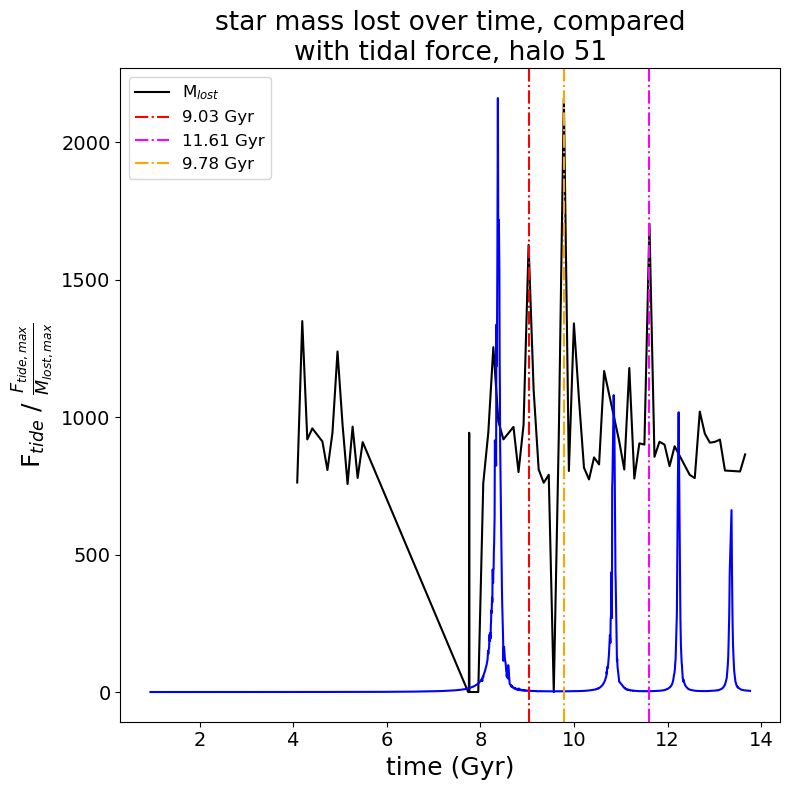

In [23]:
fig, ax = plt.subplots(figsize=(8,8))

plt.plot(relevant_times[:-1], mass_lost[:-1], color='black', label='M$_{lost}$')
plt.plot(tidal_times, tidal_forces / (max(tidal_forces) / max(mass_lost[:-1])), color='blue')

color_array = np.array(['red', 'magenta', 'orange'])

for i in range(np.size(max_loss_times)):
    plt.axvline(max_loss_times[i], color=color_array[i], linestyle='-.', \
                label=str(round(max_loss_times[i], 2)) + ' Gyr')

plt.legend(loc='upper left', prop={'size': 12}, ncol=1)
plt.title('star mass lost over time, compared\nwith tidal force, halo 51', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('F$_{tide}$ / ' + r'$\frac{F_{tide,max}}{M_{lost,max}}$', fontsize=18)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/star_loss_51.png')

Now, it seems that the tidal force peaks don't match the greatest mass losses, and that there are still other mass losses that aren't close to any tidal force peaks at all (see: before 6 Gyr in the previous plot). But note that the tidal force here is only the one exerted by Tempest. What if the earlier mass losses might've arisen from the tidal forces exerted by other satellite halos? It's best to do another check.

In [18]:
# First, we load in the other halos in the TANGOS database.

others = np.array([], dtype='object')
for i in range(np.size(all_sats)):
    if all_sats[i].halo_number not in starry_idx:
        others = np.append(others, all_sats[i]) # this ensures we're only checking for the verified starry halos

In [19]:
# Then, we find the locations and virial mass values of all the satellite halos around halo 51.

i = 0

all_other_t = []
all_other_r = []
all_other_rvir = []
all_other_mvir = []
available_sat_51_mvir = []

while i < np.size(others):
    
    # this finds the index of each of the OTHER halos (the ones around 51)
    other_idx = others[i].halo_number
    
    # this uses pre-coded tangos stuff to get M_vir and distance measurements at all available redshifts
    other_rvir, other_mvir, other_x, other_y, other_z, other_t = \
                        sim[-1][other_idx].calculate_for_progenitors('Rvir', 'Mvir', 'X', 'Y', 'Z', 't()')

    # now, we have to correct for the distance of the other halos from 51, which itself is also moving. 
    # to do this, we need to subtract the position of the satellite by the center of halo 51.
    
    # because 51 and the other halos might not be observed at the exact same amount of redshifts,
    # we first need to exclude the non-overlapping redshifts so that it's easier to subtract
    sat_51_time = np.copy(all_sat_t)
    sat_51_cen = np.copy(all_sat_cen)
    sat_51_mvir = np.copy(all_sat_mvir)
    sat_51_rvir = np.copy(all_sat_rvir)
    
    ### this checks for non-overlapping redshifts between 51 and others. 
    ### if non-overlapping, then array element set to 0
    for j in range(np.size(other_t)):
        if other_t[j] not in sat_51_time: 
            other_t[j] = 0.
            other_x[j] = 0.
            other_y[j] = 0.
            other_z[j] = 0.
            other_rvir[j] = 0.
            other_mvir[j] = 0.
            
    ### this checks for non-overlapping redshifts between others and 51. 
    ### if non-overlapping, then array element set to 0
    for k in range(np.size(sat_51_time)):
        if sat_51_time[k] not in other_t:
            sat_51_time[k] = 0.
            sat_51_cen[k] = 0.
            sat_51_mvir[k] = 0.
            sat_51_rvir[k] = 0.

    ### this removes all the zeros
    other_x = other_x[other_t != 0.]
    other_y = other_y[other_t != 0.]
    other_z = other_z[other_t != 0.]
    other_rvir = other_rvir[other_t != 0.]
    other_mvir = other_mvir[other_t != 0.]
    other_t = other_t[other_t != 0.]
    
    sat_51_cen = sat_51_cen[sat_51_time != 0.]
    sat_51_mvir = sat_51_mvir[sat_51_time != 0.]
    sat_51_rvir = sat_51_rvir[sat_51_time != 0.]
    sat_51_time = sat_51_time[sat_51_time != 0.]
        
    ### now we correct the x, y and z coordinates by the center of 51 at each snapshot
    for snapshot in range(np.size(other_t)):
        other_x[snapshot] -= sat_51_cen[snapshot][0]
        other_y[snapshot] -= sat_51_cen[snapshot][1]
        other_z[snapshot] -= sat_51_cen[snapshot][2]
        
    # finally, we get the 3D distance and scale it by the virial radius of the host halo (Tempest)
    other_r = np.sqrt(other_x**2 + other_y**2 + other_z**2)

    all_other_t.append(other_t)
    all_other_r.append(other_r * 1000)
    all_other_rvir.append(other_rvir)
    all_other_mvir.append(other_mvir)
    available_sat_51_mvir.append(sat_51_mvir)
        
    print(other_idx)
            
    i += 1
    
all_other_t = np.array(all_other_t, dtype='object')
all_other_r = np.array(all_other_r, dtype='object')
all_other_rvir = np.array(all_other_rvir, dtype='object')
all_other_mvir = np.array(all_other_mvir, dtype='object')
available_sat_51_mvir = np.array(available_sat_51_mvir, dtype='object')

print('success!')

87
54
21
109
50
12
115
118
99
73
100
113
127
27
success!


In [20]:
G = 4.30091e-3 # unit: pc (km/s)^2 / Msun

all_sat_Ftide = []

for i in range(np.size(all_other_t)):
    M = available_sat_51_mvir[i] # unit: Msun
    m = all_other_mvir[i] #        unit: Msun
    rvir = all_other_rvir[i] * 1000 # converting kpc to pc
    d = all_other_r[i] * 1000 # converting kpc to pc
    F = 2*G*M*m*rvir / (d**3)
    all_sat_Ftide.append(F)
        
all_sat_Ftide = np.array(all_sat_Ftide, dtype='object')

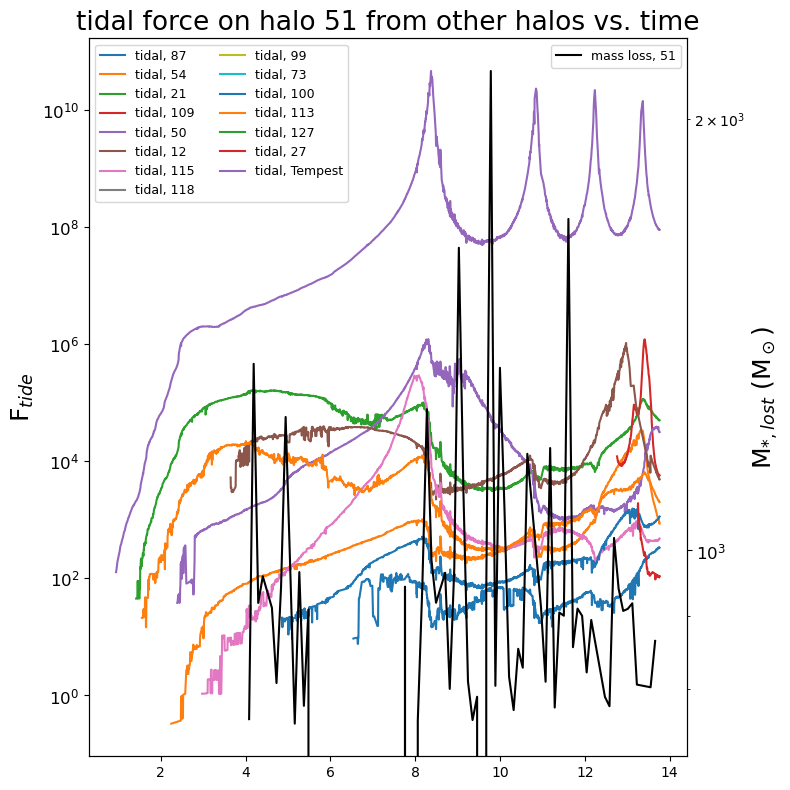

In [21]:
# now, let's plot the tidal force of each halo on 51!

fig, a1 = plt.subplots(figsize=(8,8))

for i in range(np.size(all_other_t)):
    a1.plot(all_other_t[i], all_sat_Ftide[i], label='tidal, ' + str(others[i].halo_number))

a1.plot(tidal_times, tidal_forces, label='tidal, Tempest')

a2 = a1.twinx()
a2.plot(relevant_times[:-1], mass_lost[:-1], color='black', label="mass loss, 51")

a1.legend(loc='upper left', prop={'size': 9}, ncol=2)
a2.legend(loc='upper right', prop={'size': 9}, ncol=3)

plt.title('tidal force on halo 51 from other halos vs. time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
a1.set_ylabel('F$_{tide}$', fontsize=18)
a1.set_yscale('log')
a1.tick_params(axis='y', labelsize=12)
a2.set_ylabel('M$_{*,lost}$ (M$_\odot$)', fontsize=18)
a2.set_yscale('log')
a2.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/tidal_and_star_loss_51.png')

In [24]:
# How to read in file that contains data on every star that is in Tempest's stellar halo at z=0
f = h5py.File('/Users/bnguyen/Downloads/Tempest_RD0042_allhalostardata.h5','r')
pids = f['particle_IDs'][:] # particle index of star - constant across simulation (int)
ptind = f['timestep_location'][:] # index of timestep at which star formed (int; 0->DD0044)
hids = f['host_IDs'].asstr()[:] # unique ID of halo in which star forms (string, constant across simulation)
pp = f['particle_positions'][:] # location at which star forms ([x,y,z], float, Mpc)
ct = f['particle_creation_times'][:] # time at which star was formed (float, Gyr)
ph = f['particle_hosts'][:] # halo number of halo in which star forms (int, holds only for timestep)
f.close()
# Note: some star particles form before our first saved timestep or in halos that our halo finder has lost track of.
# The vast majority can still be reliably assigned to a halo via other methods and therefore have a 'host_IDs' value.
# However, they may have 0s or -1s for 'timestep_location' and/or 'particle_hosts'.
# The 'host_IDs' value is the most important means of grouping halo stars. Star particles that formed in the same halo
# at different timesteps will have different 'timestep_locations' values and possibly different 'particle_hosts' values,
# but they will have the same 'host_IDs' value. The 'host_IDs' value can be understood as follows:
#   The number before the underscore is the timestep at which the star-forming halo was last distinguished by the halo
#   finder as an independent halo, either before it merged with another, more massive halo or before it lost too many
#   particles to be tracked.
#   The number after the underscore is the halo number of the halo at this timestep.
#   So, for example, a 'host_IDs' value of '1878_101' means that this star formed in a halo that is last 
#   distinguished at timestep DD1878 and has halo_number = 101 at this timestep. A star with 'host_IDs'='2427_1'
#   formed inside of Tempest itself.

In [25]:
lost_stars = np.unique(all_lost_stars)

creation_times = np.array([], dtype='object')
corresponding_halo = np.array([], dtype='object')

for star in lost_stars:
    if star in pids:
        creation_times = np.append(creation_times, ct[pids == star][0])
        corresponding_halo = np.append(corresponding_halo, hids[pids == star][0])
        print(ct[pids == star][0], hids[pids == star][0])
        
print('Done!')

0.952858153404667 0154_40
0.9942531659919057 0154_40
1.0285390816366335 2427_1
1.076862462362122 0154_40
1.083366298843223 0994_85
1.095698779300881 0154_40
1.1116086253070478 2427_1
1.115276380271511 2427_1
1.12287835555269 2427_1
1.1391054650014216 0326_1
1.1545098124915756 0386_39
1.1551057245811602 0386_39
1.160038106388485 0994_85
1.1620039298694387 0994_85
1.168647425655464 2427_1
1.1820707150339875 0326_2
1.2024281709377274 0154_40
1.20257469459442 0386_39
1.2129450266261155 0386_39
1.2134080926231732 0386_39
1.2208499748026476 0386_39
1.2451331010856286 0386_39
1.2531143484992204 0386_39
1.2556943858323018 0326_2
1.260899189803476 0994_85
1.2659081649244208 0386_39
1.2662828596679245 0994_85
1.267999452599615 0994_85
1.2684311608075012 0154_40
1.2697123897920537 0994_85
1.270279984034809 0386_39
1.2707840019173877 1779_14
1.2713495528643362 1779_14
1.271996595414004 0386_39
1.2724861580112945 0994_85
1.2743913095252422 0627_4
1.2777805087126866 0627_4
1.278646484779585 0627_4
1

1.5501249178308274 0994_85
1.5501922870014704 0627_4
1.554124209226087 1779_14
1.5556124285640087 2427_1
1.557067949913322 0994_85
1.5597676776575702 0386_39
1.5598320150872638 0326_1
1.5615271227617749 0627_4
1.5676028889354716 0386_39
1.5679976186293365 0627_4
1.5685550602428668 0627_4
1.569627393726141 2427_1
1.569876534612371 0627_4
1.5783549162030985 1779_14
1.581033452642555 0627_4
1.5818107578699157 0627_4
1.5828069798854743 0398_24
1.5831284905105159 1779_14
1.583926783546105 2427_1
1.5845073687310585 0627_4
1.5850769258973547 1779_14
1.5873563160005963 0627_4
1.5875330823001659 0627_4
1.587856559764354 0627_4
1.5881227861253688 0627_4
1.5899060885605856 0627_4
1.5899421021701667 0627_4
1.5923126546536104 0627_4
1.5925127749736558 0398_24
1.5930973489808016 0386_39
1.593404278741318 0627_4
1.5935106363682645 0627_4
1.5937845919006246 0627_4
1.5946268124316438 0627_4
1.5951398174895395 0386_39
1.5959191786503204 0627_4
1.596553779453599 0386_39
1.5970393837241947 0627_4
1.598482

1.8523103522785005 0326_1
1.852377901213964 1487_28
1.8523951816154636 1487_28
1.8534372309310168 0310_12
1.853629332658965 0994_85
1.854923942377003 1487_28
1.8554734923717178 0627_4
1.8562872659126632 1487_28
1.8563809135806937 1487_28
1.8563940470664986 0994_85
1.856747561853585 0312_251
1.8567738917066232 0312_251
1.8581175099050613 1487_28
1.8581218070310577 1487_28
1.8582301302761153 1487_28
1.858979387259982 0994_85
1.8590336371859921 0216_75
1.8593784591840092 0312_251
1.859871574690724 1487_28
1.8599179667854246 1487_28
1.8599746308388716 0312_251
1.8605152684365889 1487_28
1.8605891720444356 1487_28
1.8606269115518346 1487_28
1.8610362083958796 0312_251
1.8610890425887114 1487_28
1.8611851573026708 2427_1
1.861203530629836 1487_28
1.8612881618306116 1487_28
1.8613361131884234 1487_28
1.8613599746698193 0312_251
1.861417357750352 0326_1
1.8617080096496585 1487_28
1.8621332975024854 1487_28
1.8623819555293655 1487_28
1.8641422722813892 0994_85
1.864216185340306 0312_251
1.86429

1.966070836467473 1487_28
1.9662178386697098 1487_28
1.9663730170854985 1487_28
1.9664662671099837 1487_28
1.9667043517131788 0994_85
1.9667175880910224 1487_28
1.9667557823787347 1487_28
1.9668193882024467 0994_85
1.9668909235616256 1487_28
1.9668956932671395 1487_28
1.9669233595062563 1487_28
1.9669489834145875 1487_28
1.9671401839599394 1487_28
1.967369312351278 0994_85
1.967438147034924 1487_28
1.9692047543029312 0627_4
1.9720311650885356 1487_28
1.972063811504682 0994_85
1.97216521470375 1487_28
1.9722579164143619 0310_12
1.972406841454765 0994_85
1.9725313373161546 1487_28
1.9726739891859473 1487_28
1.9728550733549892 1487_28
1.9729289148309554 1487_28
1.973187576215892 1487_28
1.9733256178550724 1487_28
1.9733571630163853 1487_28
1.974149921481923 1487_28
1.9746467759886994 1487_28
1.9748887840880434 1487_28
1.9758804767112315 0627_4
1.9764216654893045 0326_2
1.9784895781825946 1487_28
1.9785326830967653 1487_28
1.978685106267191 1487_28
1.9786959565634237 0994_85
1.978981629936

2.098827608418173 0323_33
2.0989167947109273 1487_28
2.0990374733614368 0323_33
2.0990636002367884 0323_33
2.0992572480919494 2427_1
2.0996903355001684 1487_28
2.0999346488353017 1487_28
2.1014655880597592 1487_28
2.101484054692908 0745_57
2.101486740722012 1487_28
2.1016958710398685 1487_28
2.1017129577167766 1487_28
2.1017558558686265 0946_68
2.1019509438971253 1487_28
2.1022504316383244 0323_33
2.10242084126268 1487_28
2.1024409714831465 0323_33
2.102501145771797 1487_28
2.1028375100291243 1487_28
2.1028574718681132 1487_28
2.103060819132561 0386_39
2.1030908585805586 0627_4
2.1032437043227383 1487_28
2.1033002891260524 1487_28
2.103340069603069 0323_33
2.1034037762125264 0745_57
2.103575100343524 0323_33
2.1035811580616484 1487_28
2.103624871931331 1487_28
2.1036790463834683 1779_14
2.10397135245007 0627_4
2.1041019400072765 1487_28
2.104184262760345 0323_33
2.104514410412901 1487_28
2.1045817902945956 0323_33
2.104628946903841 1487_28
2.10465454903912 0323_33
2.104677562484551 148

2.2166839192345393 1092_39
2.2173814084275163 1092_39
2.21738502341284 1092_39
2.217736254679472 1092_39
2.2182560816947827 1092_39
2.2186719730443625 0745_57
2.218739098798069 0745_57
2.2190833913032937 0323_33
2.219260924362857 0745_57
2.2193420064634353 1092_39
2.2197602678296766 0323_33
2.220515823473578 0323_33
2.2209387375826393 0627_4
2.221411185561703 0323_33
2.22223201162517 0627_4
2.223440353524727 1487_28
2.2236773163738115 0323_33
2.223802715383749 0323_33
2.223945482035784 0627_4
2.22426628590787 0627_4
2.2244222038097483 0323_33
2.224723946795812 1779_14
2.226002886463386 1779_14
2.2265233601678656 0627_4
2.2266160445014567 0323_33
2.227369154183722 0323_33
2.228163174752534 0323_33
2.2283008508467246 1092_39
2.228638484118288 1487_28
2.229440588793715 1487_28
2.2294558341854325 1779_14
2.2295907008422113 1779_14
2.229677589291765 0627_4
2.22970665867701 1487_28
2.229867727755995 1779_14
2.229906768110179 1487_28
2.2300555970114004 1487_28
2.230061724815508 0627_4
2.23025

2.3418651047388943 1487_28
2.342568786028147 0323_33
2.3427790487468787 0946_68
2.3428885099319157 1487_28
2.342892238807746 0323_33
2.3435816434836836 0946_68
2.343700217080645 0946_68
2.3437031192673525 1487_28
2.3437063386485737 1487_28
2.3437609212080663 1779_14
2.343989083686667 0745_57
2.344011940979912 1487_28
2.3451116480129843 1092_39
2.345934800137576 2427_1
2.3459685450586316 0323_33
2.3464668691983745 0323_33
2.3465053205491206 0946_68
2.346808022262303 0323_33
2.3473537488350678 0323_33
2.3484961894618555 0400_62
2.349755167792006 0946_68
2.349879488290534 1092_39
2.3499139531457978 0323_33
2.3500555921337614 0400_62
2.3501283656236702 0946_68
2.350368659125528 0323_33
2.3504886174116146 0400_62
2.3510493988225716 0946_68
2.35106127205156 0946_68
2.3515227918127337 1092_39
2.3515377618957167 0400_62
2.351789986868317 0627_4
2.352088775534642 0323_33
2.352139954592119 1092_39
2.352499861243322 0627_4
2.3526099057979573 0400_62
2.3527283145920324 0946_68
2.3529084313416138 0

2.4396821661446 0323_33
2.4397321387351254 0627_4
2.440171520817208 0323_33
2.440504419171936 0946_68
2.4408126579977174 0946_68
2.4408797613484583 0946_68
2.4410435873845437 0946_68
2.4410435873845437 0946_68
2.4410748656992576 0946_68
2.44114374725214 0946_68
2.4414126985014004 0946_68
2.441529906327139 0946_68
2.4425446918625116 0946_68
2.4425737801184493 0946_68
2.4426557986636013 0946_68
2.442763856201356 0994_85
2.4431663850652225 0323_33
2.4432218274823168 0946_68
2.4432303245359397 0323_33
2.443819047198603 0946_68
2.4439937915056826 0946_68
2.444479596352698 0946_68
2.4446900456569325 0627_4
2.444756403142287 0994_85
2.445169728253606 0946_68
2.4455745032870313 0946_68
2.4456908107851154 0946_68
2.445822799932675 0386_39
2.445860227571864 1779_14
2.4459497777499415 1779_14
2.446819925017289 0946_68
2.4470676656274395 0946_68
2.44820507039954 0946_68
2.4485177670083216 0946_68
2.4485534172530876 0627_4
2.448788172257324 0326_1
2.4488077568582485 0627_4
2.449710776752067 0946_68

2.5074125293799865 0627_4
2.5076794459396137 1779_14
2.507901580470936 0627_4
2.5081780435414585 0373_57
2.508199986846386 0373_57
2.508278380567895 0373_57
2.508420137640368 0373_57
2.5093607332671803 1779_14
2.5096672031324876 1779_14
2.5096754312366105 0373_57
2.5099085041493585 0627_4
2.50992135717143 0373_57
2.5101770908137975 0373_57
2.510279371521343 1779_14
2.5112894771684586 0373_57
2.511580491360727 0373_57
2.5116919512772515 0373_57
2.5118614010191256 0373_57
2.511998488524389 0373_57
2.5120231665217414 2427_1
2.5124408740986195 0373_57
2.512751942265479 0373_57
2.5128305656636747 0373_57
2.5137923009708447 0373_57
2.5138779570364833 0373_57
2.5144785745827734 0373_57
2.515822242705224 0627_4
2.515907673594203 0448_94
2.5164773032828864 0373_57
2.516513433596213 0373_57
2.5170993257754763 0373_57
2.517940105075906 2427_1
2.518200788603204 0373_57
2.518340838511487 0373_57
2.5185512612376737 2427_1
2.5196064540637555 0373_57
2.519676696296758 2427_1
2.520270161229756 0627_4
2

2.5872859891231332 0946_68
2.587341914560008 0373_57
2.587375417611492 0373_57
2.5874836496074156 0373_57
2.5875654795159524 0946_68
2.5877901977556452 0400_62
2.587880625603235 0373_57
2.587904902512531 0946_68
2.588039328136024 0946_68
2.5880816509891718 0946_68
2.5880902455151618 0946_68
2.5880902455151618 0373_57
2.5884877502069275 0627_4
2.5885286295004284 0627_4
2.5886199789440427 0946_68
2.588643643014527 0373_57
2.588719354445304 0386_39
2.5888603320292645 0400_62
2.5889871851944193 0946_68
2.5889902343917233 0373_57
2.589110911772791 0373_57
2.5891179759720373 0373_57
2.589307460623322 0946_68
2.5893351648218257 0946_68
2.589566436526466 1779_14
2.58973752107269 0400_62
2.5897639161082084 0946_68
2.5897884620408123 0373_57
2.589831994685388 0373_57
2.5899217514862265 0946_68
2.5899335574910363 0946_68
2.590168833817402 0373_57
2.590366965180206 0400_62
2.590613637257803 0373_57
2.5907049372790443 0946_68
2.590799196567255 0946_68
2.5909816251989803 0946_68
2.591200819014818 09

2.705730243842815 1057_92
2.705800606864318 0946_68
2.7069512079328493 1487_28
2.707290506598183 0946_68
2.7074126078835192 2427_1
2.7074581150866153 0946_68
2.708238555588819 0400_62
2.708294514497294 1779_14
2.7085587249873693 2427_1
2.7087299318887488 1779_14
2.7091696626897384 0946_68
2.7092014552471078 0946_68
2.709311046423184 0946_68
2.7094668697772626 1092_39
2.7096471209251685 0946_68
2.7097431695389607 0946_68
2.7098922652079165 2427_1
2.709907054164852 0400_62
2.7099144438887968 0946_68
2.7099453471526487 0946_68
2.7101110242387074 0946_68
2.7105496736319696 0946_68
2.710700224172633 0946_68
2.7107311781682744 0994_85
2.7108271235826513 0946_68
2.710917982866228 0946_68
2.7110326846229107 0946_68
2.711331882769739 0946_68
2.7114067220601266 0946_68
2.711752932754883 2427_1
2.711824904777351 0946_68
2.71196589469085 0946_68
2.711991311582647 0946_68
2.711995012985321 0946_68
2.712030984038334 1057_92
2.712579763321612 1487_28
2.7126030493490902 1057_92
2.71274559810034 0946_6

2.8180128562905065 2427_1
2.818066281314992 0745_57
2.8188221157144664 0627_4
2.8188452211005184 2427_1
2.8198140048124483 0946_68
2.819891856935786 1779_14
2.8201221801845255 2427_1
2.820155936812966 0627_4
2.8208320297891767 2427_1
2.820907086346645 0627_4
2.8210309189844995 0627_4
2.8211357790791616 1779_14
2.821310451752968 0745_57
2.8218872323048814 2427_1
2.8220842868857243 0946_68
2.8220964124936585 0627_4
2.822343337756095 0627_4
2.8223589643719826 0627_4
2.8224441094655583 0627_4
2.8225701574201447 0994_85
2.8227920847178822 0627_4
2.8230217814207585 0627_4
2.8231271655369032 2427_1
2.823176550130909 0627_4
2.8232018591452785 0627_4
2.823394946503333 0627_4
2.8236334903129983 0627_4
2.8236664980215656 0946_68
2.8238646158650464 0627_4
2.8238759618394558 0627_4
2.8241284272174974 0994_85
2.824628457789926 0627_4
2.824657974376085 0627_4
2.825509799164046 2427_1
2.825522623687665 0627_4
2.826013128077697 0627_4
2.8261152377719267 2427_1
2.8265677624306065 0627_4
2.82690140377230

2.8886792546625246 0627_4
2.888967579601125 0946_68
2.889012196482935 0627_4
2.889467899338353 0946_68
2.8895796164462038 0946_68
2.889782943804492 0946_68
2.889782943804492 0627_4
2.8897903315666884 0946_68
2.889969066892893 0627_4
2.889998474210398 1779_14
2.8901685468575486 0627_4
2.8903425518768286 0946_68
2.890359537704787 0627_4
2.890376129187153 0946_68
2.890752132532719 0946_68
2.8908292267681017 0946_68
2.8913311678694096 0627_4
2.8913927549554232 0946_68
2.8914380920030873 0946_68
2.891454215073447 0946_68
2.891502567040153 0946_68
2.891502567040153 0946_68
2.891580876970932 1779_14
2.891766456336828 0627_4
2.8918226581344544 0946_68
2.8918318086970918 0627_4
2.891921908298723 0946_68
2.8919339266820385 0627_4
2.8921206634657795 0946_68
2.8928067663867707 1779_14
2.892851347894193 0994_85
2.8929604394699715 0946_68
2.8930608946927254 2427_1
2.893143520561389 0627_4
2.8933358973860233 0627_4
2.893444125371391 0627_4
2.8935013433720096 0627_4
2.8935073125423365 0627_4
2.8935793

2.942279140390089 1487_28
2.9424671516099354 0627_4
2.9430956681985982 0627_4
2.943492626521904 0627_4
2.9439791841326497 1057_92
2.9440515411691495 0627_4
2.9443123266073647 0994_85
2.944419033730387 1057_92
2.944509952451612 1779_14
2.9447513652545365 1057_92
2.944892576835809 0627_4
2.9449480334684597 0627_4
2.9452737990335716 1057_92
2.9452909884417258 0627_4
2.945349597280137 0627_4
2.946225370275949 0627_4
2.94687616825776 0627_4
2.947011279137262 0627_4
2.9472669549860147 0627_4
2.9475928106064933 0627_4
2.947748361544417 0627_4
2.948309312416061 0627_4
2.94887939961217 0627_4
2.948988834037229 0627_4
2.9491785605223915 0627_4
2.950332389878196 0627_4
2.950568496184856 0627_4
2.950653839489352 0627_4
2.950875108193343 0627_4
2.950979243353837 0627_4
2.9514381740517077 0627_4
2.9515673838275402 0627_4
2.951723196487771 0627_4
2.9522980892893593 1487_28
2.9528774346734448 0627_4
2.953502818807634 0627_4
2.9535361558719044 0627_4
2.953692813790509 0627_4
2.954049229172762 0627_4
2.

3.0112676889418886 0745_57
3.011360639679429 0745_57
3.0114228459309467 0745_57
3.0114999587909685 0745_57
3.011552938834339 0745_57
3.0116448156767577 0745_57
3.0118008216998717 0745_57
3.011828288301065 0745_57
3.011851740225431 0745_57
3.011875954578154 0745_57
3.011935674408075 0745_57
3.012032333893271 0745_57
3.012032333893271 0745_57
3.012217416962048 0745_57
3.0122836659204903 0745_57
3.012325477327884 0745_57
3.0125485793188775 0745_57
3.012603072774067 0745_57
3.0128054906394426 0745_57
3.012928868751298 0745_57
3.0129941279538235 0745_57
3.013107093478393 0745_57
3.013107093478393 0745_57
3.01332497437179 0745_57
3.0133859979211364 0745_57
3.0135385561085255 0745_57
3.013625563853213 0745_57
3.0137405593406688 0745_57
3.013774893794198 0745_57
3.0138028433682016 0745_57
3.013859770869567 0745_57
3.013881282795941 0745_57
3.0138890450802553 0745_57
3.0139358982814737 0745_57
3.014008123620259 0745_57
3.0140128484238526 0745_57
3.014143611930258 0745_57
3.0141673042664188 0745

3.130712065669032 0627_4
3.1318088595828493 1487_28
3.13365779325686 1779_14
3.134337437197368 1779_14
3.1350521873589283 1057_92
3.1365444614567677 0745_57
3.1367041334066443 1092_39
3.1382885504797344 0627_4
3.1395251491496827 0627_4
3.1396615996844344 1092_39
3.1440464873532505 0627_4
3.147078595464311 1779_14
3.148056487766461 0745_57
3.150485815742063 0745_57
3.150493523245197 0627_4
3.150569432116295 0745_57
3.150972950235257 0745_57
3.1537148819934187 0627_4
3.157321347968465 1092_39
3.1592382780395356 1092_39
3.159313616164805 1092_39
3.163205933858404 0627_4
3.1663393550455963 0745_57
3.168377810305914 1092_39
3.171712931984886 1092_39
3.172860875643517 1487_28
3.1738987206403184 1092_39
3.174189177689972 1092_39
3.183668208017811 0627_4
3.1861012978569456 1487_28
3.1864562548083684 1092_39
3.1871834148568863 1092_39
3.188055595490402 1487_28
3.1881526714731963 1487_28
3.1889555479907314 1092_39
3.1907765161760784 1487_28
3.1914180737057625 1092_39
3.191873125098088 1092_39
3.

3.5080973612028106 0745_57
3.5137854684164034 1092_39
3.5188109927706592 0745_57
3.526844975782647 1779_14
3.5277360001599725 1092_39
3.5289671344518942 1092_39
3.5328032309318598 0627_4
3.5368539210907577 0627_4
3.5409246430611026 1092_39
3.542427489189447 0627_4
3.5437095945954464 0745_57
3.545224823260903 0627_4
3.5480747969885864 0745_57
3.5483569616488517 0946_68
3.5484886357520478 0946_68
3.548560393784311 0946_68
3.5673532055358934 1092_39
3.570723190374771 0745_57
3.573981180483126 1092_39
3.575059543358139 1092_39
3.5792301789637624 0745_57
3.581683805264275 0745_57
3.5838244311699237 0745_57
3.5862699185960865 1092_39
3.586443360991276 1092_39
3.5872775820686504 0627_4
3.589103754283596 0745_57
3.58973647219928 0627_4
3.5947630191416073 1092_39
3.594923576787664 1092_39
3.595496216097129 1092_39
3.5993938085613015 0627_4
3.6001431159208908 0745_57
3.6001796656813827 0745_57
3.602058298499202 1092_39
3.603913059348796 0745_57
3.6116566422575236 1092_39
3.6210731718954663 0745_

3.9896344352742745 0627_4
3.989859439422314 0627_4
3.9898859351863396 0627_4
3.9900080436451315 0627_4
3.990101394286366 0627_4
3.990195610836451 0627_4
3.9903046693156203 0627_4
3.990395094422069 0627_4
3.9904996784411972 0627_4
3.9906007113723807 0627_4
3.990778487311145 0745_57
3.9911131064978327 0627_4
3.9912702912151494 0627_4
3.9914811740884217 0627_4
3.9917732046583123 0627_4
3.9918466344956074 0627_4
3.991913973577354 0745_57
3.992062511274652 0627_4
3.992109908818033 0627_4
3.992870848013423 0627_4
3.992870848013423 0627_4
3.9930763752615728 0627_4
3.9932501298437733 2427_1
3.993339681150556 0627_4
3.993930488628213 0627_4
3.993943938911736 0627_4
3.993987481130962 0627_4
3.994130648881393 0627_4
3.994496634550953 2427_1
3.9945422623100915 0627_4
3.994669809490536 0627_4
3.9949293342495182 1487_28
3.9950325494672465 0627_4
3.9955938916757248 0745_57
3.9956546983421286 0627_4
3.9957737570030774 0627_4
3.9961947535195015 0627_4
3.9963207966269674 0627_4
3.9963304486759053 0627_4

4.181178605628118 0745_57
4.181657307944685 2427_1
4.181969561303095 0745_57
4.182784095194738 0745_57
4.1844602160543465 0745_57
4.185425212424955 0745_57
4.185664480970822 0745_57
4.185790773411038 2427_1
4.1864309053915205 0745_57
4.186868012594537 0745_57
4.186944224245495 0745_57
4.187429212678554 0745_57
4.187712394875893 2427_1
4.189803565356102 2427_1
4.1903820085866865 0745_57
4.190551456668849 1487_28
4.1908278088268816 1487_28
4.191061138363546 0745_57
4.192054754221016 2427_1
4.192581040610703 0745_57
4.193721587850699 1779_14
4.19375166768728 0745_57
4.193900919427561 2427_1
4.195464555084358 0745_57
4.196099549712546 0745_57
4.197839472998594 0745_57
4.1987353503581 2427_1
4.198811887406572 0745_57
4.199709468668072 0745_57
4.200634489173099 0745_57
4.203154321375751 0745_57
4.205218817944454 1487_28
4.206579257412408 2427_1
4.206928280247992 0745_57
4.209440253291365 0745_57
4.21028960855813 0745_57
4.2118078516143775 2427_1
4.218819499546817 2427_1
4.225189418160703 242

4.369106714039351 0745_57
4.369644290135962 0745_57
4.370080303523398 0946_68
4.3703854304303595 0946_68
4.370718119934438 1487_28
4.371210390208941 0745_57
4.371415485521725 0745_57
4.3716338163668995 0745_57
4.371896369055596 0745_57
4.371959222625466 0745_57
4.372649636770922 0745_57
4.373689071935565 0946_68
4.373689071935565 1487_28
4.373942321224088 0745_57
4.375192833600079 0745_57
4.375953907224788 2427_1
4.378348371691855 1487_28
4.378671226236812 0745_57
4.379241128621278 0946_68
4.379641701727239 0745_57
4.379725412460149 1487_28
4.380545112278505 1487_28
4.381992054382269 2427_1
4.3834880194637025 0946_68
4.383894174880215 0946_68
4.383966575687184 0946_68
4.384621497313205 0946_68
4.384809866402945 0946_68
4.3850125729261045 0745_57
4.38827136496273 1487_28
4.388292573175506 1487_28
4.390242124582193 1487_28
4.39043567569202 2427_1
4.394731942056849 2427_1
4.395368742503345 2427_1
4.395623063379378 2427_1
4.3977712989605235 1487_28
4.398992679974698 2427_1
4.40001767175381

7.880263633990475 2427_51
7.880298263778861 2427_51
7.880316037742152 2427_51
7.880357568479449 2427_51
7.880664626547508 2427_51
7.88067098371557 2427_51
7.895942568629632 2427_51
7.896022484931799 2427_51
7.8960396184782935 2427_51
7.896047740048268 2427_51
7.896057692519778 2427_51
7.896143490796449 2427_51
7.896170896117546 2427_51
7.896275291741903 2427_51
7.8962937050091035 2427_51
7.8963072780921335 2427_51
7.896315271777048 2427_51
7.896953085706144 2427_51
7.897064296511184 2427_51
7.8970718828811695 2427_51
7.89709620542498 2427_51
7.908021857138882 2427_51
7.908040812308869 2427_51
7.908057591003758 2427_51
7.908074071086446 2427_51
7.9080925716791715 2427_51
7.908757092511424 2427_51
7.908810663904535 2427_51
7.908838050504345 2427_51
7.908874241520281 2427_51
7.908892429629747 2427_51
7.908929772428968 2427_51
7.908964607169117 2427_51
7.9090563924329755 2427_51
7.909112452538977 2427_51
7.909165633377909 2427_51
7.928190357932992 2427_51
7.928211841873425 2427_51
7.928319

7.9596339757882575 2427_51
7.959663598287398 2427_51
7.959670379924167 2427_51
7.959696441270266 2427_51
7.959806186975521 2427_51
7.959816612489182 2427_51
7.959823760691294 2427_51
7.9598764263605375 2427_51
7.959941303582002 2427_51
7.959955835806402 2427_51
7.959969317424565 2427_51
7.960043953673479 2427_51
7.960050137243745 2427_51
7.960085570589222 2427_51
7.960105732983912 2427_51
7.960120879948136 2427_51
7.9601291745406595 2427_51
7.960169931278848 2427_51
7.960202355291687 2427_51
7.960246610598704 2427_51
7.960261667838261 2427_51
7.960292266711856 2427_51
7.96059429427358 2427_51
7.960623042585052 2427_51
7.960630942739509 2427_51
7.960650846889397 2427_51
7.960668237675612 2427_1
7.960733119618477 2427_51
7.960741358573237 2427_51
7.960750364265062 2427_51
7.960758469085905 2427_51
7.960767834667341 2427_51
7.9608366630713165 2427_51
7.9608574316370815 2427_51
7.960879371298199 2427_51
7.960886993273781 2427_51
7.960890378449528 2427_51
7.9608979878240715 2427_51
7.960916

8.049121530649384 2427_51
8.049716403251455 2427_51
8.049747166977351 2427_51
8.049814364231548 2427_51
8.049853806838314 2427_51
8.049861459607744 2427_51
8.049877083244834 2427_51
8.051172974066859 2427_51
8.051207729882336 2427_51
8.051223534168647 2427_51
8.051233145443373 2427_51
8.051248990447641 2427_51
8.051328074640985 2427_51
8.051344161760724 2427_51
8.05138378696168 2427_51
8.05139574727885 2427_51
8.051879946561623 2427_51
8.051910208765314 2427_51
8.051938639346524 2427_51
8.051946494307321 2427_51
8.05197583225399 2427_51
8.052004296607022 2427_51
8.052034605540788 2427_51
8.052049867702332 2427_51
8.052065672797752 2427_51
8.052098478510619 2427_51
8.052135829157043 2427_51
8.052158580157478 2427_51
8.052173741303498 2427_51
8.052196175410206 2427_51
8.052203288518836 2427_51
8.05221147923247 2427_51
8.052226884598475 1779_14
8.052249418139585 2427_51
8.05228000398175 2427_51
8.052287306899398 2427_51
8.052312427369271 2427_51
8.052329743055852 2427_51
8.05236787599677 

8.114411164412425 2427_51
8.114433981306647 2427_51
8.114448618112213 2427_51
8.114488516392708 2427_51
8.114498750272661 2427_51
8.114714077663335 2427_51
8.11479957135185 2427_51
8.11481808394029 2427_51
8.114844325941547 2427_51
8.114867719942703 2427_51
8.11493934455708 2427_51
8.114962045702322 2427_51
8.115013530106557 2427_51
8.11528248526543 2427_51
8.11530640515778 2427_51
8.115324504996773 2427_51
8.115351205872667 2427_51
8.11538166825966 2427_51
8.115412077287726 2427_51
8.115428598948414 2427_51
8.11549738938895 2427_51
8.115555032559273 2427_51
8.115605262248131 2427_51
8.115640959838782 2427_51
8.115675212687398 2427_51
8.115753885326406 2427_51
8.123662664249359 2427_51
8.12369767386921 2427_51
8.123783593609343 2427_51
8.123791406831534 2427_51
8.123811272937774 2427_51
8.13511472975573 2427_51
8.135121773548148 2427_51
8.13514479612652 2427_51
8.135160870090214 2427_51
8.135195290013447 2427_51
8.143490355270957 2427_51
8.143511463484751 2427_51
8.14351945635706 2427_

8.211694721340114 2427_51
8.211743542515187 2427_51
8.212148647014448 2427_51
8.212162698618403 2427_51
8.212184987795633 2427_51
8.212205731464373 2427_51
8.212232384713959 2427_1
8.21225493983335 2427_51
8.212284756017473 2427_51
8.212397817053983 2427_1
8.212420801977313 2427_51
8.212512251447697 2427_51
8.212525026462378 2427_51
8.212547706658823 2427_51
8.21273077566175 2427_51
8.212797418779777 2427_51
8.212839217935679 2427_51
8.212879044593745 2427_51
8.213982040754129 2427_51
8.214005284197924 2427_51
8.214049926761035 2427_51
8.21409693335669 2427_51
8.214107309691098 2427_51
8.214198937264781 2427_51
8.214225819996981 2427_51
8.21428410017883 2427_51
8.214408783345494 2427_51
8.214469001369906 2427_51
8.214518092697002 2427_51
8.214528309145916 2427_51
8.214552787058997 2427_51
8.214758820882272 2427_51
8.214782266860885 2427_51
8.214822810526318 2427_51
8.214914390078858 2427_51
8.214924178322478 2427_51
8.214946557875312 2427_51
8.214994557660521 2427_51
8.215003161368681 

8.243391377600336 2427_51
8.243420675647108 2427_51
8.243435508923906 2427_51
8.243444142072544 2427_51
8.243462954454209 2427_51
8.243483771756512 2427_51
8.243502760904052 2427_51
8.243546407926148 2427_51
8.243568223111 2427_51
8.243576674586535 2427_51
8.243595837627684 2427_51
8.243609797015308 2427_51
8.24362055670787 2427_51
8.243629273734156 2427_51
8.24364846742295 2427_51
8.243662927671892 2427_51
8.243677534148897 2427_51
8.24368614948393 2427_51
8.24369670471564 2427_51
8.243705394735294 2427_51
8.243712970329577 2427_51
8.243732094091737 2427_51
8.243764648282566 2427_51
8.243783516134517 2427_51
8.243807294472337 2427_51
8.243815903665466 2427_51
8.243825923318008 2427_51
8.243849423464468 2427_51
8.243857976078676 2427_51
8.243876296728825 2427_51
8.243890936995331 2427_51
8.24392654293493 2427_51
8.243941967358865 2427_51
8.243948837701511 2427_51
8.243955957546952 2427_51
8.244567519559256 2427_51
8.245441453838902 2427_51
8.245454272668363 2427_51
8.245480766798563 24

8.263318162426415 2427_51
8.263328771218328 2427_51
8.263336417732006 2427_51
8.263344083205661 2427_51
8.263351759210552 2427_51
8.263360230383249 2427_51
8.263367950032599 2427_51
8.26338074622072 2427_51
8.263388523489205 2427_51
8.26342321697282 2427_1
8.263431028930084 2427_51
8.263443133775542 2427_51
8.263459418088672 2427_51
8.263529834093916 2427_51
8.263536970980676 2427_51
8.263546251679761 2427_51
8.263553411050314 2427_51
8.263588467291886 2427_51
8.263601828331183 2427_51
8.263618181192756 2427_51
8.263630489351467 2427_51
8.263637379378332 2427_51
8.26364686995145 2427_51
8.263653713863043 2427_51
8.263666177150787 2427_51
8.263672972365155 2427_51
8.263681639471962 2427_51
8.26368839943288 2427_51
8.263697859324854 2427_51
8.263704578524042 2427_51
8.263717251367561 2427_51
8.26372392240274 2427_51
8.263733338091102 2427_51
8.263739983243632 2427_51
8.263749386315487 2427_51
8.263759393585719 2427_51
8.263767435418043 2427_51
8.263782999677066 2427_51
8.263789602574276 

8.26766421410293 2427_51
8.267669134197778 2427_51
8.267676904367548 2427_51
8.267687967199356 2427_51
8.267698158043265 2427_51
8.267706049752718 2427_51
8.267716347936458 2427_51
8.267724224808832 2427_51
8.267724224808832 2427_51
8.267732105848966 2427_51
8.267734833780937 2427_51
8.267742726602371 2427_51
8.26775425249744 2427_51
8.26777191907114 2427_51
8.267791895447555 2427_51
8.267800012772769 2427_51
8.267808119247878 2427_51
8.267811625259236 2427_51
8.267827937042073 2427_51
8.26784800370007 2427_51
8.267866797564164 2427_51
8.267871123720804 2427_51
8.267879036783503 2427_51
8.267891544431244 2427_51
8.267912105910234 2427_51
8.267924140800845 2427_51
8.267931002171908 2427_51
8.267944138063019 2427_51
8.267950460145123 2427_51
8.267964601432285 2427_51
8.267970815020965 2427_51
8.267984882012742 2427_51
8.267998069438852 2427_51
8.268008500497436 2427_51
8.26801545493714 2427_51
8.268026115168475 2427_51
8.268113807580365 2427_51
8.268132209697962 2427_51
8.268136850361564

8.309918470094335 2427_51
8.30993670032474 2427_51
8.3099664274342 2427_51
8.309976453669117 2427_51
8.31012501084566 2427_51
8.3102115860757 2427_51
8.310250740896596 2427_51
8.310296903826343 2427_51
8.310737049917936 2427_51
8.310792194871034 2427_51
8.310804960126196 2427_51
8.311615618589464 2427_51
8.31166562698951 2427_51
8.314776806150595 2427_51
8.314789735757332 2427_51
8.314811972347929 2427_51
8.314818479907181 2427_51
8.315177730031076 2427_51
8.315253798205209 2427_51
8.315293237937341 2427_51
8.315300875856497 2427_51
8.315317767598255 2427_51
8.31532546724663 2427_51
8.315360592414534 2427_51
8.315559666081896 2427_51
8.315610740549129 2427_51
8.315650277615537 2427_51
8.315657881348905 2427_51
8.31573285299518 2427_51
8.31578007853543 2427_51
8.315921991180561 2427_51
8.315962685760331 2427_51
8.315986472072591 2427_51
8.315993369056109 2427_51
8.316004885175625 2427_51
8.316011966195545 2427_51
8.316023105946787 2427_51
8.316120905428727 2427_51
8.31615067087911 2427_

8.405406067869725 2427_51
8.405439729564765 2427_51
8.40544768932662 2427_51
8.405479911919787 2427_51
8.405487883995654 2427_51
8.40808479213801 2427_51
8.409558482032908 2427_51
8.409583296173903 2427_51
8.409593092901595 2427_51
8.409629186559068 2427_51
8.409637728632307 2427_51
8.409656480577695 2427_51
8.409671960102832 2427_51
8.409690401950117 2427_51
8.409723276098626 2427_51
8.40973240374591 2427_51
8.4097655889108 2427_51
8.409814253581313 2427_51
8.409822351742545 2427_51
8.409886282324235 2427_51
8.40991182292852 2427_51
8.409953466281616 2427_51
8.41016090034431 2427_51
8.410264804042747 2427_51
8.410307692091324 2427_51
8.410335290820388 2427_51
8.410358431966182 2427_51
8.41038446573655 2427_51
8.410400239072183 2427_51
8.4104139865999 2427_51
8.410446837180169 2427_51
8.410454164015576 2427_51
8.410599418733058 2427_51
8.410666812533814 2427_51
8.410678535373323 2427_51
8.410689682630059 2427_51
8.410712737288668 2427_51
8.410724983878552 2427_51
8.410748049989886 2427

8.415879843325243 2427_51
8.41588693408644 2427_51
8.415909287366613 2427_51
8.415916315621855 2427_51
8.415946494274225 2427_51
8.415968868226614 2427_51
8.41598390937935 2427_51
8.416021504673411 2427_51
8.416030313780551 2427_51
8.416037425482399 2427_51
8.416052198878461 2427_51
8.416072230853336 2427_51
8.416081978303977 2427_51
8.416089439460684 2427_51
8.416103262741474 2427_51
8.416110851425318 2427_51
8.416127348485382 2427_51
8.416141695322905 2427_51
8.416148943201224 2427_51
8.416158389735733 2427_51
8.416172167601777 2427_51
8.416178898074474 2427_51
8.416189324890732 2427_51
8.416195874467224 2427_51
8.416217171561584 2427_51
8.416227839268634 2427_51
8.4162344481226 2427_51
8.416255886592344 2427_51
8.416265211953267 2427_51
8.416271790633816 2427_51
8.416280623992659 2427_51
8.416298768145909 2427_51
8.416307647773692 2427_51
8.416330348144273 2427_51
8.416346497743604 2427_51
8.416374824843405 2427_51
8.41638460110695 2427_51
8.416405189372378 2427_51
8.416434220232977

8.420596341607665 2427_1
8.420605538242288 2427_1
8.420635810118336 2427_1
8.420647490639102 2427_1
8.42065156140761 2427_1
8.42066741385911 2427_1
8.42067343732305 2427_1
8.420685857143122 2427_1
8.420701927733868 2427_1
8.420711592159535 2427_1
8.420727692409201 2427_1
8.420736887779562 2427_1
8.420743805882184 2427_1
8.420753199987303 2427_1
8.420760180188912 2427_1
8.420779548672156 2427_1
8.420811438934754 2427_1
8.420835158801824 2427_1
8.42085004103871 2427_1
8.420857577569812 2427_1
8.420866075773187 2427_1
8.420880958304444 2427_1
8.420896841141492 2427_1
8.420905126836535 2427_1
8.420912454423464 2427_1
8.420919557469244 2427_1
8.420928331040395 2427_1
8.420935118741891 2427_1
8.420944275275204 2427_1
8.420948944011096 2427_1
8.420955408707288 2427_1
8.420977583051918 2427_1
8.421006507517529 2427_1
8.421012739865592 2427_1
8.421032576387415 2427_1
8.421038945116804 2427_1
8.421049060981384 2427_1
8.421072453708637 2427_1
8.421088605217205 2427_1
8.421141379271164 2427_1
8.42

8.426435187824573 2427_1
8.42651700858803 2427_1
8.42654250546404 2427_1
8.426553361561588 2427_1
8.426567463594651 2427_1
8.426669570247546 2427_1
8.426698199515311 2427_1
8.426706080397945 2427_1
8.426723646243687 2427_1
8.426760474121325 2427_1
8.426775235021053 2427_1
8.426800225198482 2427_1
8.42692195220538 2427_1
8.426955673947887 2427_1
8.427015238492247 2427_1
8.427041383260812 2427_1
8.427048341223973 2427_1
8.427174480113445 2427_1
8.427237167256393 2427_1
8.427283412879175 2427_1
8.427290918833876 2427_1
8.427334361801732 2427_1
8.427434857064627 2427_1
8.427441942318966 2427_1
8.427635432506968 2427_1
8.427676820149358 2427_1
8.427684376332214 2427_1
8.42770177630837 2427_1
8.427724550670762 2427_1
8.42776491294962 2427_1
8.427783226604877 2427_1
8.427791037973137 2427_1
8.428110091360676 2427_1
8.428147196069084 2427_1
8.428164269314605 2427_1
8.42819323680504 2427_1
8.42820468191094 2427_1
8.428242148867866 2427_1
8.428527919365488 2427_1
8.42856165257412 2427_1
8.428608

8.444721857413573 2427_1
8.444730948480501 2427_1
8.444738515108444 2427_1
8.444755964453138 2427_1
8.444763598832632 2427_1
8.44477253867075 2427_1
8.44478013053023 2427_1
8.444789092656587 2427_1
8.444794337884444 2427_1
8.444801890749897 2427_1
8.444810855292694 2427_1
8.444818400064712 2427_1
8.444827386327002 2427_1
8.444833084677338 2427_1
8.44484064746592 2427_1
8.444854692472124 2427_1
8.444862299323564 2427_1
8.444871291453724 2427_1
8.44487895090121 2427_1
8.444901655871869 2427_1
8.444910673491481 2427_1
8.444918340114722 2427_1
8.444927481485434 2427_1
8.444952395703721 2427_1
8.4449693722627 2427_1
8.444986394899363 2427_1
8.444992107698855 2427_1
8.444998372061443 2427_1
8.445005994263852 2427_1
8.445015458033222 2427_1
8.445023160340531 2427_1
8.445038198374844 2427_1
8.44505527368381 2427_1
8.44506311607737 2427_1
8.445072354566063 2427_1
8.445078169885893 2427_1
8.445085953596982 2427_1
8.445095113351792 2427_1
8.445102871319797 2427_1
8.445135269403357 2427_1
8.445142

8.448311272597266 2427_1
8.448319109717726 2427_1
8.448328752194747 2427_1
8.448339118127484 2427_1
8.448356650041744 2427_1
8.44836633334388 2427_1
8.448382399718174 2427_1
8.44839270801037 2427_1
8.44840225623108 2427_1
8.448411183863893 2427_1
8.44842070926855 2427_1
8.448431310358528 2427_1
8.448440813947753 2427_1
8.448450259990395 2427_1
8.448455878014567 2427_1
8.448465285721156 2427_1
8.448476472130348 2427_1
8.448485822153938 2427_1
8.448495636658151 2427_1
8.448504718004006 2427_1
8.448513585379343 2427_1
8.448516508578463 2427_1
8.448525168346002 2427_1
8.448534988603136 2427_1
8.448540087945567 2427_1
8.448548494916809 2427_1
8.448556855204437 2427_1
8.448561438314526 2427_1
8.448569739759456 2427_1
8.448578925041767 2427_1
8.448587195304958 2427_1
8.448595467525807 2427_1
8.448600481670496 2427_1
8.448608729743231 2427_1
8.448617376572631 2427_1
8.448625638535667 2427_1
8.448634076249594 2427_1
8.44864223829618 2427_1
8.44865039230421 2427_1
8.448656197529964 2427_1
8.4486

8.451210774401124 2427_1
8.451213908686546 2427_1
8.451221449448747 2427_1
8.451229049654392 2427_1
8.45123638829003 2427_1
8.451243987788725 2427_1
8.451251595306502 2427_1
8.451259277485374 2427_1
8.451269520654959 2427_1
8.451277275276464 2427_1
8.451284924694132 2427_1
8.4512926612658 2427_1
8.451302598135323 2427_1
8.451311144410115 2427_1
8.451318808141002 2427_1
8.451326564332293 2427_1
8.451334009853287 2427_1
8.451344153463335 2427_1
8.451351420204997 2427_1
8.45135957404732 2427_1
8.451366762393953 2427_1
8.451377012774396 2427_1
8.451384159822986 2427_1
8.451392555002995 2427_1
8.451399686072307 2427_1
8.45140396331411 2427_1
8.451411092277155 2427_1
8.451419642522985 2427_1
8.451426779004521 2427_1
8.451436500124146 2427_1
8.451443665754736 2427_1
8.451452000762634 2427_1
8.45145907603958 2427_1
8.451468939398577 2427_1
8.451475936176967 2427_1
8.451484311636808 2427_1
8.451491279999495 2427_1
8.451498527433547 2427_1
8.451505470005262 2427_1
8.451513746600538 2427_1
8.4515

8.454264215129815 2427_51
8.45426979686455 2427_51
8.454281071340137 2427_51
8.454286633936073 2427_51
8.454292189272246 2427_51
8.454313711018568 2427_51
8.454319256197975 2427_51
8.454324011404658 2427_51
8.454332627421783 2427_51
8.454338167097701 2427_51
8.454347841887332 2427_51
8.45435336053447 2427_51
8.454358848431383 2427_51
8.454371017323643 2427_51
8.454376365073797 2427_51
8.454385097540058 2427_51
8.454390348690302 2427_51
8.454398783153882 2427_51
8.454403980842624 2427_51
8.45442693174083 2427_51
8.454436927439406 2427_51
8.454442078583176 2427_51
8.454450136846646 2427_51
8.454455245285978 2427_51
8.454460348932281 2427_51
8.454463441462059 2427_51
8.454468555510314 2427_51
8.454473975097622 2427_51
8.454479129466101 2427_51
8.454499941351527 2427_51
8.45452212579557 2427_51
8.454527668233533 2427_51
8.454532214976657 2427_51
8.454545246380421 2427_51
8.454558088748456 2427_51
8.454570488265109 2427_51
8.45458318290504 2427_51
8.45460400732613 2427_51
8.454629812536869 

8.45778386078425 2427_51
8.457794354619198 2427_51
8.45780200765989 2427_51
8.457812340762093 2427_51
8.457817994414533 2427_51
8.457825715254064 2427_51
8.457836032317818 2427_51
8.457846059420213 2427_51
8.457853910337501 2427_51
8.457864313407292 2427_51
8.457872303439517 2427_51
8.45788738198521 2427_51
8.457895581101884 2427_51
8.457906264500256 2427_51
8.457914571549255 2427_51
8.457928824137056 2427_51
8.457957022369456 2427_51
8.45797525902506 2427_51
8.45800696430471 2427_51
8.458016906519823 2427_51
8.45804901181634 2427_51
8.458078275343697 2427_51
8.458088612015665 2427_51
8.45811792187662 2427_51
8.45815284923048 2427_51
8.458180747267638 2427_51
8.458196866583606 2427_51
8.458205808007753 2427_51
8.45821593269625 2427_51
8.458224736733207 2427_51
8.458243852179073 2427_51
8.458253095691095 2427_51
8.458263066463477 2427_51
8.458270009887295 2427_51
8.458279367099392 2427_51
8.458308908112384 2427_51
8.458316052964218 2427_51
8.458325520913522 2427_51
8.458361527758866 242

8.465467548764043 2427_51
8.465494657289975 2427_51
8.465502622529197 2427_51
8.46551039252204 2427_51
8.46552254557813 2427_51
8.46553035967029 2427_51
8.465537944924893 2427_51
8.465548749701503 2427_51
8.465564135054702 2427_51
8.465583290098238 2427_51
8.465591185612093 2427_51
8.465598850220436 2427_51
8.465617503057539 2427_51
8.465633063871795 2427_51
8.46565324063186 2427_51
8.46567950606828 2427_51
8.465687542475408 2427_51
8.465714130051273 2427_51
8.465734954906639 2427_51
8.465743130206063 2427_51
8.465762232782533 2427_51
8.465770301840797 2427_51
8.465778635550501 2427_51
8.465786666685883 2427_51
8.465806575915487 2427_51
8.46581478885094 2427_51
8.465860121909 2427_51
8.465896485581988 2427_51
8.465904356569064 2427_51
8.465944451990676 2427_51
8.465961759204147 2427_51
8.465981616732295 2427_51
8.465999135751286 2427_51
8.466006652852764 2427_51
8.46601920476333 2427_51
8.466036924578198 2427_51
8.46604483932083 2427_51
8.466052876798804 2427_51
8.466071226392742 2427_

8.47590310533044 2427_1
8.475939347341932 2427_1
8.475963126352932 2427_1
8.476014826887347 2427_1
8.476024013733756 2427_1
8.476057520996969 2427_1
8.476089516064564 2427_1
8.476290557940564 2427_1
8.476323646405408 2427_1
8.476339501272177 2427_1
8.476355521190705 2427_1
8.476403568579794 2427_1
8.47644317115584 2427_1
8.476465465757885 2427_1
8.476473051192675 2427_1
8.476520709577416 2427_1
8.476585573837271 2427_1
8.47660212623586 2427_1
8.476637680253912 2427_1
8.476669860739245 2427_1
8.476677938202563 2427_1
8.476686673792932 2427_1
8.476713173921176 2427_1
8.47673011824803 2427_1
8.476762308910182 2427_1
8.476786943333686 2427_1
8.476825831189661 2427_1
8.476835372961785 2427_1
8.476872335938308 2427_1
8.4769270586785 2427_1
8.476949923063982 2427_1
8.476984612093725 2427_1
8.47700034325798 2427_1
8.47713378734631 2427_1
8.477146238124888 2427_1
8.477153913705202 2427_1
8.477163487278876 2427_1
8.477197651875592 2427_1
8.477205630638572 2427_1
8.477215154309475 2427_1
8.477223

8.48950290741994 2427_51
8.489516613968393 2427_51
8.489516613968393 2427_51
8.489525986108227 2427_51
8.489525986108227 2427_51
8.48953502935265 2427_51
8.48953502935265 2427_51
8.489544286118791 2427_51
8.489544286118791 2427_51
8.489544286118791 2427_51
8.489553580047817 2427_51
8.489559452351687 2427_51
8.489559452351687 2427_51
8.489568613522696 2427_51
8.489568613522696 2427_51
8.489578286729897 2427_51
8.489586198059726 2427_51
8.489586198059726 2427_51
8.489595299778925 2427_51
8.489595299778925 2427_51
8.48960538659031 2427_51
8.48960538659031 2427_51
8.489614429458179 2427_51
8.489614429458179 2427_51
8.489624574712838 2427_51
8.489624574712838 2427_51
8.489633046972852 2427_51
8.489633046972852 2427_51
8.489642039873806 2427_51
8.489652186154075 2427_51
8.489661182190927 2427_51
8.489671340726925 2427_51
8.489678261263618 2427_51
8.489693117828535 2427_51
8.489693117828535 2427_51
8.489702126959177 2427_51
8.489702126959177 2427_51
8.489712284372787 2427_51
8.489721252415611

8.496616291182344 2427_51
8.49662527945257 2427_51
8.496635120909001 2427_51
8.496644233449029 2427_51
8.496644233449029 2427_51
8.496653542108428 2427_51
8.496665276865613 2427_51
8.496674393809514 2427_51
8.496683677344668 2427_51
8.496692801310882 2427_51
8.496707156454665 2427_51
8.496716299066508 2427_51
8.496725583885429 2427_51
8.496734767373606 2427_51
8.496734767373606 2427_51
8.49674925951687 2427_51
8.496758536383163 2427_51
8.496767766319323 2427_51
8.49677734572207 2427_51
8.49677734572207 2427_51
8.496786709390694 2427_51
8.496786709390694 2427_51
8.496795913322194 2427_51
8.496804972050324 2427_51
8.496814365498286 2427_51
8.496823601112522 2427_51
8.496823601112522 2427_51
8.496833009864508 2427_51
8.4968481268517 2427_51
8.4968481268517 2427_51
8.49685755811647 2427_51
8.496866921898514 2427_51
8.496876362390333 2427_51
8.496892042905216 2427_51
8.496901481135174 2427_51
8.496926051213617 2427_51
8.496935705184145 2427_51
8.496945108481974 2427_51
8.496954743998273 242

8.50477211425862 2427_51
8.504781843922586 2427_51
8.504852005899615 2427_51
8.5048776617372 2427_51
8.504924346590489 2427_51
8.50493256671163 2427_51
8.504941928008412 2427_51
8.505002758793719 2427_51
8.505010404994302 2427_51
8.50502913014906 2427_51
8.505038020604024 2427_51
8.505099218994834 2427_51
8.505144665496125 2427_51
8.505585326398647 2427_51
8.505592960563286 2427_51
8.505626903706263 2427_51
8.505634877945175 2427_51
8.505668755184633 2427_51
8.505682365636826 2427_51
8.505698058008576 2427_51
8.505740402042756 2427_51
8.505771225237236 2427_51
8.505856071657938 2427_51
8.505871859575468 2427_51
8.505907306200783 2427_51
8.50592742788046 2427_51
8.505947888003687 2427_51
8.506022848790183 2427_51
8.506044065369002 2427_51
8.506068479620078 2427_51
8.506089915752355 2427_51
8.5060985126148 2427_51
8.50611499273821 2427_51
8.506123423174781 2427_51
8.50616106763426 2427_51
8.506190225921415 2427_51
8.506198665077603 2427_51
8.506206873859469 2427_51
8.506215361277782 2427

8.512293597902419 2427_51
8.5123085803022 2427_51
8.51232930440944 2427_1
8.512338611717754 2427_51
8.512346187924324 2427_51
8.512365481789354 2427_51
8.512374409465695 2427_51
8.512382226367944 2427_51
8.512393295190735 2427_51
8.512400997817906 2427_51
8.512409836702863 2427_51
8.512417947688213 2427_51
8.512425613376188 2427_51
8.512434383236549 2427_51
8.512441924626371 2427_51
8.512453427761875 2427_51
8.512460715795228 2427_51
8.512476658081399 2427_51
8.512488933518 2427_51
8.512504630834506 2427_51
8.512520238227156 2427_51
8.512535822988221 2427_51
8.51254877913744 2427_51
8.512556109857814 2427_51
8.512564501543597 2427_51
8.512572003451428 2427_51
8.512587474319933 2427_51
8.512600314380922 2427_51
8.512608143735632 2427_51
8.512615762709007 2427_51
8.51263617948982 2427_51
8.512644313719838 2427_51
8.51265181514218 2427_51
8.512659134788585 2427_51
8.512667331980762 2427_51
8.512674897930475 2427_51
8.512683176475417 2427_51
8.512695077974648 2427_51
8.512703500140226 2427

8.520271509532485 2427_51
8.520279472372291 2427_51
8.52028914628536 2427_51
8.52028914628536 2427_51
8.520297101798608 2427_51
8.520306823314659 2427_51
8.520311601524757 2427_51
8.520321091675358 2427_51
8.520329421243304 2427_51
8.52033882821423 2427_51
8.52034710856588 2427_51
8.52034710856588 2427_51
8.520361061143234 2427_51
8.520369176190632 2427_51
8.520378867130722 2427_51
8.520378867130722 2427_51
8.520386868853915 2427_51
8.52040109112551 2427_51
8.520411611985061 2427_51
8.520424405133578 2427_51
8.520424405133578 2427_51
8.520432180552783 2427_51
8.520442500816271 2427_51
8.520450169183007 2427_51
8.520460476158538 2427_51
8.520464844940696 2427_51
8.520472381415559 2427_51
8.520472381415559 2427_51
8.520482027215461 2427_51
8.520489560460282 2427_51
8.520498714927873 2427_51
8.520504930129144 2427_51
8.520515005444794 2427_51
8.520522481548436 2427_51
8.52053108076998 2427_51
8.520538547868645 2427_51
8.52054702458576 2427_51
8.520554880375217 2427_51
8.520562199887399 24

8.522217383544719 2427_51
8.522222602688194 2427_51
8.522267893028392 2427_51
8.52227948083005 2427_51
8.522288058917972 2427_51
8.52229879623784 2427_51
8.522304449673664 2427_51
8.522310093373859 2427_51
8.522315854950937 2427_51
8.522320902846388 2427_51
8.522326842474827 2427_51
8.522332651492984 2427_51
8.522338486477027 2427_51
8.522343460229274 2427_51
8.522349339867768 2427_51
8.522355212038354 2427_51
8.522365723133861 2427_51
8.522371595020852 2427_51
8.52237556934212 2427_51
8.5223814654739 2427_51
8.522387376179502 2427_51
8.522404814636117 2427_51
8.522410813428465 2427_51
8.522415615689006 2427_51
8.522427705001476 2427_51
8.522432594693162 2427_51
8.522444142123696 2427_51
8.522450236389073 2427_51
8.522461594083776 2427_51
8.522467705075101 2427_51
8.522477520677624 2427_51
8.522485799542086 2427_51
8.522491942932678 2427_51
8.5225035598767 2427_51
8.522509770533853 2427_51
8.522516018169437 2427_51
8.522521246144027 2427_51
8.52252556130402 2427_51
8.522531938071376 24

8.523840168834631 2427_51
8.523843149188556 2427_51
8.523843149188556 2427_51
8.523850562781641 2427_51
8.523850562781641 2427_51
8.523857987899396 2427_51
8.52386116344525 2427_51
8.52386116344525 2427_51
8.523868600701249 2427_51
8.523868600701249 2427_51
8.523878444483953 2427_51
8.523878444483953 2427_51
8.523885938072148 2427_51
8.523885938072148 2427_51
8.523895147333176 2427_51
8.523895147333176 2427_51
8.523900138663574 2427_51
8.523900138663574 2427_51
8.523907906423075 2427_51
8.523907906423075 2427_51
8.523916417771586 2427_51
8.523916417771586 2427_51
8.52392397088739 2427_51
8.52392397088739 2427_51
8.5239325470601 2427_51
8.5239325470601 2427_51
8.523939476367058 2427_51
8.523939476367058 2427_51
8.523947318705341 2427_51
8.523947318705341 2427_51
8.523947318705341 2427_51
8.523955032942752 2427_51
8.523955032942752 2427_51
8.523963506908226 2427_51
8.523963506908226 2427_51
8.5239712516496 2427_51
8.5239712516496 2427_51
8.5239712516496 2427_51
8.52397982464109 2427_51
8

8.52530458321783 2427_51
8.52530458321783 2427_51
8.525313049591757 2427_51
8.525315081339986 2427_51
8.525315081339986 2427_51
8.525323541961212 2427_51
8.525323541961212 2427_51
8.525338152111033 2427_51
8.525338152111033 2427_51
8.52534664009684 2427_51
8.525355167561449 2427_51
8.525357312831662 2427_51
8.525357312831662 2427_51
8.525365867689827 2427_51
8.525365867689827 2427_51
8.52537662074258 2427_51
8.525380031321628 2427_51
8.525386907436665 2427_51
8.525386907436665 2427_51
8.52539551381391 2427_51
8.52539551381391 2427_51
8.525406542753023 2427_51
8.525406542753023 2427_51
8.525406542753023 2427_51
8.525415203101517 2427_51
8.525415203101517 2427_51
8.525426300428924 2427_51
8.525428598233844 2427_51
8.525428598233844 2427_51
8.525428598233844 2427_51
8.525437372985342 2427_51
8.525437372985342 2427_51
8.525437372985342 2427_51
8.52544837634004 2427_51
8.52544837634004 2427_51
8.52544837634004 2427_51
8.525457208815094 2427_51
8.525461443802664 2427_51
8.525461443802664 242

8.526667189189407 2427_51
8.526667189189407 2427_51
8.526667189189407 2427_51
8.526678529201218 2427_51
8.526683463294809 2427_51
8.526683463294809 2427_51
8.526692910836054 2427_51
8.526692910836054 2427_51
8.526692910836054 2427_51
8.526704193857999 2427_51
8.526704193857999 2427_51
8.526713700341105 2427_51
8.526713700341105 2427_51
8.526713700341105 2427_51
8.52672495792202 2427_51
8.526729961844822 2427_51
8.526729961844822 2427_51
8.526737517665877 2427_51
8.526737517665877 2427_51
8.526737517665877 2427_51
8.526746919291496 2427_51
8.526746919291496 2427_51
8.526746919291496 2427_51
8.526758347811157 2427_51
8.526758347811157 2427_51
8.526758347811157 2427_51
8.52676774689928 2427_51
8.52676774689928 2427_51
8.52676774689928 2427_51
8.526777133209608 2427_51
8.526779186371204 2427_51
8.526784042199953 2427_51
8.526784042199953 2427_51
8.526784042199953 2427_51
8.52679341517907 2427_51
8.52679341517907 2427_51
8.52679341517907 2427_51
8.52680604931651 2427_51
8.52680604931651 242

8.528180100072072 2427_51
8.528186097662898 2427_51
8.528191167398516 2427_51
8.528196970045725 2427_51
8.528202777473924 2427_51
8.528202777473924 2427_51
8.528208289663644 2427_51
8.528213935382661 2427_51
8.528213935382661 2427_51
8.528219597277872 2427_51
8.528224955744982 2427_51
8.528230487668623 2427_51
8.528234415897995 2427_51
8.528234415897995 2427_51
8.528239925598292 2427_51
8.528245389547848 2427_51
8.528245389547848 2427_51
8.528251063477175 2427_51
8.528251063477175 2427_51
8.528257260285017 2427_51
8.528263472802065 2427_51
8.528267238810768 2427_51
8.528267238810768 2427_51
8.528273546385435 2427_51
8.528279964326114 2427_51
8.52828322908749 2427_51
8.52828322908749 2427_51
8.528289823989983 2427_51
8.528289823989983 2427_51
8.528296267455636 2427_51
8.528299109816516 2427_51
8.528301957891097 2427_51
8.528301957891097 2427_51
8.528308219173187 2427_51
8.528314427006748 2427_51
8.528317790076091 2427_51
8.528317790076091 2427_51
8.528323935769228 2427_51
8.528323935769

8.529743095654869 2427_51
8.52974991483668 2427_51
8.52974991483668 2427_51
8.52974991483668 2427_51
8.529758157130082 2427_51
8.529767875024323 2427_51
8.529776150889232 2427_51
8.529784372130097 2427_51
8.529793923806864 2427_51
8.529793923806864 2427_51
8.529793923806864 2427_51
8.529803111573761 2427_51
8.529811272041751 2427_51
8.529820680171271 2427_51
8.52982878433868 2427_51
8.529838137200317 2427_51
8.529845859444572 2427_51
8.529845859444572 2427_51
8.529853883399666 2427_51
8.529853883399666 2427_51
8.529863169567765 2427_51
8.529863169567765 2427_51
8.529871172834909 2427_51
8.529880431061596 2427_51
8.52988846819767 2427_51
8.529896476667076 2427_51
8.529911241977043 2427_51
8.529919224925251 2427_51
8.529919224925251 2427_51
8.529928474360542 2427_51
8.529936463220912 2427_51
8.529945702921552 2427_51
8.529953393463723 2427_51
8.529970669842017 2427_51
8.52998799578243 2427_51
8.529995381211592 2427_51
8.53000344878721 2427_51
8.530012806045237 2427_51
8.530012806045237 2

8.531605375162789 2427_51
8.531612186271952 2427_51
8.531620307837334 2427_51
8.531626968645767 2427_51
8.531632785065268 2427_51
8.531639351167449 2427_51
8.53164744083074 2427_51
8.531653950918384 2427_51
8.531658559511845 2427_51
8.53166505951254 2427_51
8.531673001524114 2427_51
8.531673001524114 2427_51
8.531679497871684 2427_51
8.531679497871684 2427_51
8.53168687910164 2427_51
8.53169336099979 2427_51
8.531701257707137 2427_51
8.531707718049756 2427_51
8.531707718049756 2427_51
8.531715655595239 2427_51
8.531722097720992 2427_51
8.531726260495411 2427_51
8.531726260495411 2427_51
8.531740758406018 2427_51
8.531747226192797 2427_51
8.531755347494276 2427_51
8.531755347494276 2427_51
8.53176386687511 2427_51
8.53176386687511 2427_51
8.531770412871943 2427_51
8.53177868308888 2427_51
8.53177868308888 2427_51
8.531785273444061 2427_51
8.531793633452894 2427_51
8.531797768132376 2427_51
8.531797768132376 2427_51
8.531804263786793 2427_51
8.53181265744236 2427_51
8.531820326356762 242

8.533264400794236 2427_51
8.533264400794236 2427_51
8.533271109451888 2427_51
8.533274494296503 2427_51
8.533274494296503 2427_51
8.533281142348558 2427_51
8.533281142348558 2427_51
8.533287768904017 2427_51
8.533290276649199 2427_51
8.533290276649199 2427_51
8.533296962617705 2427_51
8.533296962617705 2427_51
8.533303716345424 2427_51
8.533306759409601 2427_51
8.533306759409601 2427_51
8.5333136456249 2427_51
8.5333136456249 2427_51
8.5333136456249 2427_51
8.533320646019545 2427_51
8.53332382612284 2427_51
8.53332382612284 2427_51
8.53332382612284 2427_51
8.533331026493439 2427_51
8.533331026493439 2427_51
8.533331026493439 2427_51
8.533339656087074 2427_51
8.533339656087074 2427_51
8.533339656087074 2427_51
8.533347245791523 2427_51
8.533347245791523 2427_51
8.533356473360243 2427_51
8.533356473360243 2427_51
8.533364174003173 2427_51
8.533364174003173 2427_51
8.533372399914123 2427_51
8.533372399914123 2427_51
8.53338005285577 2427_51
8.53338005285577 2427_51
8.53338005285577 2427_5

8.534443968661524 2427_51
8.534452828094995 2427_51
8.534459340268235 2427_51
8.534462474056497 2427_51
8.534462474056497 2427_51
8.534469785044767 2427_51
8.534469785044767 2427_51
8.5344787436408 2427_51
8.534486003496928 2427_51
8.534486003496928 2427_51
8.534495036103724 2427_51
8.534501254063072 2427_51
8.534501254063072 2427_51
8.534508456784078 2427_51
8.534508456784078 2427_51
8.534517319193375 2427_51
8.534517319193375 2427_51
8.534517319193375 2427_51
8.534524498777607 2427_51
8.534524498777607 2427_51
8.534533212533969 2427_51
8.534533212533969 2427_51
8.5345400057697 2427_51
8.5345400057697 2427_51
8.534547171155625 2427_51
8.534547171155625 2427_51
8.534555778322483 2427_51
8.53456218237842 2427_51
8.53456218237842 2427_51
8.534569352305128 2427_51
8.534569352305128 2427_51
8.534577899122064 2427_51
8.534577899122064 2427_51
8.53458507034051 2427_51
8.53458507034051 2427_51
8.53459368565227 2427_51
8.53459368565227 2427_51
8.534601206066158 2427_51
8.534601206066158 2427_5

8.536357556454433 2427_51
8.536373360111444 2427_51
8.536382032306653 2427_51
8.536384881619147 2427_51
8.5363918827114 2427_51
8.536400417597795 2427_51
8.536407435479978 2427_51
8.536415871261532 2427_51
8.53642305496989 2427_51
8.536430096773776 2427_51
8.536438564105993 2427_51
8.536445621607188 2427_51
8.536454246321167 2427_51
8.536460323692827 2427_51
8.536467392555938 2427_51
8.536478199032432 2427_51
8.536485269291454 2427_51
8.5364899033196 2427_51
8.536496976846609 2427_51
8.536505721932757 2427_51
8.536512789204098 2427_51
8.53652150728731 2427_51
8.536526998313326 2427_51
8.536534057908526 2427_51
8.53654276351029 2427_51
8.536549818511107 2427_51
8.536558521938261 2427_51
8.536564743651802 2427_51
8.536571789506556 2427_51
8.53658171039645 2427_51
8.536588737754498 2427_51
8.536597374252183 2427_51
8.53660428106699 2427_51
8.536613059066736 2427_51
8.536627437594898 2427_51
8.536636483617944 2427_51
8.536643126659673 2427_51
8.536652367116915 2427_51
8.536660460917897 242

8.538988451990091 2427_51
8.538994954432908 2427_51
8.5390112992204 2427_51
8.539018706844534 2427_51
8.539018706844534 2427_51
8.539027563860467 2427_51
8.539035889569409 2427_51
8.539043578865039 2427_51
8.539052318320836 2427_51
8.53906008338653 2427_51
8.539069048472856 2427_51
8.539076612836313 2427_51
8.539084538186719 2427_51
8.539093987675786 2427_51
8.539102069349306 2427_51
8.53911191740078 2427_51
8.539117293605445 2427_51
8.539125600395424 2427_51
8.539143964880735 2427_51
8.539143964880735 2427_51
8.539168220527902 2427_51
8.539186555419615 2427_51
8.539195787893224 2427_51
8.539195787893224 2427_51
8.539217722658913 2427_51
8.539226631944304 2427_51
8.53923571392164 2427_51
8.53923571392164 2427_51
8.539257752578797 2427_51
8.539271074385178 2427_51
8.539280106392559 2427_51
8.539280106392559 2427_51
8.539288954154419 2427_51
8.539298068575514 2427_51
8.539306866492009 2427_51
8.539311242968637 2427_51
8.539311242968637 2427_51
8.539320243423846 2427_51
8.539320243423846 

8.547969804298004 2427_51
8.548048977941878 2427_51
8.548056143532051 2427_51
8.54807168883519 2427_51
8.548092741233754 2427_51
8.548687849855034 2427_51
8.548712265041374 2427_51
8.548720477186498 2427_51
8.548728928650132 2427_51
8.54873720947484 2427_51
8.54875793854238 2427_51
8.548766336592912 2427_51
8.54878705260605 2427_51
8.54879741492384 2427_51
8.548805818320147 2427_51
8.548814417353997 2427_51
8.548822644906693 2427_51
8.54884294040213 2427_51
8.549088233547923 2427_51
8.549127924624084 2427_51
8.54913802982551 2427_51
8.549159835452816 2427_51
8.549186442713793 2427_51
8.549895853383315 2427_51
8.549917668385241 2427_51
8.549926200875474 2427_51
8.549933783359645 2427_51
8.549954692948548 2427_51
8.549974172346783 2427_51
8.550011079892629 2427_51
8.550017918014422 2427_51
8.550027502535524 2427_51
8.550048105386734 2427_51
8.550065567175015 2427_51
8.550081934320808 2427_51
8.550102769212062 2427_51
8.5501725252697 2427_51
8.550179351939716 2427_51
8.550450106088746 242

8.55568444198165 2427_51
8.555704505506348 2427_51
8.555710753935905 2427_51
8.555724523654932 2427_51
8.555738239645938 2427_51
8.555751263420477 2427_51
8.555765156004146 2427_51
8.555778567751306 2427_51
8.555784909675728 2427_51
8.555826252678326 2427_51
8.555833436758409 2427_51
8.555853353331191 2427_51
8.555860586758644 2427_51
8.555867440815481 2427_51
8.555894163355692 2427_51
8.555901646155759 2427_51
8.555907110354342 2427_51
8.5559205308789 2427_51
8.555926782438458 2427_51
8.555934014754238 2427_51
8.555947719701559 2427_51
8.555955165004079 2427_51
8.555968892112697 2427_51
8.5559823918339 2427_51
8.55599540919476 2427_51
8.556001676773205 2427_51
8.556009485144372 2427_51
8.556015812965741 2427_51
8.556023674251751 2427_51
8.556030508870192 2427_51
8.556044851124001 2427_51
8.556051313747812 2427_51
8.55606479456286 2427_51
8.55607131478502 2427_51
8.556082785444328 2427_51
8.556089362823064 2427_51
8.55609741005471 2427_51
8.55610839436476 2427_51
8.556115083530493 2427

8.561752299156248 2427_51
8.561774752254484 2427_51
8.561784076284042 2427_51
8.561822389699186 2427_51
8.561844806257938 2427_51
8.56185248716262 2427_51
8.561875173283598 2427_51
8.561883030783752 2427_51
8.561923630674407 2427_51
8.561938773038774 2427_51
8.561946701835181 2427_51
8.561956690450907 2427_51
8.561964597329688 2427_51
8.56198111409736 2427_51
8.561989017600308 2427_51
8.56202536179517 2427_51
8.562033336801502 2427_51
8.562051423135292 2427_51
8.562059478314557 2427_51
8.562078580895259 2427_51
8.562111215559343 2427_51
8.562119511366724 2427_51
8.562130141789291 2427_51
8.56213850820782 2427_51
8.562148927483411 2427_51
8.56215707105138 2427_51
8.5621654903733 2427_51
8.562175705441431 2427_51
8.562184123195157 2427_51
8.56219449555101 2427_51
8.56220295051076 2427_51
8.56222107097666 2427_51
8.562247027105322 2427_51
8.562265113245138 2427_51
8.562290412300582 2427_51
8.56230238580171 2427_51
8.562310893715699 2427_51
8.56232056753018 2427_51
8.562344933593359 2427_5

8.568842049732302 2427_51
8.568879214051606 2427_51
8.568898933299574 2427_51
8.568910482004016 2427_51
8.56892737600196 2427_51
8.56897067376729 2427_51
8.56898235969191 2427_51
8.56898982564258 2427_51
8.568999044896122 2427_51
8.56900654556384 2427_51
8.56908475857979 2427_51
8.569092488313187 2427_51
8.569140591486644 2427_51
8.569189518229482 2427_51
8.569196713375936 2427_51
8.569217541266067 2427_51
8.56922848054709 2427_51
8.569270637728343 2427_51
8.569278157635837 2427_51
8.56930669302228 2427_51
8.569314421461145 2427_51
8.569351073679485 2427_51
8.56937503621513 2427_51
8.569383806345432 2427_51
8.569391672014484 2427_51
8.569404142175173 2427_51
8.569441099998164 2427_51
8.569459163134008 2427_51
8.569466577604963 2427_51
8.569481773350926 2427_51
8.569488357320932 2427_51
8.569519073732359 2427_51
8.569575187981853 2427_51
8.56958173960597 2427_51
8.569590703576855 2427_51
8.569625402970503 2427_51
8.569656645382054 2427_51
8.56975425052115 2427_51
8.569760741177086 2427_

8.580340877198818 2427_51
8.580425708295174 2427_51
8.580462287532404 2427_51
8.580470799838976 2427_51
8.580483101508351 2427_51
8.58049072443059 2427_51
8.58049836889068 2427_51
8.58051139485215 2427_51
8.580519099972241 2427_51
8.580527588131773 2427_51
8.580535242972449 2427_51
8.580543731339 2427_51
8.580555710607403 2427_51
8.580563333363122 2427_51
8.580588060676314 2427_51
8.580615391314241 2427_51
8.580644413107505 2427_51
8.580652312818934 2427_51
8.580661180276289 2427_51
8.580678122812966 2427_51
8.580689518700893 2427_51
8.580697468004093 2427_51
8.580706793775654 2427_51
8.580714715617392 2427_51
8.58073299109333 2427_51
8.580740928832999 2427_51
8.580756624284227 2427_51
8.580765379596254 2427_51
8.58077345877663 2427_51
8.580781989402603 2427_51
8.580790793815286 2427_51
8.580807260214899 2427_51
8.580815146144726 2427_51
8.580823660754943 2427_51
8.580840277962208 2427_51
8.580853011482738 2427_51
8.580864939480573 2427_51
8.58087238971488 2427_51
8.580888660741786 242

8.583718208027168 2427_51
8.583718208027168 2427_51
8.583726928732183 2427_51
8.583726928732183 2427_51
8.583738541220178 2427_51
8.583738541220178 2427_51
8.583747321657327 2427_51
8.583747321657327 2427_51
8.583758597504557 2427_51
8.583763231805994 2427_51
8.583771888126016 2427_51
8.583782952173362 2427_51
8.583791368834357 2427_51
8.583791368834357 2427_51
8.583802418664794 2427_51
8.583813256484612 2427_51
8.583821124742222 2427_51
8.583832335134455 2427_51
8.58383990513368 2427_51
8.58385116492079 2427_51
8.583862667131047 2427_51
8.583870830153646 2427_51
8.583877922201177 2427_51
8.583884947444266 2427_51
8.583889153662033 2427_51
8.583896069492068 2427_51
8.583902929662205 2427_51
8.583907248148378 2427_51
8.583914014904758 2427_51
8.583918581041173 2427_51
8.583925266150498 2427_51
8.583931918559662 2427_51
8.58394953039468 2427_51
8.583953953879705 2427_51
8.583960509198965 2427_51
8.583964835003615 2427_51
8.583971383806563 2427_51
8.583978890801626 2427_51
8.5839855154689

8.585960771215884 2427_51
8.585960771215884 2427_51
8.585971549307565 2427_51
8.585971549307565 2427_51
8.58597867036245 2427_51
8.58597867036245 2427_51
8.585989239581876 2427_51
8.585995242073706 2427_51
8.585995242073706 2427_51
8.586002377745347 2427_51
8.586002377745347 2427_51
8.58600952342716 2427_51
8.586012676907254 2427_51
8.58601983744592 2427_51
8.586029911586724 2427_51
8.586037146844392 2427_51
8.586044346473084 2427_51
8.586044346473084 2427_51
8.58605416006255 2427_51
8.586062465629945 2427_51
8.586062465629945 2427_51
8.58606970064115 2427_51
8.58606970064115 2427_51
8.586079335087803 2427_51
8.586086591957507 2427_51
8.586086591957507 2427_51
8.586096127489865 2427_51
8.586096127489865 2427_51
8.586103937020761 2427_51
8.586111233672526 2427_51
8.586111233672526 2427_51
8.58612060733559 2427_51
8.586127938997286 2427_51
8.586127938997286 2427_51
8.586137200973189 2427_51
8.586143589234446 2427_51
8.586143589234446 2427_51
8.586150981224398 2427_51
8.586150981224398 24

8.587505585439292 2427_51
8.587513708674084 2427_51
8.58752437139533 2427_51
8.58752437139533 2427_51
8.587532640068467 2427_51
8.587542923124278 2427_51
8.587542923124278 2427_51
8.587549877996011 2427_51
8.587549877996011 2427_51
8.587558027292392 2427_51
8.587568437082162 2427_51
8.587576543402067 2427_51
8.58758464313575 2427_51
8.587587184302382 2427_51
8.587587184302382 2427_51
8.587594527124908 2427_51
8.58760752621318 2427_51
8.58760752621318 2427_51
8.587615584063833 2427_51
8.587615584063833 2427_51
8.587626858994787 2427_51
8.587626858994787 2427_51
8.587634892858432 2427_51
8.587646557377175 2427_51
8.587652712302908 2427_51
8.587660733612129 2427_51
8.587668773095126 2427_51
8.587672932845217 2427_51
8.587681010010156 2427_51
8.587689127554912 2427_51
8.587698308615359 2427_51
8.587698308615359 2427_51
8.58770837647226 2427_51
8.587716158367776 2427_51
8.587728656092066 2427_51
8.587736303758255 2427_51
8.587743953569097 2427_51
8.58774868110997 2427_51
8.58774868110997 24

8.589227562043027 2427_51
8.589227562043027 2427_51
8.589235515003653 2427_51
8.58924552214277 2427_51
8.58924552214277 2427_51
8.589253711480685 2427_51
8.589253711480685 2427_51
8.589253711480685 2427_51
8.58926205113427 2427_51
8.589267395269351 2427_51
8.589267395269351 2427_51
8.589275953494532 2427_51
8.589275953494532 2427_51
8.58928858723866 2427_51
8.58928858723866 2427_51
8.589297103030335 2427_51
8.589297103030335 2427_51
8.589305638830842 2427_51
8.589309320522416 2427_51
8.589315599872073 2427_51
8.589315599872073 2427_51
8.589324235683902 2427_51
8.589324235683902 2427_51
8.58933601934266 2427_51
8.58933601934266 2427_51
8.589344892456609 2427_51
8.589344892456609 2427_51
8.589356673315232 2427_51
8.589356673315232 2427_51
8.589364481333302 2427_51
8.589364481333302 2427_51
8.58937357011784 2427_51
8.589377639696115 2427_51
8.589377639696115 2427_51
8.589386749975437 2427_51
8.589386749975437 2427_51
8.589398695939934 2427_51
8.589398695939934 2427_51
8.589407921812088 24

8.590941787903118 2427_51
8.590948495693377 2427_51
8.59095521011836 2427_51
8.590958805104076 2427_51
8.59096666158947 2427_51
8.590973458954998 2427_51
8.590983194626434 2427_51
8.590990026354302 2427_51
8.591004262624047 2427_51
8.591012199358998 2427_51
8.591019012120723 2427_51
8.591027974512611 2427_51
8.591034758267666 2427_51
8.591043627737212 2427_51
8.59105035597152 2427_51
8.591057021565081 2427_51
8.591065945144177 2427_51
8.591072588463948 2427_51
8.591081551438428 2427_51
8.591127141440321 2427_51
8.591134152336384 2427_51
8.591156777301913 2427_51
8.591166068974893 2427_51
8.591172307288248 2427_51
8.591179141159577 2427_51
8.591186611822069 2427_51
8.591193557970055 2427_51
8.59120257996327 2427_51
8.591218445495883 2427_51
8.59122456208472 2427_51
8.591240343659974 2427_51
8.591247283056793 2427_51
8.591256092270674 2427_51
8.591262522020745 2427_51
8.591269447876396 2427_51
8.591276163226318 2427_51
8.591283074081966 2427_51
8.5912918610344 2427_51
8.5912987429023 242

8.59449002781978 2427_51
8.594498862654468 2427_51
8.594516722162782 2427_51
8.594521097005263 2427_51
8.594529914166467 2427_51
8.594538707722092 2427_51
8.594569479062462 2427_51
8.594582032889148 2427_51
8.594590335513939 2427_51
8.594600184512824 2427_51
8.594608404134647 2427_51
8.594622481787193 2427_51
8.594630959628404 2427_51
8.594638999891606 2427_51
8.594648263720284 2427_51
8.594656094396987 2427_51
8.594672132506162 2427_51
8.594679758921158 2427_51
8.594689448140288 2427_51
8.594689448140288 2427_51
8.594697010303959 2427_51
8.594697010303959 2427_51
8.59470692208606 2427_51
8.594715775392618 2427_51
8.594723292426172 2427_51
8.594733540712946 2427_51
8.59474102797573 2427_51
8.594757468033484 2427_51
8.594764892480939 2427_51
8.594775671259665 2427_51
8.594782990606365 2427_51
8.594799056922398 2427_51
8.594806198296288 2427_51
8.594818052383593 2427_51
8.594825036430212 2427_51
8.594831966475095 2427_51
8.5948356540171 2427_51
8.594842511431684 2427_51
8.594853184524275

8.597225501827355 2427_51
8.597231440925343 2427_51
8.597236817464118 2427_51
8.597236817464118 2427_51
8.597244862226335 2427_51
8.597253082846375 2427_51
8.597258144757866 2427_51
8.597266720915535 2427_51
8.59727890108317 2427_51
8.5972851798807 2427_51
8.597294126654374 2427_51
8.597302198064723 2427_51
8.59731105547244 2427_51
8.5973229341212 2427_51
8.597331695382566 2427_51
8.59734338389216 2427_51
8.597351581610454 2427_51
8.597360276384332 2427_51
8.597371656051537 2427_51
8.597380322180932 2427_51
8.597391483619068 2427_51
8.59739972566293 2427_51
8.597408350915684 2427_51
8.597419243992825 2427_51
8.597427745062836 2427_51
8.59743858044838 2427_51
8.59744711631674 2427_51
8.597455452323798 2427_51
8.59746610024428 2427_51
8.597474338577166 2427_51
8.597485087723085 2427_51
8.597493338957475 2427_51
8.597504056139465 2427_51
8.597512476645873 2427_51
8.59752085494116 2427_51
8.597531917434749 2427_51
8.597551058900336 2427_51
8.597566545914193 2427_51
8.597578819001884 2427_5

8.601482604908556 2427_51
8.60149126703018 2427_51
8.60149867911475 2427_51
8.601509511561021 2427_51
8.60158006999754 2427_51
8.601625532808306 2427_51
8.60164203508972 2427_51
8.601649780930012 2427_51
8.601686434925904 2427_51
8.601694175276121 2427_51
8.601702579276157 2427_51
8.601707585376776 2427_51
8.601724356626695 2427_51
8.601733299442524 2427_51
8.601748301640411 2427_51
8.601757375232895 2427_51
8.601765534634092 2427_51
8.601798114556418 2427_51
8.601815525976123 2427_51
8.601823104032698 2427_51
8.601840460146956 2427_51
8.601849967014148 2427_51
8.601864078803958 2427_51
8.601881530382398 2427_51
8.601890991310086 2427_51
8.60195707185563 2427_51
8.601966558075436 2427_51
8.601992259655434 2427_51
8.602001365001755 2427_51
8.60200866657735 2427_51
8.602018101614583 2427_51
8.602049662602472 2427_51
8.602061527548498 2427_51
8.602070131447736 2427_51
8.60207707050153 2427_51
8.60208837515508 2427_51
8.602104002391217 2427_51
8.602141317952208 2427_51
8.602176532609354 24

8.6134454594777 2427_51
8.613459283491837 2427_51
8.61347145677448 2427_51
8.61347898516498 2427_51
8.613508245015298 2427_51
8.613536392918217 2427_51
8.613553193181854 2427_51
8.61363087379366 2427_51
8.61363734493838 2427_51
8.61364521942125 2427_51
8.613651607766231 2427_51
8.6136727186928 2427_51
8.613680972976018 2427_51
8.613693831647065 2427_51
8.613708568730566 2427_51
8.613716934488073 2427_51
8.613744765893726 2427_51
8.613754310919372 2427_51
8.613760658248303 2427_51
8.613775510139883 2427_51
8.613784086204497 2427_51
8.61379139751601 2427_51
8.613798248918572 2427_51
8.613813227310906 2427_51
8.613819571930463 2427_51
8.613828253886789 2427_51
8.61384255765836 2427_51
8.613870243272626 2427_51
8.613927977800168 2427_51
8.613934589800015 2427_51
8.613962360385 2427_51
8.613978067889269 2427_51
8.614020772371228 2427_51
8.614043658864478 2427_51
8.614050711160946 2427_51
8.614119209797108 2427_51
8.61412657979741 2427_51
8.614145244959229 2427_51
8.614187954465715 2427_51
8

8.617744637477285 2427_51
8.617754036741037 2427_51
8.617761294257921 2427_51
8.617770871611722 2427_51
8.61777800066451 2427_51
8.617787479375673 2427_51
8.617796580669076 2427_51
8.617803584303143 2427_51
8.617812090807844 2427_51
8.617819060145619 2427_51
8.617879046562205 2427_51
8.617887448579951 2427_51
8.617894613179441 2427_51
8.617903331499349 2427_51
8.617911117882416 2427_51
8.617933994626485 2427_51
8.617954580099298 2427_51
8.617961857714505 2427_51
8.617970766162033 2427_51
8.617978243575523 2427_51
8.61799256198598 2427_51
8.61800098995512 2427_51
8.618008658132327 2427_51
8.618023714885492 2427_51
8.618031631079011 2427_51
8.618038820916393 2427_51
8.618053663616315 2427_51
8.618071852595408 2427_51
8.618090034809311 2427_51
8.618104937364484 2427_51
8.61811346315889 2427_51
8.61812005822546 2427_51
8.618129068911637 2427_51
8.61813782321473 2427_51
8.618153435609653 2427_51
8.618160855082897 2427_51
8.61816854096631 2427_51
8.61817726164502 2427_51
8.618184936765502 24

8.621390085154363 2427_51
8.62140074563804 2427_51
8.621407579747876 2427_51
8.621418276492841 2427_51
8.621425171105829 2427_51
8.621432063552312 2427_51
8.621436128025206 2427_51
8.621443076926292 2427_51
8.621450019423412 2427_51
8.621453862144488 2427_51
8.62146085649635 2427_51
8.621471479372781 2427_51
8.621478515002716 2427_51
8.621485545495652 2427_51
8.621489431349325 2427_51
8.621489431349325 2427_51
8.621496520057647 2427_51
8.621496520057647 2427_51
8.621503610568428 2427_51
8.621507504733087 2427_51
8.621507504733087 2427_51
8.621514655904056 2427_51
8.621522857103697 2427_51
8.621530076597246 2427_51
8.621530076597246 2427_51
8.621541143574241 2427_51
8.62154845855511 2427_51
8.621555799907721 2427_51
8.621559536403078 2427_51
8.621559536403078 2427_51
8.621566991329573 2427_51
8.6215733689883 2427_51
8.621580838910255 2427_51
8.621580838910255 2427_51
8.62159196006719 2427_51
8.62159196006719 2427_51
8.621602421355162 2427_51
8.621609908437508 2427_51
8.6216209497632 242

8.622962572060361 2427_51
8.622971056900466 2427_51
8.622976361657738 2427_51
8.622984836427792 2427_51
8.622994418603412 2427_51
8.623005274095075 2427_51
8.623005274095075 2427_51
8.62301344527767 2427_51
8.623020402005848 2427_51
8.623020402005848 2427_51
8.623028647066706 2427_51
8.623040015254213 2427_51
8.623040015254213 2427_51
8.623048746769832 2427_51
8.623059935355906 2427_51
8.623086376653333 2427_51
8.623094706989962 2427_51
8.623106748941217 2427_51
8.623115746057575 2427_51
8.623115746057575 2427_51
8.623127342242839 2427_51
8.623134961057263 2427_51
8.623134961057263 2427_51
8.623144311797862 2427_51
8.623155507430186 2427_51
8.623155507430186 2427_51
8.62316475060162 2427_51
8.623182684809345 2427_51
8.623191654524188 2427_51
8.623204092109871 2427_51
8.623218442257334 2427_51
8.623226948484412 2427_51
8.623235396432799 2427_51
8.623239996555377 2427_51
8.623248413608616 2427_51
8.623266098915684 2427_51
8.623274595565146 2427_51
8.62328315081694 2427_51
8.6232873103902

8.62596192521649 2427_51
8.625969127801373 2427_51
8.62597570005003 2427_51
8.62597570005003 2427_51
8.625982918725065 2427_51
8.625993784397052 2427_1
8.626000938136269 2427_51
8.626034815793032 2427_51
8.626041844767467 2427_51
8.626059120371217 2427_51
8.626075841542116 2427_51
8.626116565284372 2427_51
8.626123537063188 2427_51
8.626185627434712 2427_51
8.626194451395223 2427_51
8.626202570877366 2427_51
8.626218503408637 2427_51
8.626225414779142 2427_51
8.626234592667833 2427_51
8.626241857302983 2427_51
8.626248838898123 2427_51
8.62625799232298 2427_51
8.626267179036363 2427_51
8.626274300752687 2427_51
8.626283167216487 2427_51
8.626290392600026 2427_51
8.62629917331111 2427_51
8.62630584664082 2427_51
8.626313166981904 2427_51
8.626321781858215 2427_51
8.626329104663515 2427_51
8.626341323876613 2427_51
8.626348685052891 2427_51
8.626357307573677 2427_51
8.626364740208336 2427_51
8.626379810862465 2427_51
8.626387374174248 2427_51
8.626395882698297 2427_51
8.626403521167898 2

8.630806082036276 2427_51
8.630816061227781 2427_51
8.630823213486812 2427_51
8.630833614479284 2427_51
8.630856025345702 2427_51
8.630868750867073 2427_51
8.630886099196472 2427_51
8.630926096759234 2427_51
8.630933288764588 2427_51
8.63094958114246 2427_51
8.630974689239054 2427_51
8.630990615931395 2427_51
8.631032600537154 2427_51
8.631040215350618 2427_51
8.631058159315051 2427_51
8.631084879815266 2427_51
8.631112810948048 2427_51
8.63112724208234 2427_51
8.631137302007073 2427_51
8.631170039302653 2427_51
8.631204615344288 2427_51
8.631223213577735 2427_51
8.631311021289644 2427_51
8.631319686773542 2427_51
8.6313391321838 2427_51
8.631354474447972 2427_51
8.631363372702397 2427_51
8.631373968120279 2427_51
8.631382984631252 2427_51
8.631398284251931 2427_51
8.631417948065655 2427_51
8.63142693498127 2427_51
8.631436072722575 2427_51
8.631445110471242 2427_51
8.631455305133159 2427_51
8.631480643708528 2427_51
8.631489832035744 2427_51
8.631499765679385 2427_51
8.631509003976296

8.635475110878076 2427_51
8.635483120387233 2427_51
8.635497940161018 2427_51
8.635505686822412 2427_51
8.635535155788913 2427_51
8.635542828728177 2427_51
8.635555549140479 2427_51
8.63556323441966 2427_51
8.635571376261556 2427_51
8.635579065166565 2427_51
8.635592135556866 2427_51
8.635607937673408 2427_51
8.63563637297375 2427_51
8.635663103639658 2427_51
8.635670937243788 2427_51
8.635695058220678 2427_51
8.635707892465904 2427_51
8.63571583259965 2427_51
8.63573740845083 2427_51
8.635765401521402 2427_51
8.635773375242515 2427_51
8.63579717232882 2427_51
8.635803703091483 2427_51
8.635811717863499 2427_51
8.63585078543897 2427_51
8.635858910606848 2427_51
8.635867629553513 2427_51
8.635875793195712 2427_51
8.635892248291 2427_51
8.635906565993874 2427_51
8.635914834657505 2427_51
8.635931431845876 2427_51
8.635945708235068 2427_51
8.635953860773323 2427_51
8.635960677126723 2427_51
8.635977539037961 2427_51
8.635985656117375 2427_51
8.636008401634044 2427_51
8.636017392246327 242

8.64009488337571 2427_51
8.64009938121523 2427_51
8.640108000539984 2427_51
8.640116171968666 2427_51
8.640124849836566 2427_51
8.64013328549626 2427_51
8.640176357576005 2427_51
8.640193346049832 2427_51
8.640201765503203 2427_51
8.640218101539492 2427_51
8.64024347323941 2427_51
8.640252704674765 2427_51
8.6402839407146 2427_51
8.64035798992769 2427_51
8.640365750044756 2427_51
8.64042920193598 2427_51
8.64043681893858 2427_51
8.640464224774439 2427_51
8.640481029966312 2427_51
8.640508977418804 2427_51
8.640518874782883 2427_51
8.640525936580667 2427_51
8.640533703506035 2427_51
8.64054379275296 2427_51
8.640578362191059 2427_51
8.640596435454336 2427_51
8.640605796847707 2427_51
8.640613587915494 2427_51
8.6406420351198 2427_51
8.640658317307947 2427_51
8.640668466939173 2427_51
8.64069525421186 2427_51
8.64071626865128 2427_51
8.64073377008502 2427_51
8.640753639016333 2427_51
8.640770974752012 2427_51
8.640789391378604 2427_51
8.640797525721748 2427_51
8.640806702097903 2427_51
8

8.64900602857514 2427_51
8.649014808176123 2427_51
8.649022152593771 2427_51
8.649032742989034 2427_51
8.649050417086304 2427_51
8.649060808358499 2427_51
8.649114041173029 2427_51
8.649118170867261 2427_51
8.649125442215526 2427_51
8.649197285505442 2427_51
8.649207023243834 2427_51
8.649218949952896 2427_51
8.649231282668598 2427_51
8.649248641015932 2427_51
8.649266103962566 2427_51
8.649317880736763 2427_51
8.64933027321679 2427_51
8.649338118535338 2427_51
8.649347653788523 2427_51
8.649402827115862 2427_51
8.649432205514652 2427_51
8.64944620295274 2427_51
8.649456851404771 2427_51
8.649464393348893 2427_51
8.649474848303855 2427_51
8.649485981850363 2427_51
8.649511857120752 2427_51
8.64952206144349 2427_51
8.649568895843657 2427_51
8.649579791194887 2427_51
8.649595140622262 2427_51
8.649617380218695 2427_51
8.649635950441626 2427_51
8.649651454775109 2427_51
8.649670276392744 2427_51
8.6496995772348 2427_51
8.649718448659138 2427_51
8.649737422725881 2427_51
8.649763668537561 

8.655019958939906 2427_51
8.655031697045448 2427_51
8.655051579946639 2427_51
8.655087075890727 2427_51
8.655115089165298 2427_51
8.655155144531806 2427_51
8.655163344821013 2427_51
8.655229614265165 2427_51
8.655245304665943 2427_51
8.655319243777756 2427_51
8.655354218333125 2427_51
8.655379694447548 2427_51
8.655389867465276 2427_51
8.655512734494799 2427_51
8.65555512333213 2427_1
8.65557243251444 2427_51
8.655582416224002 2427_51
8.655589912301963 2427_51
8.655599681758495 2427_51
8.655607218776922 2427_51
8.656113037747316 2427_51
8.65612917326413 2427_51
8.656711633697311 2427_51
8.656730432290509 2427_51
8.65674677816926 2427_51
8.656869493557725 2427_51
8.656912664177856 2427_51
8.656923227808772 2427_51
8.65696442879965 2427_51
8.657010085405627 2427_51
8.657103591025683 2427_51
8.657114432081888 2427_51
8.65712251093063 2427_51
8.657170745641196 2427_51
8.657184026718626 2427_51
8.657213579838732 2427_51
8.657222063039551 2427_51
8.657575352337124 2427_51
8.657584813626833 2

8.661194453499407 2427_51
8.661205604541093 2427_51
8.66121240457305 2427_51
8.661224030499275 2427_51
8.66123092240453 2427_51
8.66123092240453 2427_51
8.661242079933386 2427_51
8.661253329170359 2427_51
8.661253329170359 2427_51
8.661260339806901 2427_51
8.661260339806901 2427_51
8.661270795825315 2427_51
8.661270795825315 2427_51
8.661277883020743 2427_51
8.661283180225647 2427_51
8.661290357618203 2427_51
8.661290357618203 2427_51
8.661301894572357 2427_51
8.661301894572357 2427_51
8.661309319281722 2427_51
8.661318939081902 2427_51
8.661326384579874 2427_51
8.661326384579874 2427_51
8.661336018859265 2427_51
8.661336018859265 2427_51
8.661346759204132 2427_51
8.661354144133519 2427_51
8.661364043572734 2427_51
8.66137135239501 2427_51
8.66137135239501 2427_51
8.661381532973822 2427_51
8.661391063232454 2427_51
8.66139819658306 2427_51
8.661408108258517 2427_51
8.661415110794206 2427_51
8.661428532703415 2427_51
8.661435360069365 2427_51
8.661451768398152 2427_51
8.661461548796783 

8.663189078435556 2427_51
8.663199740134505 2427_51
8.663207679022554 2427_51
8.663207679022554 2427_51
8.663216330974846 2427_51
8.663216330974846 2427_51
8.663224377653115 2427_51
8.663224377653115 2427_51
8.663233164217532 2427_51
8.663238005303938 2427_51
8.663238005303938 2427_51
8.663246126801765 2427_51
8.663254985281899 2427_51
8.663254985281899 2427_51
8.663263149219695 2427_51
8.663263149219695 2427_51
8.66327197659148 2427_51
8.663277203821181 2427_51
8.663285397242902 2427_51
8.663285397242902 2427_51
8.663294297459899 2427_51
8.663302168487022 2427_51
8.663302168487022 2427_51
8.663310323414432 2427_51
8.663310323414432 2427_51
8.663318858682167 2427_51
8.663318858682167 2427_51
8.663327053300527 2427_51
8.663335345319501 2427_51
8.66334211011414 2427_51
8.66334211011414 2427_51
8.663350378473403 2427_51
8.663350378473403 2427_51
8.663358489139066 2427_51
8.663358489139066 2427_51
8.663366818351951 2427_51
8.663366818351951 2427_51
8.663375016400424 2427_51
8.6633824116006

8.665391286357277 2427_51
8.665406487663049 2427_51
8.66541423908872 2427_51
8.665443195247287 2427_51
8.665448957491408 2427_51
8.665474007368749 2427_51
8.665483923322947 2427_51
8.665490268932565 2427_51
8.665497739747101 2427_51
8.66550759684605 2427_51
8.665515184429218 2427_51
8.665525026573992 2427_51
8.665531888797917 2427_51
8.66553968030567 2427_51
8.665547649021736 2427_51
8.665555269890616 2427_51
8.66556458533492 2427_51
8.665572049390642 2427_51
8.665581349454456 2427_51
8.665589780233466 2427_51
8.665597145369572 2427_51
8.66560645025489 2427_51
8.665613788952367 2427_51
8.665623135988993 2427_51
8.665632306453231 2427_51
8.665639483699 2427_51
8.665646678917504 2427_51
8.665653888412804 2427_51
8.665664187709993 2427_51
8.665671506047637 2427_51
8.665678886772408 2427_51
8.665689537217066 2427_51
8.665697059144767 2427_51
8.665715541843898 2427_51
8.66573565101769 2427_51
8.665754532320761 2427_51
8.665771364414779 2427_51
8.665778897984422 2427_51
8.665786456008771 242

8.667684578950663 2427_51
8.667690728789726 2427_51
8.667698050076377 2427_51
8.667707656123644 2427_51
8.667707656123644 2427_51
8.667715018619292 2427_51
8.667724449471942 2427_51
8.667731855351304 2427_51
8.66773906550316 2427_51
8.667746503781052 2427_51
8.667755682318075 2427_51
8.66776331164621 2427_51
8.66777078789558 2427_51
8.667779864473433 2427_51
8.667787329037608 2427_51
8.667796415901924 2427_51
8.66780385695518 2427_51
8.667811563230298 2427_51
8.667818978682657 2427_51
8.66782818112879 2427_51
8.66783556810819 2427_51
8.667844856707408 2427_51
8.667852217684933 2427_51
8.667859027363283 2427_51
8.667866368687484 2427_51
8.667875824722863 2427_51
8.667884388800449 2427_51
8.66789167262653 2427_51
8.66790126412469 2427_51
8.667908509720718 2427_51
8.667918180122141 2427_51
8.667925391115366 2427_51
8.667929989621392 2427_51
8.66793717917522 2427_51
8.667946950830137 2427_51
8.667954120300713 2427_51
8.66796392612898 2427_51
8.667971083416333 2427_51
8.667975299915598 2427

8.670869515042748 2427_51
8.670877648646568 2427_51
8.670888154683222 2427_51
8.670896434022055 2427_51
8.67090512363916 2427_51
8.6709135240984 2427_51
8.670921036947638 2427_51
8.670929406163337 2427_51
8.670938211001047 2427_51
8.670946562274086 2427_51
8.670958209796284 2427_51
8.670966563177657 2427_51
8.670974602822165 2427_51
8.670982991665857 2427_51
8.670990845130511 2427_51
8.670996059956508 2427_51
8.671004518791694 2427_51
8.67101234595825 2427_51
8.671017169094906 2427_51
8.671033638132753 2427_51
8.671042315571874 2427_51
8.671056323591674 2427_51
8.67106509925481 2427_51
8.67107321881615 2427_51
8.671104721583157 2427_51
8.671114650098486 2427_51
8.67112275864408 2427_51
8.671131779300424 2427_51
8.671139850246059 2427_51
8.671149389327024 2427_51
8.671155140882808 2427_51
8.671163359817964 2427_51
8.671181599425497 2427_51
8.671195814966072 2427_51
8.6712096893541 2427_51
8.6712185967353 2427_51
8.671227400550016 2427_51
8.671236486226075 2427_51
8.671250847630095 2427_

8.675380972610382 2427_51
8.67539360512643 2427_51
8.675404430061862 2427_51
8.675420159113555 2427_51
8.675437772974655 2427_51
8.675463816829094 2427_51
8.675481633899212 2427_51
8.675492813932998 2427_51
8.675501073783376 2427_51
8.675519132209098 2427_51
8.675525707436357 2427_51
8.675548840784897 2427_51
8.67558125513207 2427_51
8.675587461439138 2427_51
8.675593390754855 2427_51
8.67559954948782 2427_51
8.6756056888216 2427_51
8.675611847223106 2427_51
8.67561899437962 2427_51
8.675631169510474 2427_51
8.675637333686916 2427_51
8.67564586388798 2427_51
8.675651901605187 2427_51
8.675657935400881 2427_51
8.675657935400881 2427_51
8.675664075640652 2427_51
8.675670093511593 2427_51
8.675676115682291 2427_51
8.675694684654355 2427_51
8.675710557860974 2427_51
8.675716650947633 2427_51
8.675722663189926 2427_51
8.675728756226292 2427_51
8.675763392501736 2427_51
8.675770484697559 2427_51
8.675798821720038 2427_51
8.675810683827113 2427_51
8.675825322932361 2427_51
8.675836922015174 2

8.679511643407412 2427_51
8.679540031169822 2427_51
8.679551857181714 2427_51
8.679560100710493 2427_51
8.67957904804597 2427_51
8.679587369596105 2427_51
8.679599222751984 2427_51
8.679607656567747 2427_51
8.679634616631065 2427_51
8.679650576460888 2427_51
8.679659335981428 2427_51
8.67967138419685 2427_51
8.679680230390082 2427_51
8.679696963800618 2427_51
8.67970602081276 2427_51
8.679717835994525 2427_51
8.679727551265485 2427_51
8.679736769107953 2427_51
8.679757843542927 2427_51
8.679783585334452 2427_51
8.679794998638911 2427_51
8.679814054433878 2427_51
8.679825422646923 2427_51
8.679993543989376 2427_51
8.680015408878399 2427_51
8.68003545771027 2427_51
8.680079233564134 2427_51
8.680103446613762 2427_51
8.680474940373509 2427_51
8.680523023597557 2427_51
8.680569388861134 2427_51
8.680809300285787 2427_51
8.680931726961024 2427_51
8.680985682015132 2427_51
8.681010348312217 2427_51
8.681025416694093 2427_51
8.681039635781765 2427_51
8.681058020063901 2427_51
8.68106916351565

8.690105233511028 2427_51
8.690116330097778 2427_51
8.690122306230558 2427_51
8.6901304061051 2427_51
8.690146019871305 2427_51
8.690152099709936 2427_51
8.690161933350394 2427_51
8.690168047351362 2427_51
8.69017767440874 2427_51
8.690183909757422 2427_51
8.690194263703052 2427_51
8.690200601177578 2427_51
8.6902112160682 2427_51
8.690217644936281 2427_51
8.69022966892145 2427_51
8.690236237458612 2427_51
8.69024740134639 2427_51
8.690253971900013 2427_51
8.690253971900013 2427_51
8.690265538166173 2427_51
8.690276801923753 2427_51
8.690283492004816 2427_51
8.690295679669148 2427_51
8.690295679669148 2427_51
8.690302482078565 2427_51
8.690315103643076 2427_51
8.690315103643076 2427_51
8.690323465993563 2427_51
8.690323465993563 2427_51
8.690330384736335 2427_51
8.690337299535665 2427_51
8.690344250000752 2427_51
8.690357176982296 2427_51
8.690364178912878 2427_51
8.69037710766566 2427_51
8.690383123863842 2427_51
8.690390190994577 2427_51
8.690410057499525 2427_51
8.690428290790303 24

8.692872974238725 2427_51
8.692880271018984 2427_51
8.692887178151588 2427_51
8.692894400396385 2427_51
8.692905670518572 2427_51
8.692912782504326 2427_51
8.6929201214534 2427_51
8.692927158887324 2427_51
8.69293770315727 2427_51
8.69294465278105 2427_51
8.692952541355554 2427_51
8.692961126177018 2427_51
8.692967930832666 2427_51
8.692976358379125 2427_51
8.692983045800071 2427_51
8.692992438034972 2427_51
8.692998994764743 2427_51
8.693008287741495 2427_51
8.693014715167122 2427_51
8.693023555230914 2427_51
8.693029861595905 2427_51
8.693039511576767 2427_51
8.69304570184312 2427_51
8.693050970206226 2427_51
8.693057083083387 2427_51
8.693066711918064 2427_51
8.69308228229472 2427_51
8.69308828670585 2427_51
8.693098043131238 2427_51
8.693104068999796 2427_51
8.693113895975834 2427_51
8.693119985357772 2427_51
8.693129816551412 2427_51
8.693162424085209 2427_51
8.693172894806017 2427_51
8.693194377530471 2427_51
8.693220479377413 2427_51
8.693230768677155 2427_51
8.693245442818757 2

8.698577190292898 2427_51
8.698600939318911 2427_51
8.698626942582688 2427_51
8.69864253165845 2427_51
8.69865148606584 2427_51
8.698711201990104 2427_51
8.698719846045329 2427_51
8.698736086002066 2427_51
8.698776702488843 2427_51
8.698800204262687 2427_51
8.698854803900895 2427_51
8.698889402729058 2427_51
8.698968445964903 2427_51
8.699108555092973 2427_51
8.699139196779688 2427_51
8.699146506588031 2427_51
8.699161456720223 2427_51
8.69917709622486 2427_51
8.699223969799188 2427_51
8.699233683062923 2427_51
8.699292597410027 2427_51
8.699299013365662 2427_51
8.699318752379082 2427_51
8.699340759499306 2427_51
8.699355191824878 2427_51
8.699368775518005 2427_51
8.699404568171515 2427_51
8.69943756743172 2427_51
8.69990315454737 2427_51
8.699961194834273 2427_51
8.69996861022831 2427_51
8.69997364678699 2427_51
8.700010839934684 2427_51
8.700020529632475 2427_51
8.700028030691518 2427_51
8.700033377031572 2427_51
8.70004077580985 2427_51
8.700052324140918 2427_51
8.70007309848037 242

8.704788674729947 2427_51
8.704798557755538 2427_51
8.704806840874989 2427_51
8.704835730918626 2427_51
8.704955099787487 2427_51
8.70496517321745 2427_51
8.704973601155164 2427_51
8.704995939172871 2427_51
8.705016464998897 2427_51
8.705061977317154 2427_51
8.705098515493994 2427_51
8.705111948652208 2427_51
8.705165022150037 2427_51
8.705180660329724 2427_51
8.705188826161997 2427_51
8.705208929323366 2427_51
8.705243821551159 2427_51
8.705251161542108 2427_51
8.705259002581997 2427_51
8.705266242310337 2427_51
8.705270103592628 2427_51
8.705277288765025 2427_51
8.705284888904833 2427_51
8.705298393311887 2427_51
8.705311974282683 2427_51
8.705319231282136 2427_51
8.70533215702493 2427_51
8.705339408319672 2427_51
8.705345295242145 2427_51
8.705352489215377 2427_51
8.705392585198256 2427_51
8.705403320012902 2427_51
8.705417025286058 2427_51
8.705424780256052 2427_51
8.705437513911557 2427_51
8.705445040874785 2427_51
8.70545141326238 2427_51
8.705458924770394 2427_51
8.7054857917068

8.710183696060392 2427_51
8.710189195569502 2427_51
8.710207212527202 2427_51
8.71021272089963 2427_51
8.710248672163607 2427_51
8.710257436382218 2427_51
8.710262939441627 2427_51
8.710271741458286 2427_51
8.710286664385153 2427_51
8.710310044911855 2427_51
8.710329101499369 2427_51
8.710338246533677 2427_51
8.710353796755177 2427_51
8.710362884148083 2427_51
8.710368760696806 2427_51
8.710377639793712 2427_51
8.7103844305968 2427_51
8.710399153993134 2427_51
8.710405643292663 2427_51
8.71041387653357 2427_51
8.710420371152372 2427_51
8.710427407217374 2427_51
8.710442167706134 2427_51
8.710456970660504 2427_51
8.710463015756275 2427_51
8.710469858424844 2427_51
8.710477905941342 2427_51
8.710484765171772 2427_51
8.710498715490802 2427_51
8.71051385369177 2427_51
8.710531414052229 2427_51
8.710538487098292 2427_51
8.710546097883222 2427_51
8.710553153628435 2427_51
8.710582037212578 2427_51
8.710589045676045 2427_51
8.710626511355729 2427_51
8.710635064351385 2427_51
8.710656167665325

8.716040888569554 2427_51
8.716057190437612 2427_51
8.716079799416914 2427_51
8.71609849188816 2427_51
8.716120502458397 2427_51
8.71613198370419 2427_51
8.716141848957067 2427_51
8.716149482231138 2427_51
8.716164256589753 2427_51
8.716175246477032 2427_51
8.716183124770192 2427_51
8.716226114611558 2427_51
8.716259375012203 2427_51
8.716292609511754 2427_51
8.716310436702814 2427_51
8.716318600403856 2427_51
8.716346045357561 2427_51
8.716393136536079 2427_51
8.716444464068294 2427_51
8.716450138142632 2427_51
8.716555371424446 2427_51
8.716563250366587 2427_51
8.716589346469199 2427_51
8.716594008669581 2427_51
8.716607646609571 2427_51
8.716615545225384 2427_51
8.71663293325551 2427_51
8.716646686030883 2427_51
8.716667579202264 2427_51
8.716672185334932 2427_51
8.716686009877607 2427_51
8.716699857538305 2427_51
8.716707171929228 2427_51
8.716714897028327 2427_51
8.716721057404332 2427_51
8.716742429629214 2427_51
8.716750129550135 2427_51
8.716759252659763 2427_51
8.7167732191447

8.72078699814677 2427_51
8.720795450629087 2427_51
8.72080914429435 2427_51
8.720817454296657 2427_51
8.720825752999879 2427_51
8.72082929334869 2427_51
8.720837623428029 2427_51
8.72084597784688 2427_51
8.72085118878495 2427_51
8.720859801138698 2427_51
8.720868371807637 2427_51
8.720880203822313 2427_51
8.720888888472139 2427_51
8.72090208905406 2427_51
8.720910901122958 2427_51
8.720919827360792 2427_51
8.720922522197936 2427_51
8.720931490353632 2427_51
8.720944464089868 2427_51
8.720951507284617 2427_51
8.720960330368257 2427_51
8.720969107767235 2427_51
8.720972019977072 2427_51
8.720977883067455 2427_51
8.720986563413154 2427_51
8.72099839695636 2427_51
8.72100700267994 2427_51
8.721020250506676 2427_51
8.721028826246629 2427_51
8.7210374070603 2427_51
8.721040684312108 2427_51
8.721049268730608 2427_51
8.721057875276319 2427_51
8.721065242080575 2427_51
8.721073880453009 2427_51
8.721082553891556 2427_51
8.721085554068022 2427_51
8.721094280208584 2427_51
8.72110305347983 2427_

8.724326984025286 2427_51
8.724334539245552 2427_51
8.724345895526533 2427_51
8.72435353053849 2427_51
8.724364791535423 2427_51
8.724369344188062 2427_51
8.724376932397622 2427_51
8.72438829128596 2427_51
8.724395867166917 2427_51
8.724399964116584 2427_51
8.724407540482641 2427_51
8.724415123982412 2427_51
8.724419104070671 2427_51
8.724426706930762 2427_51
8.724438446559304 2427_51
8.72444358644342 2427_51
8.724451282348355 2427_51
8.72445897838079 2427_51
8.72446289630923 2427_51
8.724470575467667 2427_51
8.724478240933509 2427_51
8.724482095145891 2427_51
8.724495155432134 2427_51
8.724502758312196 2427_51
8.724506723665414 2427_51
8.724514202293388 2427_51
8.724532494886109 2427_51
8.72453956312056 2427_51
8.724546527751952 2427_51
8.724565621441497 2427_51
8.724572303952343 2427_51
8.724592228800006 2427_51
8.724599173286272 2427_51
8.72460654200041 2427_51
8.724613406621355 2427_51
8.724620191015555 2427_51
8.724626300981278 2427_51
8.724632995162512 2427_51
8.724639646369285 2

8.726744535689061 2427_51
8.726750911063908 2427_51
8.726760850379236 2427_51
8.72676687947062 2427_51
8.72677101207095 2427_51
8.726776865282991 2427_51
8.726782989548662 2427_51
8.726789370905315 2427_51
8.726796085576838 2427_51
8.726801953980186 2427_51
8.726808391913258 2427_51
8.726815987563336 2427_51
8.726822157104783 2427_51
8.726835277215406 2427_51
8.726842273320697 2427_51
8.726849227539661 2427_51
8.726855302051213 2427_51
8.72686304787981 2427_51
8.72687651357793 2427_51
8.726889351922535 2427_51
8.726896560564528 2427_51
8.726902270421252 2427_51
8.726909542101538 2427_51
8.726915209438191 2427_51
8.726922570176207 2427_51
8.726928470803953 2427_51
8.726941247661115 2427_51
8.726957972737447 2427_51
8.726963531393755 2427_51
8.726971048926556 2427_51
8.726978875662933 2427_51
8.726984718033451 2427_51
8.726997319932217 2427_51
8.727001611409458 2427_51
8.727007373977418 2427_51
8.727014305869817 2427_51
8.72702017445049 2427_51
8.727027133766773 2427_51
8.72703489746585 

8.72956354302217 2427_51
8.729574305757435 2427_51
8.729578148142876 2427_51
8.729587301036837 2427_51
8.729598080366717 2427_51
8.729607280698032 2427_51
8.729618091409655 2427_51
8.729622088821872 2427_51
8.729632575426107 2427_51
8.729641904806918 2427_51
8.729652884968022 2427_51
8.729662274512371 2427_51
8.729676613623333 2427_51
8.729685982234123 2427_51
8.729697112346136 2427_51
8.729706484085815 2427_51
8.729720592990262 2427_51
8.729729499246124 2427_51
8.729738889608798 2427_51
8.72975803827912 2427_51
8.729768942354523 2427_51
8.72977839040759 2427_51
8.72980225412479 2427_51
8.729812849158007 2427_51
8.729844104435225 2427_51
8.72988462159518 2427_51
8.72988982470907 2427_51
8.729899493682934 2427_51
8.729910298440364 2427_51
8.729919609878813 2427_51
8.729939669822224 2427_51
8.72994825613277 2427_51
8.729956665409661 2427_51
8.729960433918993 2427_51
8.729968622426808 2427_51
8.729976679438428 2427_51
8.729983808070504 2427_51
8.730004566419105 2427_51
8.730012191752927 2

8.734082407714558 2427_51
8.734097658232495 2427_51
8.734102457067005 2427_51
8.734116397149926 2427_51
8.734125619390511 2427_51
8.734152843447987 2427_51
8.734161987196213 2427_51
8.734167710477536 2427_51
8.734182305688323 2427_51
8.73418831008762 2427_51
8.73422518498394 2427_51
8.734235963304378 2427_51
8.734245283273124 2427_51
8.734250749809457 2427_51
8.734260064990554 2427_51
8.734270116268464 2427_51
8.734320648261939 2427_51
8.73432991746606 2427_51
8.73433449426297 2427_51
8.734341412245481 2427_51
8.734376864108235 2427_51
8.73438594685571 2427_51
8.734391173685621 2427_51
8.734410976857392 2427_51
8.734430850180619 2427_51
8.734446032981083 2427_51
8.734465007569565 2427_51
8.734473878757031 2427_51
8.734479726418998 2427_51
8.734486676706156 2427_51
8.734501191421092 2427_51
8.734510061048628 2427_51
8.734520670894458 2427_51
8.734529547413173 2427_51
8.73453513186152 2427_51
8.734544020655296 2427_51
8.73456344118421 2427_51
8.734569238745538 2427_51
8.734579778755442 2

8.739432119318653 2427_51
8.739439524186182 2427_51
8.739464814829338 2427_51
8.739480405523317 2427_51
8.739495917480028 2427_51
8.739504392240534 2427_51
8.739532673985499 2427_51
8.739539367100212 2427_51
8.739548101647397 2427_51
8.739564086346096 2427_51
8.73957098567562 2427_51
8.739649420983152 2427_51
8.739680203002237 2427_51
8.739999513428659 2427_51
8.740056356177515 2427_51
8.740070314284473 2427_51
8.74010986586314 2427_51
8.74014543833709 2427_51
8.740159461158303 2427_51
8.740215000489814 2427_51
8.740230597197188 2427_51
8.74023992895093 2427_51
8.740247452148461 2427_51
8.740272822916976 2427_51
8.740280285439669 2427_51
8.74028948025377 2427_51
8.740353761633866 2427_51
8.740362986604524 2427_51
8.740381395810184 2427_51
8.740442801300274 2427_51
8.740467288830912 2427_51
8.740514306813212 2427_51
8.740530987126698 2427_51
8.740539843394746 2427_51
8.740620863615073 2427_51
8.740656752658156 2427_51
8.740712290232192 2427_51
8.74072021133783 2427_51
8.740767384294399 

8.747334548744773 2427_51
8.747346317764197 2427_51
8.747354471004453 2427_51
8.74736325485376 2427_51
8.747371490696658 2427_51
8.747391000074954 2427_51
8.74739999622975 2427_51
8.747416768531354 2427_51
8.747434179488822 2427_51
8.747442277748565 2427_51
8.747461976009788 2427_51
8.747471285806311 2427_51
8.747474961061988 2427_51
8.74748289521151 2427_51
8.747492260815333 2427_51
8.747512916817614 2427_51
8.747520764690723 2427_51
8.747551324076593 2427_51
8.747559163816257 2427_51
8.747568767055784 2427_51
8.747583380390799 2427_51
8.74759123418827 2427_51
8.747600966452573 2427_51
8.747618666368627 2427_51
8.747622435861071 2427_51
8.747630463256439 2427_51
8.747640279137098 2427_51
8.747661757421453 2427_51
8.747670072973232 2427_51
8.747732709584502 2427_51
8.747771234025977 2427_51
8.7477791625412 2427_51
8.747793062065178 2427_51
8.747800853090519 2427_51
8.747826792801156 2427_51
8.747841041005895 2427_51
8.747859553920232 2427_51
8.747872244967287 2427_51
8.747891035901265 

8.751406224869726 2427_51
8.751415073298645 2427_51
8.75143356685915 2427_51
8.751441125909828 2427_51
8.751474896034052 2427_51
8.751482139232238 2427_51
8.751489337732222 2427_51
8.751512877957273 2427_51
8.751521624128639 2427_51
8.751528610590876 2427_51
8.751547154939857 2427_51
8.751559037150773 2427_51
8.751565916912222 2427_51
8.751572791546767 2427_51
8.751604431303983 2427_51
8.751611292170853 2427_51
8.751628910284287 2427_51
8.751693571179404 2427_51
8.75172081568729 2427_51
8.751765363840446 2427_51
8.751774774424732 2427_51
8.751794964279561 2427_51
8.751820841020283 2427_51
8.751857136609539 2427_51
8.751911460680207 2427_51
8.751928821681393 2427_51
8.751951862059235 2427_51
8.751962153239202 2427_51
8.751973337598871 2427_51
8.751979867169272 2427_51
8.751996413061953 2427_51
8.752005981137293 2427_51
8.752012852397892 2427_51
8.752023341938207 2427_51
8.752040955305871 2427_51
8.752047882665165 2427_51
8.752056316170222 2427_51
8.752063210696045 2427_51
8.752097613416

8.757125982629386 2427_51
8.757144629205063 2427_51
8.757153058303466 2427_51
8.757223797170765 2427_51
8.75723375798673 2427_51
8.75724097381764 2427_51
8.75724979643304 2427_51
8.757259824212921 2427_51
8.757268524676084 2427_51
8.757268524676084 2427_51
8.757285729582087 2427_51
8.757285729582087 2427_51
8.757299639837116 2427_51
8.757307593508262 2427_51
8.757318125782186 2427_51
8.757352436884226 2427_1
8.757379742791736 2427_51
8.757445701637819 2427_51
8.757454040274663 2427_51
8.757471409077175 2427_51
8.757480803929852 2427_51
8.757491022822876 2427_51
8.75749950068552 2427_51
8.75750920960026 2427_51
8.757517506077383 2427_51
8.75752755962142 2427_51
8.757536040819854 2427_51
8.757594512067294 2427_51
8.75760317225724 2427_51
8.757613328033104 2427_51
8.75762213736662 2427_51
8.757639127540644 2427_51
8.757654417335631 2427_51
8.757663284803959 2427_51
8.757673933661673 2427_51
8.75768288168526 2427_51
8.757693574425268 2427_51
8.757705831182633 2427_51
8.757715030215111 2427

8.763608782315243 2427_51
8.763618001327162 2427_51
8.763626329901582 2427_51
8.76363403334548 2427_51
8.76365120293199 2427_51
8.763683846681563 2427_51
8.763691686743583 2427_51
8.763701634089772 2427_51
8.763716448431811 2427_51
8.763726537742707 2427_51
8.763751010081648 2427_51
8.763758724249433 2427_51
8.763769487779536 2427_51
8.76379874918038 2427_51
8.76380986560152 2427_51
8.763834259075889 2427_51
8.76389035200096 2427_51
8.763917820284039 2427_51
8.763925455563877 2427_51
8.76393011264164 2427_51
8.764028244416387 2427_51
8.764041746763864 2427_51
8.764055458443048 2427_51
8.764114730998589 2427_51
8.764134787560058 2427_51
8.764142202501183 2427_51
8.764153253328901 2427_51
8.764168149436996 2427_51
8.764205866686833 2427_51
8.764226737927986 2427_51
8.764234387000068 2427_51
8.764239965789724 2427_51
8.76424869881329 2427_51
8.764264221858186 2427_51
8.7642696585483 2427_51
8.7642853708548 2427_51
8.764316620269035 2427_51
8.764324455944054 2427_51
8.76433227236469 2427_5

8.768581049427802 2427_51
8.768590641621412 2427_51
8.768608289136873 2427_51
8.768641739197289 2427_51
8.768657118907349 2427_51
8.768674938826452 2427_51
8.76868510529811 2427_51
8.768692073225242 2427_51
8.768775169623481 2427_51
8.768782845826301 2427_51
8.768799542532966 2427_51
8.76881754540314 2427_51
8.768835718692479 2427_51
8.76885153124976 2427_51
8.768911907812624 2427_51
8.768919757011359 2427_51
8.768930588014339 2427_51
8.76893523100661 2427_51
8.768943203360607 2427_51
8.76896269479063 2427_51
8.768973464924223 2427_51
8.768981663181085 2427_51
8.768996423313435 2427_51
8.769004779193134 2427_51
8.769004779193134 2427_51
8.76901556484022 2427_51
8.769023991758134 2427_51
8.769037155666327 2427_51
8.769045655732267 2427_51
8.769057779182697 2427_51
8.769057779182697 2427_51
8.769066373487075 2427_51
8.769066373487075 2427_51
8.769077240960707 2427_51
8.769085786523721 2427_51
8.769085786523721 2427_51
8.76909721629161 2427_51
8.76909721629161 2427_51
8.769105681450421 24

8.773812082686616 2427_51
8.773831190810952 2427_51
8.773844156181855 2427_51
8.773863508688256 2427_51
8.773874056315643 2427_51
8.773878340181387 2427_51
8.773887268290228 2427_51
8.773897311340216 2427_51
8.773906495544082 2427_51
8.773960020048824 2427_51
8.77396921188026 2427_51
8.77398157349512 2427_51
8.774010267503892 2427_51
8.774024763242704 2427_51
8.774034519167481 2427_51
8.774053849904794 2427_51
8.774063394099725 2427_51
8.774068083831867 2427_51
8.774086878607404 2427_51
8.774096777144683 2427_51
8.774139789526998 2427_51
8.774149259651281 2427_51
8.774222098006467 2427_51
8.774317032650346 2427_51
8.774336968557435 2427_51
8.774363283153551 2427_51
8.774385811976451 2427_51
8.77439518155573 2427_51
8.774405174896474 2427_51
8.774433308119802 2427_51
8.77445277314589 2427_51
8.774462287121022 2427_51
8.774481259896719 2427_51
8.774568000253582 2427_51
8.774637757620932 2427_51
8.774645576023193 2427_51
8.77467429276301 2427_51
8.774702009607411 2427_51
8.774710374727595

8.784177836987189 2427_51
8.784186595849757 2427_51
8.784197511033193 2427_51
8.78420646449869 2427_51
8.78422198951674 2427_51
8.784230731243786 2427_51
8.784241995876656 2427_51
8.784265792514882 2427_51
8.784274897732539 2427_51
8.7842859924768 2427_51
8.784305747316722 2427_51
8.784315162815837 2427_51
8.784335226403739 2427_51
8.78434924714017 2427_51
8.78436922314523 2427_51
8.784392790995998 2427_51
8.784402375425588 2427_51
8.784422493189714 2427_51
8.784434544442059 2427_51
8.78444423301425 2427_51
8.784455979256018 2427_51
8.784465563543167 2427_51
8.784485607677398 2427_51
8.784509738895853 2427_51
8.784530179813737 2427_51
8.784546417154045 2427_51
8.784576431236772 2427_51
8.784585915383266 2427_51
8.784616069328349 2427_51
8.784622899827932 2427_51
8.784643762012099 2427_51
8.784652741810474 2427_51
8.784664618521207 2427_51
8.784671700532881 2427_51
8.784680884587472 2427_51
8.784701807744474 2427_51
8.784781395659047 2427_51
8.784811401552739 2427_51
8.784832541632323 2

8.788712189281012 2427_51
8.788721000904905 2427_51
8.788729550646817 2427_51
8.78873829455614 2427_51
8.788758156525402 2427_51
8.78876918482061 2427_51
8.788817485764431 2427_51
8.788827917434695 2427_51
8.788844080909504 2427_51
8.78885253249006 2427_51
8.788863234127918 2427_51
8.788871750258716 2427_51
8.788882354014726 2427_51
8.788902139454999 2427_51
8.788912569836818 2427_51
8.788921406426535 2427_51
8.78893173308108 2427_51
8.788958699164064 2427_51
8.78896751946151 2427_51
8.788986852076295 2427_51
8.788997680515536 2427_51
8.789007196220913 2427_51
8.789015916750898 2427_51
8.789027101450953 2427_51
8.789035846237319 2427_51
8.789049086576593 2427_51
8.789068935108874 2427_51
8.78909761657226 2427_51
8.789127364524969 2427_51
8.78915799069327 2427_51
8.789208288382964 2427_51
8.789334895777486 2427_51
8.789350110730348 2427_51
8.789399331621789 2427_51
8.78946416877181 2427_51
8.7894694298311 2427_51
8.789486177937587 2427_51
8.789493746813035 2427_51
8.78951448446233 2427_

8.794085706018631 2427_51
8.794096617312979 2427_51
8.794123202772807 2427_51
8.794131421290889 2427_51
8.794137812914974 2427_51
8.794154233964349 2427_51
8.79416378494334 2427_51
8.79417630607368 2427_51
8.794182813331597 2427_51
8.794198760337922 2427_51
8.794208259483103 2427_51
8.794214809994383 2427_51
8.794221248719229 2427_51
8.794227883777243 2427_51
8.794237350940072 2427_51
8.794246610299513 2427_51
8.79425334011629 2427_51
8.794262840607983 2427_51
8.79426959751832 2427_51
8.79427916413624 2427_51
8.79429193814735 2427_51
8.794298760213717 2427_51
8.794308363214496 2427_51
8.794315072165745 2427_51
8.794324756153474 2427_51
8.794331245722987 2427_51
8.794337390180136 2427_51
8.794343804318327 2427_51
8.794353658383484 2427_51
8.794368452948639 2427_51
8.79437826392914 2427_51
8.794384660864234 2427_51
8.794394353390055 2427_51
8.794400780675025 2427_51
8.794414528765785 2427_51
8.794430570026972 2427_51
8.794441107266445 2427_51
8.794457308044434 2427_51
8.794473689336414 2

8.796840910765503 2427_51
8.796849128759265 2427_51
8.796855632698197 2427_51
8.796862417313639 2427_51
8.796870744596248 2427_51
8.796882906247209 2427_51
8.796889793751687 2427_51
8.796898291764931 2427_51
8.796905204694815 2427_51
8.796913839215316 2427_51
8.796920249699976 2427_51
8.796927189133266 2427_51
8.796935986142328 2427_51
8.796942969883096 2427_51
8.796951736037283 2427_51
8.796956933091092 2427_51
8.796956933091092 2427_51
8.796963955412984 2427_51
8.79697265746761 2427_51
8.79697265746761 2427_51
8.796979695843364 2427_51
8.796992797219017 2427_51
8.796999830810483 2427_51
8.796999830810483 2427_51
8.797008570357571 2427_51
8.797008570357571 2427_51
8.79701559425102 2427_51
8.797019424202839 2427_51
8.797026432761747 2427_51
8.797034879257769 2427_51
8.797034879257769 2427_51
8.79704186871392 2427_51
8.79704186871392 2427_51
8.797050186880915 2427_51
8.79705434115536 2427_51
8.79706448253377 2427_51
8.797071417064982 2427_51
8.797079668873323 2427_51
8.797079668873323 2

8.80048547731656 2427_51
8.800516836996454 2427_51
8.80052527765304 2427_51
8.800531125808714 2427_51
8.800536311542444 2427_51
8.800559141814686 2427_51
8.800581994605318 2427_51
8.80060642043899 2427_51
8.80064922521 2427_51
8.800652546296092 2427_51
8.800667864553455 2427_51
8.800676437042672 2427_51
8.8006866990775 2427_51
8.800699903497305 2427_51
8.80075173572455 2427_51
8.800761307510642 2427_51
8.800770822535386 2427_51
8.800778856437944 2427_51
8.80078828691626 2427_51
8.80080175743472 2427_51
8.800816467955038 2427_51
8.800825642184826 2427_51
8.800834748032504 2427_51
8.800867465883165 2427_51
8.800876470309468 2427_51
8.80089424460533 2427_51
8.80090985190612 2427_51
8.800919055190434 2427_51
8.80094374324267 2427_51
8.800960785568785 2427_51
8.801059596648896 2427_51
8.801109907853451 2427_51
8.801144891307183 2427_51
8.801153180162006 2427_51
8.801176563608761 2427_51
8.801197365612342 2427_51
8.801205104248425 2427_51
8.801236418412394 2427_51
8.80125664074332 2427_51
8.

8.805901698894552 2427_51
8.805913297292244 2427_51
8.80592087368214 2427_51
8.805929860262184 2427_51
8.805942305992255 2427_51
8.805951053795125 2427_51
8.805959720532172 2427_51
8.805979815076718 2427_51
8.805993639789753 2427_51
8.805998835221034 2427_51
8.806016020208169 2427_51
8.806021271501859 2427_51
8.806029928367375 2427_51
8.80606739290766 2427_51
8.806072043558732 2427_51
8.806081044220143 2427_51
8.806101116512469 2427_51
8.806110350988089 2427_51
8.806145868097008 2427_51
8.806168584126015 2427_51
8.806172490037905 2427_51
8.806179727899734 2427_51
8.806189159632156 2427_51
8.806202347469005 2427_51
8.806216371147148 2427_51
8.806225851011877 2427_51
8.806238966831886 2427_51
8.806248483125056 2427_51
8.806261568496401 2427_51
8.806269189769932 2427_51
8.806278814628538 2427_51
8.806291726701025 2427_51
8.806305311235405 2427_51
8.806327357316988 2427_51
8.80633683747486 2427_51
8.80635845668966 2427_51
8.806367832395312 2427_51
8.806380149941896 2427_51
8.80638939291246

8.8116977408968 2427_51
8.811736551762309 2427_51
8.811739748263038 2427_51
8.811757265028119 2427_51
8.811777430265986 2427_51
8.811792297770396 2427_51
8.811799267068855 2427_51
8.811809895038802 2427_51
8.811816904667426 2427_51
8.81183048276136 2427_51
8.81183754081745 2427_51
8.811847964107262 2427_51
8.811855065112141 2427_51
8.811862182829945 2427_51
8.811868707059201 2427_51
8.81188580393534 2427_51
8.811892971451474 2427_51
8.811933667075982 2427_51
8.811943694449832 2427_51
8.811970624053936 2427_51
8.811977517665499 2427_51
8.811980816699359 2427_51
8.811997944880416 2427_51
8.81200124273454 2427_51
8.812018383547745 2427_51
8.812027420390397 2427_51
8.812034229751298 2427_51
8.812044556903114 2427_51
8.81205139499369 2427_51
8.812061672561466 2427_51
8.812083585183347 2427_51
8.812090453931438 2427_51
8.812097324939044 2427_51
8.81210061347322 2427_51
8.812106905065212 2427_51
8.812123790090855 2427_51
8.812130701247433 2427_51
8.812140766356428 2427_51
8.812147658804367 24

8.818198853387324 2427_51
8.818219314050937 2427_51
8.81824638853741 2427_51
8.818265763131999 2427_51
8.818354956754069 2427_51
8.818371561823781 2427_51
8.818478345276823 2427_51
8.818500561743587 2427_51
8.818518476940762 2427_51
8.818552755418938 2427_51
8.818592678003924 2427_51
8.81860069326987 2427_51
8.818608617646257 2427_51
8.818641414089852 2427_51
8.81865244507947 2427_51
8.81878291158937 2427_51
8.818832730159437 2427_51
8.81884583401488 2427_51
8.818852831610066 2427_51
8.81886510434002 2427_51
8.818941650816976 2427_51
8.818969367854473 2427_51
8.819008309658058 2427_51
8.819044149314818 2427_51
8.819051571199168 2427_51
8.819071950216415 2427_51
8.819104946063975 2427_51
8.81916400019614 2427_51
8.819171537898683 2427_51
8.819181362984102 2427_51
8.819188853221984 2427_51
8.819198762075272 2427_51
8.819209883101298 2427_51
8.819233908235235 2427_51
8.819244038697414 2427_51
8.819261970437452 2427_51
8.819284068117343 2427_51
8.819316391504517 2427_51
8.819384948478238 2

8.823576346825385 2427_51
8.823576346825385 2427_51
8.823586149799889 2427_51
8.823586149799889 2427_51
8.823593516043825 2427_51
8.823601657329258 2427_51
8.823609368238355 2427_51
8.823618953643283 2427_51
8.823626652657557 2427_51
8.82363612971792 2427_51
8.823645161694861 2427_51
8.82365294735705 2427_51
8.823662253762242 2427_51
8.823670179511803 2427_51
8.82367933733913 2427_51
8.823687496553177 2427_51
8.823695573391985 2427_51
8.823704750603639 2427_51
8.82371273900264 2427_51
8.823722136431575 2427_51
8.823729872549437 2427_51
8.823749649868374 2427_51
8.823759498500237 2427_51
8.823767726026382 2427_51
8.823784358639454 2427_51
8.82380244573567 2427_51
8.823827253633048 2427_51
8.8238475825062 2427_51
8.823856176518245 2427_51
8.823864736939992 2427_51
8.823873184814438 2427_51
8.823936986866974 2427_51
8.823945509243064 2427_51
8.823953105793956 2427_51
8.823961549120924 2427_51
8.82397035336285 2427_51
8.82397874524789 2427_51
8.82399405051436 2427_51
8.824002410067633 2427

8.827300930831463 2427_51
8.827322047808515 2427_51
8.827346201610698 2427_51
8.82741830197511 2427_51
8.827429880552536 2427_51
8.827445739238124 2427_51
8.827484592067337 2427_51
8.827517251778719 2427_51
8.82753844227871 2427_51
8.827624403041131 2427_51
8.827698586613149 2427_51
8.827706506493083 2427_51
8.827722872192401 2427_51
8.827730896578124 2427_51
8.827739668159609 2427_51
8.82774871072278 2427_51
8.827756852736844 2427_51
8.827774003243302 2427_51
8.827834998420977 2427_51
8.827905476801552 2427_51
8.827977273577764 2427_51
8.82798599380017 2427_51
8.828027628406641 2427_51
8.828036273269523 2427_51
8.828137207969464 2427_51
8.828153110528259 2427_51
8.82821498011274 2427_51
8.828282079595908 2427_1
8.828327394721045 2427_51
8.82833522676539 2427_51
8.828352888152478 2427_51
8.828371155353986 2427_51
8.82838500928745 2427_51
8.828436249438026 2427_51
8.828449923896889 2427_51
8.82850105768398 2427_51
8.828526518164214 2427_51
8.828534275932741 2427_51
8.828546090943153 242

8.83763479438212 2427_51
8.837655286052582 2427_51
8.837664013090697 2427_51
8.837680965182749 2427_51
8.837690848665975 2427_51
8.837700002514516 2427_51
8.837711497278619 2427_51
8.83772080410076 2427_51
8.837737050711967 2427_51
8.83781299581419 2427_51
8.837825045302127 2427_51
8.837849832461314 2427_51
8.83791874117589 2427_51
8.837928306544667 2427_51
8.8379639064985 2427_51
8.838010548782652 2427_51
8.838045518163444 2427_51
8.838056656137217 2427_51
8.838066993037819 2427_51
8.838103885041845 2427_51
8.838125937434443 2427_51
8.838151489253178 2427_51
8.838161185315315 2427_1
8.838180810051362 2427_51
8.838193713303669 2427_51
8.8382091966902 2427_51
8.838231719245027 2427_51
8.838257559037812 2427_51
8.838280825527399 2427_51
8.838296758239977 2427_51
8.838306641333126 2427_51
8.838314378342082 2427_51
8.838324116071915 2427_51
8.838363022424598 2427_51
8.83838560836808 2427_51
8.838411660967836 2427_51
8.83842141863232 2427_51
8.83842856226795 2427_51
8.838449760506473 2427_5

8.844830292269181 2427_51
8.844839314263432 2427_51
8.844848300374382 2427_51
8.844848300374382 2427_1
8.84486160145141 2427_51
8.844874688691759 2427_51
8.844874688691759 2427_51
8.844883447484744 2427_51
8.844893064348538 2427_51
8.844893064348538 2427_51
8.844901723768071 2427_51
8.844914050541213 2427_51
8.844922578642356 2427_51
8.844932436069476 2427_51
8.844940842507928 2427_51
8.844952867084436 2427_51
8.844961146932913 2427_51
8.844976683974213 2427_51
8.844984952474825 2427_51
8.844994941927151 2427_51
8.8450032716255 2427_51
8.845015378990421 2427_51
8.8450349953567 2427_51
8.845043119429752 2427_51
8.845053379258081 2427_51
8.845061324202783 2427_51
8.845074813384018 2427_51
8.845082461917833 2427_51
8.845093695262175 2427_51
8.845101167390702 2427_51
8.845145333482117 1779_14
8.84516275594631 2427_51
8.845169953484046 2427_51
8.845181239877228 2427_51
8.845205711511031 2427_51
8.845212738770101 2427_51
8.845248263502556 2427_51
8.8452551768239 2427_51
8.845282467023777 242

8.851117242315842 2427_51
8.851129055484117 2427_51
8.851157816076167 2427_51
8.851184922073374 2427_51
8.851300768588398 2427_51
8.851374942535404 2427_51
8.85138237451493 2427_51
8.851390926514831 2427_51
8.851398192044647 2427_51
8.851406770220935 2427_51
8.851414087464818 2427_51
8.851429836259815 2427_51
8.85143803461655 2427_51
8.851446694807626 2427_51
8.851454371907801 2427_51
8.85147671588281 2427_51
8.851493661964314 2427_51
8.851515369884154 2427_51
8.85152420552677 2427_51
8.851531604277893 2427_51
8.85154046969704 2427_51
8.851548977210907 2427_1
8.851557843648408 2427_51
8.851570142865224 2427_51
8.851578997200944 2427_51
8.851608724919606 2427_51
8.851649325891744 2427_51
8.851658042273085 2427_51
8.851678592106783 2427_51
8.85173518565914 2427_51
8.851761213347233 2427_51
8.851780511958927 2427_51
8.851790768913242 2427_51
8.851798627487632 2427_51
8.851804148849402 2427_51
8.851811926413465 2427_51
8.85183036107581 2427_51
8.851907214887213 2427_51
8.851969651752809 24

8.857336388014053 2427_51
8.857361906669116 2427_51
8.85740963829258 2427_51
8.85741361124022 2427_51
8.85742255470373 2427_51
8.857434378212284 2427_51
8.857434378212284 2427_1
8.857443585381887 2427_51
8.857459341153488 2427_51
8.857468605829974 2427_51
8.857480165834994 2427_51
8.857491671536286 2427_51
8.857491671536286 2427_1
8.857512305753144 2427_51
8.857537814753895 2427_51
8.857547405048244 2427_51
8.85755840831801 2427_51
8.857568136103657 2427_51
8.857584054792579 2427_51
8.857593728659694 2427_51
8.857610212092444 2427_51
8.857619825242924 2427_51
8.857619825242924 2427_1
8.857631078144708 2427_51
8.857640671620763 2427_51
8.857651933798627 2427_51
8.857656411694283 2427_51
8.857662270968259 2427_51
8.85767185342626 2427_51
8.857683091878554 2427_51
8.857692698884172 2427_51
8.857708349453517 2427_51
8.857708349453517 2427_51
8.857718030137308 2427_51
8.857729116173344 2427_51
8.857729116173344 2427_51
8.857738856934604 2427_51
8.857754134901583 2427_51
8.857763905409659 24

8.863204071556758 2427_51
8.863212908973509 2427_51
8.863219370488718 2427_51
8.863228238711162 2427_51
8.863236202902424 2427_51
8.863245126127755 2427_51
8.863253217513979 2427_51
8.863263155513666 2427_51
8.863272152909108 2427_51
8.863272152909108 2427_1
8.863280640694652 2427_51
8.8632893921904 2427_51
8.863303444514965 2427_51
8.863312071315093 2427_51
8.863321819032143 2427_51
8.863330527956025 2427_51
8.86334374719024 2427_51
8.86335271707855 2427_51
8.863364576325795 2427_51
8.863373888945867 2427_51
8.863383086218798 2427_51
8.863392280284977 2427_51
8.863405011742742 2427_51
8.863405011742742 2427_1
8.863414002436206 2427_51
8.863423450139143 2427_51
8.863432325872129 2427_51
8.863445728653517 2427_51
8.863454526644743 2427_51
8.863464143861973 2427_51
8.86346998071275 2427_51
8.863478756850423 2427_51
8.863488408299581 2427_51
8.863497199244343 2427_51
8.86350924065262 2427_51
8.8635180628871 2427_51
8.863527741470815 2427_51
8.863527741470815 2427_51
8.863536431793516 2427

8.866134095575795 2427_51
8.866142067223471 2427_51
8.866150070169523 2427_51
8.86615526474037 2427_51
8.866163327274073 2427_51
8.866176227774305 2427_51
8.866181474641921 2427_51
8.866189958604375 2427_51
8.866198228704283 2427_51
8.866209705541788 2427_51
8.86621800405594 2427_51
8.8662302336601 2427_51
8.866238303553803 2427_51
8.866250816776946 2427_51
8.86625739129101 2427_51
8.866265402398582 2427_51
8.866278158757526 2427_51
8.86628630991071 2427_51
8.866294549802166 2427_51
8.866304905111464 2427_51
8.866312112855567 2427_51
8.866320692588944 2427_51
8.866333499845158 2427_51
8.866342398380546 2427_51
8.866368832560093 2427_51
8.86638080959789 2427_51
8.866389952768161 2427_51
8.866400936434186 2427_51
8.866410143996635 2427_51
8.866421679334906 2427_51
8.866430933510138 2427_51
8.866448590513034 2427_51
8.866457927957782 2427_51
8.866469436874501 2427_51
8.86647888859035 2427_51
8.866501040890281 2427_51
8.866510760974458 2427_51
8.866522086018897 2427_51
8.866532003295383 24

8.870327289504909 2427_51
8.870957578985541 2427_51
8.870996946595735 2427_51
8.871005856869997 2427_51
8.87102473115692 2427_51
8.871069449724333 2427_51
8.871089141420388 2427_51
8.871109476104857 2427_51
8.871118424205296 2427_51
8.871129965732438 2427_51
8.871174268316432 2427_51
8.871202663744572 2427_51
8.87132580981864 2427_51
8.871824740095745 2427_51
8.872005243642834 2427_51
8.872022761508209 2427_51
8.872035417514414 2427_51
8.872050315155336 2427_51
8.872068055239293 2427_51
8.87207774627429 2427_51
8.872694059430476 2427_51
8.872715475227396 2427_51
8.872784368845378 2427_51
8.873182293945613 2427_1
8.873201871007382 2427_51
8.873251060027489 2427_51
8.873296456077197 2427_1
8.873331039125445 2427_51
8.873348583371316 2427_51
8.873368747999903 2427_51
8.873418521412422 2427_51
8.873439294124351 2427_51
8.873461923835574 2427_51
8.873472483167866 2427_51
8.873482391232672 2427_51
8.87350614299756 2427_51
8.873517640366323 2427_51
8.873527644816207 2427_51
8.87356355436291 2

8.880782311955963 2427_51
8.880794159556379 2427_51
8.880802896985621 2427_51
8.88081089075975 2427_51
8.880818997375394 2427_51
8.88082772148112 2427_51
8.880835795554576 2427_51
8.880844517936108 2427_51
8.880857615249045 2427_51
8.880874582594233 2427_1
8.880874582594233 2427_51
8.880883348589956 2427_51
8.880896113936773 2427_51
8.880913236971104 2427_51
8.880967472091422 2427_51
8.880988842652132 2427_51
8.88100630887899 2427_51
8.88103651382226 2427_51
8.88104503064979 2427_51
8.881054430874228 2427_51
8.881063564971932 2427_51
8.881081301033294 2427_51
8.881110898595592 2427_51
8.881131658536399 2427_1
8.881140520565529 1779_14
8.881164510360692 2427_51
8.881176540017968 2427_51
8.881185300721302 2427_51
8.881203409375491 2427_1
8.881233070176803 2427_51
8.881241974116557 2427_51
8.881273970399567 2427_51
8.881349107642608 2427_51
8.881358297484514 2427_1
8.881371230294057 2427_51
8.881388227076389 2427_51
8.88139728024269 2427_51
8.88140690677942 2427_51
8.881415772573101 2427_

8.902705462953566 2427_51
8.902731258299632 2427_51
8.902740434512324 2427_51
8.902795866277804 2427_51
8.902805029892185 2427_51
8.902833221972033 2427_51
8.902842227988907 2427_1
8.90287722680055 2427_51
8.90288569663926 2427_51
8.902921082498402 2427_51
8.903034096481614 2427_51
8.903077153080195 2427_51
8.903112541286859 2427_1
8.903170426619162 2427_51
8.903190744417623 2427_51
8.903199901641413 2427_51
8.903247809762027 2427_51
8.903292241022719 2427_51
8.903441365090186 2427_51
8.903475805287863 2427_51
8.903484973477308 2427_51
8.903494105505306 2427_51
8.903512905153121 2427_51
8.903527561363251 2427_51
8.903536704118123 2427_51
8.903581987363797 2427_51
8.903590751187426 2427_51
8.90360957103495 2427_51
8.903625899114964 2427_51
8.903645317080477 2427_51
8.903654268785981 2427_51
8.903669975727741 2427_51
8.903708579726509 2427_51
8.903722598401684 2427_51
8.903752298669827 2427_51
8.903787580777113 2427_51
8.903812488319023 2427_51
8.903846486426076 2427_51
8.903856307984574

8.91002749502129 2427_51
8.910042871538067 2427_51
8.910050670653742 2427_51
8.910058045204929 2427_51
8.910065881586226 2427_51
8.910115246022311 2427_51
8.910123283434405 2427_51
8.91015469368829 2427_51
8.910162824223239 2427_51
8.91018801657143 2427_51
8.910220424584754 2427_51
8.910228324746418 2427_51
8.91023525076071 2427_51
8.910253086718578 2427_51
8.91026009014312 2427_51
8.910274897612043 2427_51
8.910294006300797 2427_51
8.910316462753876 2427_51
8.910324233762731 2427_51
8.91034600048162 2427_51
8.910353931737713 2427_51
8.910360575231897 2427_51
8.910375459170977 2427_51
8.910395623172265 2427_51
8.910410613388695 2427_51
8.910417493817695 2427_51
8.910465305932979 2427_51
8.910472214858197 2427_51
8.910480979191371 2427_51
8.910492835699328 2427_51
8.91049986038525 2427_51
8.910508719104586 2427_51
8.910515856632218 2427_51
8.910527282424132 2427_51
8.910534598389036 2427_51
8.910542981223106 2427_51
8.91055034441904 2427_51
8.91061156892294 2427_51
8.91062323964103 2427

8.916551195052307 2427_51
8.916572675523469 2427_51
8.916572675523469 2427_51
8.916590353935163 2427_51
8.916590353935163 1779_14
8.916599797044857 2427_51
8.91661196454412 2427_51
8.916626576450076 2427_51
8.916635521699057 2427_51
8.916644234120957 2427_51
8.916687538697255 2427_51
8.916709316068484 2427_51
8.916718599144378 2427_51
8.916740622128538 2427_51
8.916754702321134 2427_51
8.916763217482128 2427_51
8.91680252884767 2427_51
8.916812343008935 2427_51
8.91683503348042 2427_51
8.916842763295078 2427_51
8.91684868004785 2427_51
8.916888785358429 2427_51
8.916898029304814 2427_51
8.91690683882022 2427_51
8.916957953520283 2427_51
8.916966933073367 2427_51
8.916976453806052 2427_51
8.916984975034143 2427_51
8.916997814625235 2427_51
8.917016310843811 2427_51
8.917037647665516 2427_51
8.917069657544907 2427_51
8.91709825217404 2427_51
8.917131026500213 2427_51
8.917151851493099 2427_51
8.917163475584614 2427_51
8.917201708466592 2427_51
8.9172157229395 2427_51
8.917277811996527 24

8.921712580562334 2427_51
8.921745482744555 2427_51
8.921755066983584 2427_51
8.921781423683392 2427_51
8.921817931816856 2427_51
8.921828872474451 2427_51
8.921836846529706 2427_51
8.921844500043017 2427_51
8.921855570080972 2427_51
8.921863339936607 2427_51
8.921874405314341 2427_51
8.921899596567416 2427_51
8.92190780294273 2427_51
8.921918703390645 2427_51
8.921926935598428 2427_51
8.92195360853946 2427_51
8.921964573401207 2427_51
8.922013302998156 2427_51
8.922024094136207 2427_51
8.922032656525221 2427_51
8.922053614016434 2427_51
8.922064196172105 2427_51
8.922073076804228 2427_51
8.92209971489141 2427_51
8.922110107211381 2427_51
8.922119529315065 2427_51
8.922119529315065 2427_1
8.922165406879905 2427_51
8.922194707960385 2427_51
8.922240445266699 2427_51
8.922266989882942 2427_51
8.922354079868418 2427_51
8.92241025633827 2427_51
8.922432413808306 2427_51
8.922440966248919 2427_51
8.922453795193961 2427_51
8.922462474438959 2427_51
8.922489004711379 2427_51
8.922532417417601

8.93323911255309 2427_51
8.933248835858421 2427_51
8.933270948643829 2427_51
8.933303717382111 2427_51
8.933316004654824 2427_51
8.933342805617405 2427_51
8.933374159677252 2427_51
8.933392198241476 2427_51
8.933399651407381 2427_51
8.933426324629925 2427_51
8.933458063237563 2427_51
8.933491845736972 2427_51
8.933524882884392 2427_51
8.933544564690973 2427_51
8.933565677811542 2427_51
8.93361695800775 2427_51
8.933641097744676 2427_51
8.933646953770516 2427_51
8.933652818427154 2427_51
8.933658842994994 2427_51
8.933684051398508 2427_51
8.933690320936622 2427_51
8.93379778784907 2427_51
8.933835703777621 2427_51
8.933864571408806 2427_51
8.933891384942438 2427_51
8.933907609227175 2427_51
8.933924906670075 2427_51
8.933952406837612 2427_51
8.93396026041682 2427_51
8.934034278545179 2427_51
8.934086596968621 2427_51
8.934110950694041 2427_51
8.93411956562716 2427_51
8.934174504792882 2427_51
8.934182800480375 2427_51
8.934221712014475 2427_51
8.934229533694946 2427_51
8.934257977886098

8.941821700876611 2427_51
8.941831862533004 2427_51
8.941844664845247 2427_51
8.941896269475494 2427_51
8.941924012337628 2427_51
8.94193677672659 2427_51
8.94195985991377 2427_51
8.942001432411892 2427_51
8.942024334945875 2427_51
8.942042077960012 2427_51
8.942051501269338 2427_51
8.942065242336009 2427_51
8.942074832256337 2427_51
8.942092364646676 2427_51
8.942117404291391 2427_51
8.9421312238725 2427_51
8.942140849135566 2427_51
8.942181414268548 2427_51
8.94219117168819 2427_51
8.942209385816126 2427_51
8.942247070517276 2427_51
8.942299146270539 2427_51
8.942327592294296 2427_51
8.942437067072028 2427_51
8.942681395821985 2427_51
8.942717154665935 2427_51
8.942734469252798 2427_51
8.94275180573928 2427_51
8.942776689200164 2427_51
8.942783745519412 2427_51
8.942886722172714 2427_51
8.942982409069735 2427_51
8.9430998415529 2427_51
8.943199891811467 2427_51
8.943691298770997 2427_51
8.943781384947783 2427_51
8.943789044472963 2427_51
8.943837240779509 2427_51
8.943849838161414 24

8.967990702438907 2427_51
8.968013684823795 2427_51
8.968029558720968 2427_51
8.968110595442385 2427_51
8.96811967322401 2427_51
8.96832328421794 2427_51
8.968340205227797 2427_51
8.968524463903004 2427_51
8.968536961435703 2427_51
8.968636757569385 2427_51
8.968655078224455 2427_51
8.96867195834929 2427_51
8.96870096466302 2427_51
8.968721867755628 2427_51
8.968812782841326 2427_51
8.968830283537173 2427_51
8.968861984702963 1779_14
8.968898661211707 2427_51
8.969029677011351 2427_51
8.969079095440089 2427_51
8.969317804886403 2427_51
8.969326605593837 2427_51
8.96935899535439 2427_51
8.969394518049246 2427_51
8.969457233475811 2427_51
8.969492520714537 2427_51
8.969542189413518 2427_51
8.969563323450938 2427_51
8.969627310836305 2427_51
8.969636926922691 2427_51
8.9696784342564 2427_51
8.96968827183654 2427_51
8.969763754359686 2427_51
8.969786383532067 2427_51
8.969880004221615 2427_51
8.969916525006893 2427_51
8.969930404838616 2427_51
8.969965792162494 2427_51
8.970312980283857 24

8.982475674188414 2427_51
8.982544681957862 2427_51
8.982563644905051 2427_51
8.982570905359832 2427_51
8.982665062879686 2427_51
8.982712605121796 2427_51
8.982723048753344 2427_51
8.982759584805446 2427_51
8.982778643399524 2427_51
8.982800528356092 2427_51
8.982810758438742 2427_51
8.98281961854075 2427_51
8.982841509885159 2427_51
8.982851591782397 2427_51
8.982860915897588 2427_51
8.982870701030583 2427_51
8.9828801150626 2427_51
8.982892424317702 2427_51
8.982901481495354 2427_51
8.982919825356358 2427_51
8.982961393476549 2427_51
8.983002142132774 2427_51
8.983062843529252 2427_51
8.983161112242485 2427_51
8.983218129681386 2427_51
8.983234647787892 2427_51
8.983285285432382 2427_1
8.983303572612837 2427_51
8.983313856470618 2427_51
8.98332083434251 2427_51
8.983328748479542 2427_51
8.983335243253023 2427_51
8.983343198354907 2427_51
8.983415270179412 2427_51
8.98344264332965 2427_51
8.983456964982299 2427_51
8.983481787725921 2427_51
8.98349222411651 2427_51
8.983523737981487 2

9.01113302986354 2427_51
9.011141208507725 2427_51
9.01114900388997 2427_51
9.011162385506582 2427_51
9.011179317668242 2427_51
9.011195797001266 2427_51
9.01128098197144 2427_51
9.01128973701577 2427_51
9.01132134881925 2427_51
9.011338282501868 2427_51
9.011346801891149 2427_51
9.01135914450492 2427_51
9.011367912369387 2427_51
9.011376552349718 2427_51
9.011385273564464 2427_51
9.011418119173346 2427_51
9.011435993123367 2427_51
9.011447899788937 2427_51
9.011456729252885 2427_51
9.011465920030206 2427_51
9.011473344125513 2427_51
9.011482360128625 2427_51
9.011500731629596 2427_51
9.011522142452554 2427_51
9.011540555651363 2427_51
9.011552825789298 2427_51
9.011583483267172 2427_51
9.011613575905962 2427_51
9.011623461140564 2427_51
9.01163286727096 2427_51
9.01165862424951 2427_51
9.011687113414897 2427_51
9.011714389642169 2427_51
9.011733788378297 2427_51
9.01176532948506 2427_51
9.011803067916766 2427_51
9.011822861062397 2427_51
9.01183518388547 2427_51
9.011854914119796 2427

9.023787238894213 2427_51
9.023832118381092 2427_51
9.023856937022321 2427_51
9.023885811466442 2427_51
9.023914052150442 2427_51
9.024289560408072 2427_51
9.024414428790681 2427_51
9.024462501288296 2427_51
9.02454597877514 2427_51
9.024555951453893 2427_51
9.025223146647875 2427_51
9.025300020047316 2427_51
9.025308542970985 2427_51
9.025318555844766 2427_51
9.025368592959813 2427_51
9.025438996160599 2427_51
9.025471506520933 2427_51
9.025480915416054 2427_51
9.025490062449817 2427_51
9.025504915770084 2427_51
9.025514073147788 2427_51
9.025523686421186 2427_51
9.025556218168578 2427_51
9.025600895522695 2427_51
9.025613918404886 2427_51
9.025642750894944 2427_51
9.025701874597084 2427_51
9.02572440463779 2427_51
9.025883135490657 2427_51
9.025900328920066 2427_51
9.025911776941282 2427_51
9.025928547653738 2427_51
9.025982452335692 2427_51
9.026002258955073 2427_1
9.026037635647798 2427_51
9.026049984228283 2427_51
9.026058406786191 2427_51
9.026073928902518 2427_51
9.0261029544390

9.046242843246016 2427_51
9.046281561565056 2427_51
9.04630691293221 2427_51
9.046317982152233 2427_51
9.04633239932906 2427_51
9.046475886004352 2427_51
9.046493884529701 2427_51
9.046529706135876 2427_51
9.04654471689793 2427_51
9.046555173411477 2427_51
9.046563475244142 2427_51
9.046570562312722 2427_51
9.046597601558219 2427_51
9.04663753737583 2427_51
9.046661471029493 2427_51
9.046694674469501 2427_51
9.046727721323641 2427_51
9.046751387750827 2427_51
9.046810524831988 2427_51
9.046891362479576 2427_51
9.046904701721566 2427_51
9.046938069038491 2427_51
9.04708546534608 2427_51
9.04711277822698 2427_51
9.04719224756255 2427_51
9.047203964777214 2427_51
9.047212015648329 2427_51
9.047219220678688 2427_51
9.047227237959333 2427_51
9.04723653160482 2427_51
9.047244521396886 2427_51
9.047254853883931 2427_51
9.047262872341824 2427_51
9.047271312571235 2427_51
9.047279468815253 2427_51
9.047289603349359 2427_51
9.047297744506833 2427_51
9.047306782918827 2427_51
9.047365603984847 24

9.121420036353953 2427_1
9.121447248277788 2427_51
9.121492790906112 2427_51
9.121534023856686 2427_51
9.121563160516917 2427_51
9.121587754692145 2427_51
9.121664272869277 2427_51
9.121700196334226 2427_51
9.121758557503616 2427_51
9.121794769848831 2427_51
9.121812757692439 2427_51
9.12186245581558 2427_51
9.121880856658866 2427_51
9.121888829781886 2427_1
9.121953584044652 2427_51
9.122006469413801 2427_51
9.122022866438872 2427_51
9.122387855177504 2427_51
9.122462239675063 2427_1
9.12249041415494 2427_51
9.122508924216637 2427_51
9.122553565978473 2427_51
9.122566293462478 2427_51
9.122574186481383 2427_51
9.122623359977533 2427_51
9.12263680432784 2427_51
9.122720774561332 2427_51
9.122775427019794 2427_51
9.122868885372178 2427_51
9.122883476091735 2427_51
9.122890352302612 2427_51
9.123503485014574 2427_51
9.123582300480336 2427_1
9.123599434972983 2427_51
9.12361938459711 2427_51
9.123666593084097 2427_51
9.123713216591208 2427_51
9.123743896544731 2427_51
9.123782388737116 24

9.157323508852121 2427_51
9.157346554716378 2427_51
9.157649139363551 2427_51
9.157680735198046 2427_51
9.15775814741841 2427_51
9.157796463024415 2427_51
9.157871734205132 2427_51
9.157943447617473 2427_51
9.157962441304958 2427_51
9.157973527902792 2427_1
9.157986409086215 2427_51
9.157997389594293 2427_51
9.158044713511963 2427_51
9.15812116485748 2427_51
9.158182945618062 2427_51
9.158206879638508 2427_51
9.1582358473414 2427_51
9.158246331187021 2427_51
9.158283204171056 2427_51
9.158306653946246 2427_51
9.158448930851929 2427_51
9.15885717971707 2427_51
9.158892838770306 2427_51
9.158944451866597 2427_51
9.158984048307637 2427_51
9.158992442285932 2427_51
9.159036007429133 2427_51
9.159079269347986 2427_51
9.15909796083148 2427_51
9.159119934444384 2427_51
9.159218463849205 2427_51
9.159284364614113 2427_51
9.159411197356484 2427_51
9.15946236656804 2427_51
9.159567741863818 2427_51
9.15957991318315 2427_51
9.15958909334149 2427_51
9.16700487348285 2427_51
9.167025668216187 2427_

9.440179688626086 2427_51
9.440194149322021 2427_51
9.440416598188694 2427_51
9.45925712740777 2427_51
9.459342888994382 2427_51
9.459351319541886 2427_51
9.459361678062224 2427_51
9.45937012422426 2427_51
9.459395699734545 2427_51
9.459437684962895 2427_51
9.459984380728933 2427_51
9.460276370191552 2427_51
9.460482416676488 2427_51
9.460539918894456 2427_51
9.46055703356589 2427_51
9.460565856509417 2427_51
9.460579037541764 2427_51
9.460587892049778 2427_51
9.46061091901982 2427_51
9.460624417513634 2427_51
9.460683897136352 2427_51
9.460719723327664 2427_51
9.46075967049889 2427_51
9.460797015136757 2427_51
9.460955730338656 2427_51
9.46104951964627 2427_51
9.461060282401213 2427_51
9.461541645210884 2427_51
9.46164262741347 2427_51
9.461664581870895 2427_51
9.46169378882775 2427_51
9.461716103930026 2427_51
9.461750891522199 2427_51
9.461773255057008 2427_51
9.461788442655196 2427_51
9.46182644459301 2427_51
9.4618869544033 2427_51
9.466166723936709 2427_1
9.470502048161359 2427_1

9.579078947681717 2427_51
9.57916475064496 2427_51
9.579200680719559 2427_51
9.579223977592132 2427_51
9.579243174142471 2427_51
9.579266182709247 2427_51
9.57939966734451 2427_51
9.579454057848196 2427_51
9.580010882712445 2427_51
9.580031555492997 2427_51
9.580063967298718 2427_51
9.580084764043063 2427_51
9.580332985607315 2427_51
9.580344242731552 2427_51
9.580376500536184 2427_51
9.580396605420878 2427_51
9.58040780189959 2427_51
9.580534791952823 2427_51
9.580591545517477 2427_51
9.580614492470456 2427_51
9.580690927999255 2427_51
9.580724101662403 2427_51
9.58078596108516 2427_51
9.580851930065084 2427_51
9.581561042627357 2427_51
9.581582862132159 2427_51
9.581616283802376 2427_51
9.581795163491607 2427_51
9.581918257027631 2427_51
9.581974961405361 2427_51
9.582046074781251 2427_51
9.58226768505723 2427_51
9.58227759217846 2427_51
9.582301816682005 2427_51
9.582324849426692 2427_51
9.582335296256534 2427_51
9.583363214822713 2427_51
9.58352001382638 2427_1
9.58354461433572 242

9.854869299502337 2427_51
9.85563721905678 2427_51
9.855711474471494 2427_51
9.860198745101892 2427_51
9.860227153018132 2427_51
9.860276107756851 2427_51
9.860319986470838 2427_51
9.860344973169514 2427_51
9.860405309534752 2427_51
9.86043388472221 2427_51
9.860459047009773 2427_51
9.860505558466127 2427_51
9.860540303211511 2427_51
9.860593956809785 2427_51
9.860607950359235 2427_51
9.860619221947996 2427_51
9.860679779462345 2427_1
9.860708861799708 2427_51
9.860806179740823 2427_51
9.860816885875982 2427_51
9.861916237489892 2427_51
9.861935582287625 2427_51
9.862039016497414 2427_51
9.862248303014098 2427_51
9.862284084635554 2427_51
9.862304702185938 2427_51
9.862320063101041 2427_51
9.86251910147842 2427_51
9.862587147331777 2427_51
9.862660891031126 2427_51
9.862672320974246 2427_51
9.862698776370452 2427_51
9.862716887826222 2427_51
9.862800259761732 2427_51
9.862844630922005 2427_51
9.862867371649736 2427_51
9.86291357698422 2427_1
9.862925119680108 2427_51
9.862952633350465 

10.066875441786749 2427_51
10.066917760239694 2427_51
10.066940587830791 2427_51
10.06705094901192 2427_51
10.067091840662384 2427_51
10.067103854618717 2427_51
10.068801683362825 2427_51
10.068830366919965 2427_51
10.068878086230837 2427_51
10.0691821079087 2427_51
10.069288070121143 1779_14
10.069358521294452 2427_51
10.069399963828136 2427_51
10.069462552668417 2427_51
10.069486122813126 2427_51
10.069551474054565 2427_51
10.194773177611172 2427_51
10.194843579034364 2427_51
10.19488311259201 2427_51
10.196780069398049 2427_1
10.196793024841394 2427_51
10.196861005361828 2427_51
10.196955669994948 2427_51
10.196966750903057 2427_51
10.19699876399393 2427_51
10.197028725833613 2427_51
10.197050343476812 2427_51
10.197135159507596 2427_51
10.1972457794807 2427_51
10.197307620228932 2427_51
10.197351865467173 2427_51
10.197431846414494 2427_51
10.197456166874206 2427_51
10.263002217339071 2427_51
10.263011225289361 2427_51
10.26301934305473 2427_51
10.265880457416756 2427_51
10.2660032

10.297867709757165 2427_51
10.30300201534842 2427_51
10.303030437664562 2427_51
10.303053030586527 2427_51
10.303091527779014 2427_51
10.30318421748441 2427_51
10.3031946579077 2427_51
10.30321432708002 2427_51
10.303259160004147 2427_51
10.303281795173861 2427_51
10.303346877119818 2427_51
10.303384450975575 2427_51
10.303406621111112 2427_1
10.303461283729199 2427_51
10.303471634137253 2427_51
10.303519249586124 2427_51
10.303716827021585 2427_51
10.303755652714706 2427_51
10.303766844002816 2427_51
10.303776443178958 2427_51
10.303790335746877 2427_51
10.303819444779371 2427_51
10.303829943632294 2427_51
10.303853517918201 2427_51
10.303871950474246 2427_51
10.303881779243952 2427_51
10.303980744448063 2427_51
10.3040337156706 2427_51
10.304057565826794 2427_51
10.304124400819614 2427_51
10.304198349807924 2427_51
10.304224501286603 2427_51
10.304234130746355 2427_1
10.304245865690786 2427_51
10.304257141659479 2427_51
10.304267197124592 2427_1
10.30429822933765 2427_51
10.304341682

10.344401999014673 2427_51
10.344434901700915 2427_1
10.344458911174486 2427_51
10.344527839128933 2427_51
10.344559111707312 2427_51
10.344568467762112 2427_51
10.344610914128667 2427_51
10.344655360312883 2427_51
10.344725326365232 2427_51
10.34476150243829 2427_51
10.344904337391828 2427_51
10.35399759199241 2427_51
10.354127155643576 2427_51
10.354137350962167 2427_51
10.35415114485604 2427_51
10.354187642178484 2427_51
10.35421643724094 2427_51
10.354230432072265 2427_51
10.35431875232443 2427_51
10.35434033496048 2427_1
10.35437501968682 2427_51
10.35439803003476 2427_51
10.354411877760324 2427_51
10.35458420694215 2427_51
10.354593808276668 2427_51
10.354605576788796 2427_51
10.354615460619549 2427_51
10.354699122307792 2427_51
10.354769500818408 2427_51
10.35481644184424 2427_51
10.354838795320118 2427_51
10.354873682167204 2427_51
10.35490092461188 2427_51
10.357160237797142 2427_51
10.357187503611248 2427_51
10.357207552201492 2427_51
10.357299751642012 2427_51
10.35731118217

10.433247529201852 2427_51
10.433296510176865 2427_51
10.433322853345247 2427_51
10.433345422380683 2427_51
10.433454399293282 2427_51
10.433560873297756 2427_51
10.433596964805059 2427_51
10.433607650746215 2427_51
10.433620053820738 2427_51
10.433647777470346 2427_51
10.433658660142916 2427_51
10.43369947515909 2427_51
10.43373309666645 2427_51
10.433755919946206 2427_51
10.433779615547042 2427_51
10.433791033392303 2427_51
10.43381965966797 2427_51
10.43388552130492 2427_51
10.433920682316753 2427_51
10.433947684590677 2427_51
10.4339609979435 2427_51
10.433994696846641 2427_51
10.43400531227181 2427_51
10.434045833308897 2427_51
10.434147676445898 2427_51
10.436655742205932 2427_51
10.436925389113926 2427_51
10.43693443319504 2427_1
10.436989903745976 2427_51
10.437011000009116 2427_51
10.437096080125542 2427_51
10.43718328528813 2427_51
10.437257761401682 2427_51
10.437311391455989 2427_51
10.437328932414188 2427_51
10.437350415441673 2427_51
10.437360166697758 2427_51
10.43739798

10.621513540913352 2427_51
10.621549051904967 2427_51
10.621564732948306 2427_51
10.621625082702208 2427_51
10.621670980894647 2427_51
10.621719653823796 2427_51
10.621730064984368 2427_51
10.621738736482099 2427_51
10.621749268712088 2427_51
10.62182459443041 2427_51
10.621833333896499 2427_51
10.621843315433614 2427_51
10.621851819084654 2427_51
10.62186201060395 2427_51
10.621870900550945 2427_51
10.621879162589124 2427_51
10.622019037803922 2427_51
10.622070042369446 2427_51
10.62210865128117 2427_51
10.622116910022605 2427_51
10.622126612906147 2427_51
10.622194752232039 2427_51
10.622221432866029 2427_51
10.622231490560253 2427_51
10.622240115768468 2427_51
10.622255156703517 2427_51
10.622274177586707 2427_51
10.622297286435744 2427_51
10.622306127021595 2427_51
10.622325760465959 2427_51
10.62234549306037 2427_51
10.622377431601537 2427_51
10.622428478967185 2427_51
10.622438109819072 2427_51
10.62244848721937 2427_51
10.62251547980007 2427_51
10.622595126313225 2427_51
10.6226

10.65730024851667 2427_51
10.657313975408906 2427_51
10.657323678156626 2427_51
10.657334275018103 2427_51
10.657344001254202 2427_51
10.657366624316445 2427_51
10.657376337614238 2427_51
10.657396431800171 2427_51
10.657519521383401 2427_51
10.657572154383404 2427_51
10.657635176518461 2427_51
10.657779851171894 2427_51
10.657789415290749 2427_51
10.658039546562147 2427_51
10.65804767993069 2427_51
10.658106154263148 2427_51
10.65811295796011 2427_51
10.65812145978851 2427_51
10.658248718932102 2427_51
10.658258249820657 2427_51
10.658278382769447 2427_51
10.65833583031207 2427_51
10.65836507847165 2427_51
10.658397666765627 2427_51
10.658408943253235 2427_51
10.65844133712446 2427_51
10.658461929894312 2427_51
10.65847317767105 2427_51
10.658493903711618 2427_51
10.658503050741428 2427_51
10.658550831925353 2427_51
10.65863878937331 2427_51
10.658655124650522 2427_51
10.65868317542023 2427_51
10.658692616446631 2427_51
10.658699962786326 2427_51
10.658709353320068 2427_51
10.65872986

10.678206835373071 2427_51
10.678260665233678 2427_51
10.678268437893289 2427_51
10.678284343680042 2427_51
10.678308905659206 2427_51
10.67835802130389 2427_51
10.678408268620167 2427_51
10.678425251232394 2427_51
10.678437631587443 2427_51
10.678543112975545 2427_51
10.678551724767575 2427_51
10.678560641607683 2427_51
10.678569305453854 2427_51
10.678589512546523 2427_51
10.67861186810403 2427_51
10.678630266546254 2427_51
10.678638888555296 2427_51
10.67865142065304 2427_51
10.678660125643107 2427_51
10.678670467988644 2427_51
10.678679250603988 2427_51
10.678719535177862 2427_51
10.678728779666724 2427_51
10.678756358334198 2427_51
10.678765775493977 2427_51
10.678792442351083 2427_51
10.678843240176716 2427_51
10.678876045592949 2427_51
10.67895120193523 2427_51
10.678960628399654 2427_51
10.678971471402345 2427_51
10.679080612441984 2427_51
10.679109376766803 2427_51
10.679158647889135 2427_51
10.679179760149289 2427_51
10.679203674128255 2427_51
10.679215609535614 2427_51
10.67

10.703505776027251 2427_51
10.703517252834486 2427_51
10.70356572531047 2427_51
10.70359654502174 2427_51
10.703603758083268 2427_51
10.703611896610761 2427_51
10.70373328337198 2427_51
10.70375361321901 2427_51
10.70376873907208 2427_51
10.703783328749013 2427_51
10.70379511290978 2427_51
10.703813080652875 2427_51
10.703824671314699 2427_51
10.70386082199119 2427_51
10.703872432314249 2427_51
10.703958612310256 2427_51
10.703979021551188 2427_51
10.704006686435669 2427_51
10.704249677255886 2427_51
10.704259887081465 2427_51
10.704279922574333 2427_51
10.704289656449086 2427_51
10.704298140861635 2427_51
10.704308175438985 2427_51
10.70433498810556 2427_51
10.704344687547515 2427_51
10.704384301572508 2427_51
10.704411460477093 2427_51
10.70445881046343 2427_51
10.704506509057671 2427_51
10.704563005485854 2427_51
10.704579426307838 2427_51
10.704637709113596 2427_51
10.70466791133134 2427_51
10.704685783849623 2427_51
10.704834950118688 2427_51
10.704845814566047 2427_51
10.70490611

10.741480133141385 2427_51
10.741495630175951 2427_51
10.74154186591167 2427_51
10.741552871870654 2427_51
10.74160091759248 2427_51
10.741657770089143 2427_51
10.74201596081484 2427_51
10.742074046288279 2427_51
10.742115941337797 2427_51
10.742126670018633 2427_51
10.742141224244822 2427_51
10.742174368205124 2427_51
10.74219434539987 2427_51
10.742208866045802 2427_51
10.742249351069644 2427_51
10.742268364028876 2427_51
10.74233667473493 2427_51
10.742370077192593 2427_51
10.742527628355276 2427_51
10.742582888954026 2427_51
10.74259583133178 2427_51
10.742608188733112 2427_51
10.742695148606563 2427_51
10.7427275507737 2427_51
10.742762180389644 2427_51
10.742783215952768 2427_51
10.742794331661822 2427_51
10.74280426843067 2427_51
10.74282924026929 2427_51
10.742851237675229 2427_51
10.742886013455188 2427_51
10.742896275789786 2427_51
10.742917980194195 2427_51
10.742940071112994 2427_51
10.742953882046875 2427_51
10.742986038967185 2427_51
10.742996067367367 2427_51
10.74304427

10.772269589963228 2427_51
10.7723259776852 2427_51
10.77237081845028 2427_51
10.77246346988208 2427_51
10.772472592130148 2427_51
10.772481770860598 2427_51
10.772502729075274 2427_51
10.77256390495389 2427_51
10.78148677957825 2427_51
10.781494925591565 2427_51
10.781503104013298 2427_51
10.781664305015648 2427_51
10.781699140116418 2427_51
10.782739924607517 2427_51
10.782773823305355 2427_51
10.782791402344666 2427_51
10.782799573607207 2427_51
10.78280732745114 2427_51
10.782847037473129 2427_51
10.782903692985743 2427_51
10.782922433968894 2427_51
10.782930559412447 2427_51
10.783380590721272 2427_51
10.78342972584718 2427_51
10.783447530135412 2427_51
10.783474355672306 2427_51
10.78351805736981 2427_51
10.783607957686948 2427_51
10.78361706716112 2427_51
10.78365266112336 2427_51
10.783716861282382 2427_51
10.783726086744213 2427_51
10.783736086038243 2427_51
10.78388800436246 2427_51
10.783897714171232 2427_51
10.783927698028977 2427_51
10.783964032298869 2427_51
10.7839722491

10.80194507825995 2427_1
10.802010211232366 2427_1
10.802022723909909 2427_1
10.80203175406817 2427_1
10.802049072152965 2427_1
10.802058272862633 2427_1
10.802068078809826 2427_1
10.8020774535104 2427_1
10.802089980933676 2427_1
10.802099322793287 2427_1
10.802137082914063 2427_1
10.802146345295835 2427_1
10.80218921420498 2427_1
10.802201328684768 2427_1
10.802235389377136 2427_1
10.802247863109182 2427_1
10.802257505960409 2427_1
10.802363745438646 2427_1
10.802389474768972 2427_1
10.802401403818282 2427_1
10.802411565687791 2427_1
10.802434353008017 2427_1
10.80248188012452 2427_1
10.80250442437233 2427_1
10.802563041637887 2427_1
10.80261140521606 2427_1
10.802803748803766 2427_1
10.802826867277458 2427_1
10.802838700573151 2427_1
10.80291272140183 2427_1
10.80297274314531 2427_1
10.80301677987747 2427_1
10.803027646954897 2427_1
10.80303758421893 2427_1
10.803043297725573 2427_1
10.803053241063571 2427_1
10.803063976998452 2427_1
10.80307388147811 2427_1
10.803107268288452 2427_1

10.811915933130404 2427_51
10.811927607284003 2427_51
10.811970891637475 2427_51
10.811992512101886 2427_51
10.812002719862559 2427_51
10.812009704369881 2427_51
10.812019840611676 2427_51
10.812031262410297 2427_51
10.812041338768632 2427_51
10.812054633736008 2427_51
10.812064655398775 2427_51
10.812076225919048 2427_51
10.812136655375408 2427_51
10.812146631021763 2427_51
10.812157636443576 2427_51
10.812167617530294 2427_51
10.812184622130417 2427_51
10.812191874208612 2427_51
10.812201846101978 2427_51
10.812213072706294 2427_51
10.812239836211102 2427_51
10.812249824760764 2427_51
10.812286686341182 2427_51
10.812295023055768 2427_51
10.812308352229756 2427_51
10.812318464034403 2427_51
10.812330404126815 2427_51
10.8123649291962 2427_51
10.812375811356366 2427_51
10.812401768520827 2427_51
10.812416328050878 2427_51
10.812426338295785 2427_51
10.812437189824715 2427_51
10.812447115554692 2427_51
10.81246098849365 2427_51
10.81247091095343 2427_51
10.812482828680915 2427_51
10.81

11.086288776358732 2427_51
11.086327610541609 2427_51
11.086363978372995 2427_51
11.11240422255339 2427_51
11.112568813266094 2427_51
11.112580796859667 2427_51
11.112591262812032 2427_51
11.112698170925363 2427_51
11.112771779002436 2427_51
11.112872384550341 2427_51
11.112882806167274 2427_51
11.112895038593896 2427_51
11.112905516782263 2427_51
11.114603837370971 2427_51
11.114665547099582 2427_51
11.114699059293288 2427_51
11.11474043876489 2427_51
11.114844601559147 2427_51
11.119414599923843 2427_1
11.11946433633328 2427_51
11.124933573896591 2427_51
11.124948031792531 2427_51
11.124963682571037 2427_51
11.127173534573695 2427_51
11.12719331633298 2427_51
11.127216271574849 2427_51
11.12727435445915 2427_51
11.127304314103636 2427_51
11.12740686086071 2427_51
11.127626857242705 2427_51
11.129308537472609 2427_51
11.13429729744322 2427_51
11.134356127260405 2427_51
11.136978175225027 2427_51
11.137048686903723 2427_51
11.137089403770846 2427_51
11.137143105376802 2427_51
11.137231

11.262323644621356 2427_51
11.262368548798875 2427_51
11.262446443783391 2427_51
11.262529932460827 2427_51
11.262637216269896 2427_51
11.269304400985648 2427_51
11.269371119876887 2427_51
11.26955814370283 2427_51
11.269649110586442 2427_51
11.27021298271493 2427_51
11.273008501940623 2427_51
11.273017379166609 2427_51
11.273096849216383 2427_51
11.273238211032673 2427_51
11.273277584500994 2427_51
11.27336657938431 2427_51
11.273962366075786 2427_51
11.273971244214657 2427_51
11.274054208174695 2427_51
11.283645568932323 2427_51
11.283670241461136 2427_51
11.283747410352838 2427_51
11.283853431935889 2427_51
11.283863984149304 2427_51
11.283874788769495 2427_51
11.28391322220449 2427_51
11.284023012349568 2427_51
11.28406840953098 2427_51
11.284099487579061 2427_51
11.284130335733396 2427_51
11.284141970788063 2427_51
11.28417644741281 2427_51
11.2842229216481 2427_51
11.28423539738382 2427_51
11.28466050743292 2427_51
11.28467495911782 2427_51
11.284697044882016 2427_51
11.284835967

11.370416547103083 2427_51
11.370427972827214 2427_51
11.370438378667552 2427_51
11.370565510722797 2427_51
11.370680184257214 2427_51
11.370804417536254 2427_51
11.370823361670853 2427_51
11.370947631307901 2427_51
11.370986809153935 2427_51
11.371017258028715 2427_51
11.37107275756523 2427_51
11.371095013211608 2427_51
11.37112176338569 2427_51
11.371178740488785 2427_51
11.371187032797524 2427_51
11.371342847296424 2427_51
11.37141183448447 2427_51
11.371422676918215 2427_51
11.371563374421639 2427_51
11.371673375695 2427_51
11.371685595070746 2427_51
11.375624925088264 2427_51
11.375682210347684 2427_51
11.375706434574491 2427_51
11.375753409083199 2427_51
11.375765494852926 2427_51
11.3758125911768 2427_51
11.375825546223194 2427_51
11.375865977717266 2427_51
11.375931749157827 2427_51
11.3759718023752 2427_51
11.376012715955403 2427_51
11.37602927335362 2427_51
11.376051488639545 2427_51
11.376061149556076 2427_51
11.376077396601888 2427_51
11.376129170674124 2427_51
11.376139424

11.41684530954876 2427_51
11.416857059835774 2427_51
11.41689446190345 2427_51
11.416921721465 2427_51
11.41693408560755 2427_51
11.416942549885631 2427_51
11.416954152082784 2427_51
11.416983720633251 2427_51
11.416994169094597 2427_51
11.417037082648106 2427_51
11.41708421256744 2427_51
11.417191155429299 2427_1
11.417226588935142 2427_51
11.417257077892975 2427_51
11.417284220766499 2427_51
11.417384394641369 2427_51
11.417618518351329 2427_51
11.417642500080591 2427_51
11.417736326467999 2427_51
11.417792105717986 2427_51
11.417986773568419 2427_51
11.418027346098183 2427_51
11.418053943307681 2427_51
11.423440120426829 2427_51
11.423546232199831 2427_51
11.423561926604844 2427_51
11.423601254096976 2427_51
11.423614365048644 2427_51
11.423775044766094 2427_51
11.423947260691543 2427_51
11.424808706807502 2427_51
11.42482990532325 2427_51
11.424986672394697 2427_51
11.425060680036975 2427_51
11.42519390716562 2427_51
11.425226891383426 2427_51
11.425235846939673 2427_51
11.42527621

11.49386865945102 2427_51
11.493970470632322 2427_51
11.494071500694249 2427_51
11.49410464952363 2427_51
11.494144873223503 2427_51
11.494230740925683 2427_51
11.494279875991273 2427_51
11.494293530660755 2427_51
11.494309204286886 2427_51
11.494331211525603 2427_51
11.494475678720102 2427_51
11.49448436438687 2427_51
11.494510971713824 2427_51
11.49456334038658 2427_51
11.494614520040834 2427_51
11.494654416336603 2427_51
11.494703771504136 2427_51
11.494779625963568 2427_51
11.494938290347001 2427_51
11.494998018153424 2427_51
11.495026204556298 2427_51
11.495118888203178 2427_51
11.495128000647878 2427_51
11.495159037679986 2427_51
11.49517824979792 2427_51
11.495210247345964 2427_51
11.495221035431728 2427_51
11.495228351454006 2427_51
11.495237915912629 2427_51
11.495317882804377 2427_51
11.495327742043465 2427_51
11.495338053784161 2427_51
11.495347960143585 2427_51
11.495370288057233 2427_51
11.495461396946576 2427_51
11.495471681407425 2427_51
11.49549319505563 2427_51
11.4955

11.574764280663661 2427_51
11.57478048422376 2427_51
11.574798296578724 2427_51
11.574808820106396 2427_51
11.574820489287111 2427_51
11.574830960192543 2427_51
11.574845712216613 2427_51
11.574856187064915 2427_51
11.574867896940214 2427_51
11.5748783483972 2427_51
11.574892695110918 2427_51
11.574908157911368 2427_51
11.574918616876229 2427_51
11.574977156154898 2427_51
11.574987728931635 2427_51
11.575019411058314 2427_51
11.575041770789252 2427_51
11.575084042383212 2427_51
11.575117579561557 2427_51
11.575143162097827 2427_51
11.57515520564718 2427_51
11.575198759229242 2427_51
11.575219436633894 2427_51
11.575311554278905 2427_51
11.575337019012553 2427_51
11.575359255036348 2427_51
11.575410964051729 2427_51
11.57542850573203 2427_51
11.575445048974323 2427_51
11.575498816958293 2427_51
11.575569140547232 2427_51
11.575647475231627 2427_51
11.575673787500259 2427_51
11.575731300949894 2427_51
11.575792403506055 2427_51
11.575801367307598 2427_51
11.576002001748165 2427_51
11.576

11.665624322933434 2427_51
11.665634462327414 2427_51
11.665669710017257 2427_51
11.665680202532252 2427_51
11.665831681717314 2427_51
11.66584489317902 2427_51
11.665854699371502 2427_51
11.665878638655867 2427_51
11.666032657709751 2427_51
11.6660510541933 2427_51
11.666061228364823 2427_51
11.666131851850475 2427_51
11.666183250247265 2427_51
11.666286734923608 2427_51
11.666506475718 2427_51
11.66663399230511 2427_51
11.6667586912288 2427_51
11.666813205067198 2427_51
11.666931116814746 2427_51
11.667003730795841 2427_51
11.667059061541316 2427_51
11.667202150398754 2427_51
11.667259230844182 2427_51
11.667281211346088 2427_51
11.667378313809406 2427_51
11.66738966733554 2427_51
11.66742426243135 2427_51
11.667494458702768 2427_51
11.66752907019169 2427_51
11.667558938476063 2427_51
11.667574044990033 2427_51
11.667671729814339 2427_51
11.667696370522938 2427_51
11.667727875174617 2427_51
11.667780241760747 2427_51
11.667805128105558 2427_51
11.66786139609408 2427_51
11.66789265072

11.794690497934159 2427_51
11.81838199170908 2427_51
11.818450374230624 2427_51
11.81877470494348 2427_51
11.820117276453503 2427_51
11.820151924124566 2427_51
11.820169241035785 2427_51
11.820180613043748 2427_51
11.82028271877712 2427_51
11.820298094652523 2427_51
11.820412921080345 2427_51
11.820432115760381 2427_51
11.820846945435779 2427_51
11.821097728442751 2427_51
11.839216090925193 2427_51
11.83939821968014 2427_51
11.848162333459044 2427_51
11.848174984481407 2427_51
11.848185972820824 2427_51
11.854400834341252 2427_51
11.854641295505765 2427_51
11.854690588705235 2427_51
11.854711556785057 2427_51
11.854951972523297 2427_51
11.855089559656612 2427_51
11.855126523831748 2427_51
11.855210531494661 2427_51
11.855405401521146 2427_51
11.855423473246491 2427_51
11.855502614560377 2427_51
11.855559839965363 2427_51
11.855578503212307 2427_51
11.855681845477726 2427_51
11.855862269381294 2427_51
11.855968455511867 2427_51
11.856062670863093 2427_51
11.856130610269366 2427_51
11.85

12.300296126947206 2427_51
12.30032054773558 2427_51
12.300367123037164 2427_51
12.300464116009506 2427_51
12.300546405868632 2427_51
12.300741600442771 2427_51
12.300789817114923 2427_51
12.300926990460965 2427_51
12.300956474348972 2427_51
12.301010656068469 2427_51
12.301041182433586 2427_51
12.301096969180533 2427_51
12.301195063881691 2427_51
12.301216640184986 2427_51
12.30123731547678 2427_51
12.301271052319834 2427_51
12.30129188218791 2427_51
12.301303159317142 2427_51
12.301358022703717 2427_51
12.301408494850985 2427_51
12.30149382116846 2427_51
12.301610425863894 2427_51
12.301665531121598 2427_51
12.30213656481374 2427_1
12.30245953690674 2427_51
12.302492001771386 2427_51
12.302502897983398 2427_51
12.302524991031957 2427_51
12.314367392668963 2427_1
12.315018944148063 2427_51
12.315041011203302 2427_51
12.315077456418381 2427_51
12.315154153347866 2427_51
12.315224757572036 2427_51
12.315315153040286 2427_51
12.31552639381706 2427_51
12.315607195370536 2427_51
12.3157078

Next, we identify the "early stars", i.e. stars that formed before a point in time where most of the stars formed later are categorized as part of 2427_51. From the previous cell, we can see that this point in time is 7.7366742133831545 Gyr. Thus, we'll set the "threshold" for early stars to be at 7.7366742133831545 Gyr.

In [26]:
threshold = 7.7366742133831545

early_star_times = creation_times[creation_times < threshold]
early_star_halo_origins = corresponding_halo[creation_times < threshold]

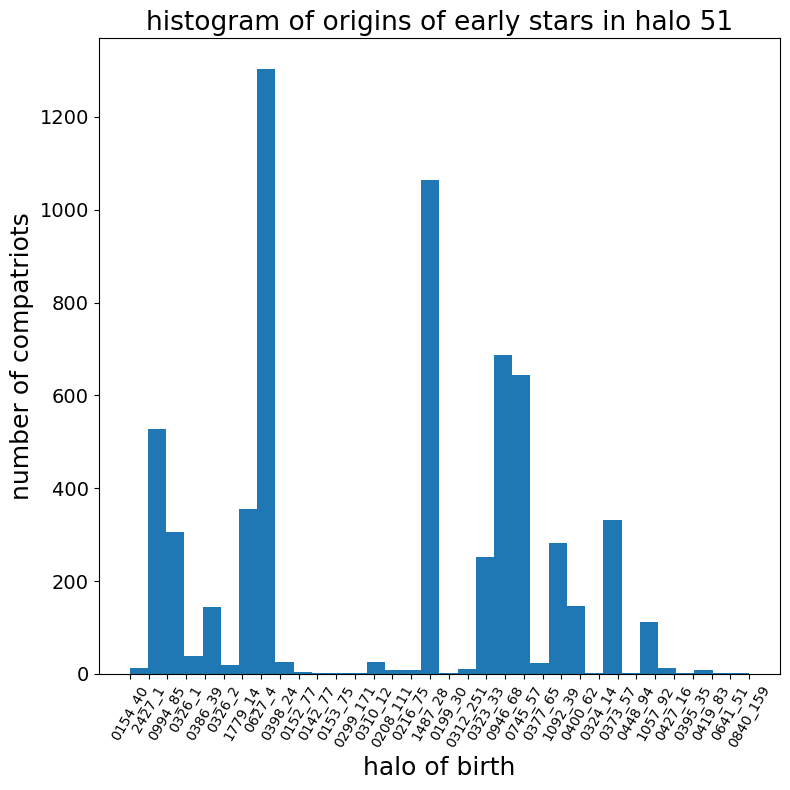

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.hist(early_star_halo_origins, bins=np.size(np.unique(early_star_halo_origins)))
ax.tick_params('x', rotation=60)

plt.title('histogram of origins of early stars in halo 51', fontsize=19)
plt.xlabel('halo of birth', fontsize=18)
plt.xticks(fontsize=10)
plt.ylabel('number of compatriots', fontsize=18)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/halo51_early_star_origins.png')

plt.show()

In [50]:
print(all_categorized_lost_stars[1])

[62161280.0, 62198170.0, 62327244.0, 62407652.0, 62593376.0, 62669630.0, 62719110.0, 62741044.0, 62974500.0, 63036600.0, 63090550.0, 25338184.0, 28325388.0, 61278372.0, 61279656.0, 61287410.0, 61448844.0, 61597930.0, 61802384.0, 62033756.0, 62055500.0, 62058804.0, 62063440.0, 62072080.0, 62120090.0, 62142920.0, 62146148.0, 62154750.0, 62156310.0, 62158360.0, 62174724.0, 62177830.0, 62214308.0, 62244536.0, 62255776.0, 62270090.0, 62282920.0, 62286040.0, 62290716.0, 62299976.0, 62325880.0, 62332380.0, 62333200.0, 62336940.0, 62360612.0, 62364644.0, 62410010.0, 62411490.0, 62413724.0, 62422972.0, 62436510.0, 62448028.0, 62488976.0, 62495064.0, 62497200.0, 62508132.0, 62509616.0, 62510020.0, 62519736.0, 62526090.0, 62535144.0, 62567904.0, 62569520.0, 62574796.0, 62580548.0, 62584908.0, 62588400.0, 62593800.0, 62603050.0, 62619216.0, 62627188.0, 62663230.0, 62666424.0, 62681084.0, 62686996.0, 62690924.0, 62698212.0, 62711190.0, 62714800.0, 62717300.0, 62721564.0, 62723900.0, 62724136.0, 627

In [28]:
all_lost = all_categorized_lost_stars[all_starry_timesteps != 'DD2427']
all_lost_times = all_starry_timesteps[all_starry_timesteps != 'DD2427']

In [29]:
times_in_gyr = np.zeros(np.size(all_lost_times))

j = 0
while j < np.size(times_in_gyr):
    times_in_gyr[j] = sim[int(str(all_lost_times[j][2:])) - 44].time_gyr
    j += 1
    
print(times_in_gyr)
print(np.size(times_in_gyr))

[13.65434507 13.65434507 13.65434507 ...  4.29957097  4.191983
  4.08439503]
35139


In [34]:
lost_creation_times = []

for lost_array in all_lost:
    star_creation_times = []
    for lost_star in lost_array:
        if lost_star in pids:
            star_creation_times.append(ct[pids == lost_star][0])
    print(np.size(star_creation_times))
    lost_creation_times.append(star_creation_times)

226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226


KeyboardInterrupt: 

In [32]:
print(np.size(lost_creation_times))

188455
